## Load Display Page

In [1]:
import matplotlib.pyplot as plt

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Setup Environment

In [2]:
import gym_super_mario_bros

# import joypad wrapper
from nes_py.wrappers import JoypadSpace

# import actions (simplified version)
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [4]:
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# downsaple the action space from 256 -> 7 (standard to simple_movement)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

## Environment

In [5]:
env.action_space

Discrete(7)

In [6]:
env.observation_space.shape

(240, 256, 3)

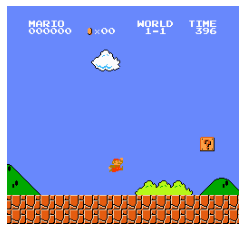

In [7]:
done = False

state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for step in range(100): 
    
    # select action
    action = env.action_space.sample()
    
    # set display layout
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    # step
    state, reward, done, info = env.step(action)
    
    if done:
        break
        
# Close the game
env.close()

## Preprocessing Data and Environment

* Frame Stacker: to get the history of the game and make the agent know what the position it is in against the enemies (like RNN)
* Gray Scale: in rgb, the pixels are three times as much as a grayscale, which indicates the same data as grayscales (cutting down useful data shape)

In [8]:
# import frame stacker
from gym.wrappers import GrayScaleObservation

from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [9]:
# 1. Create Base Environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')

#### Downscale Controls

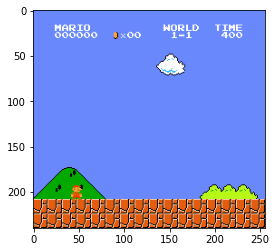

In [10]:
# 2. Simplify controls from 256 -> 7
env = JoypadSpace(env, SIMPLE_MOVEMENT)

state = env.reset()
plt.imshow(state)

#### Gray Scale Image Frame

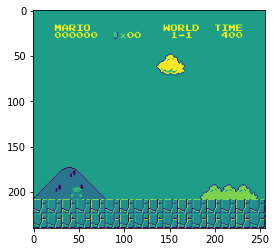

In [11]:
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)

state = env.reset()
plt.imshow(state)

#### Dummy vectorized env

In [12]:
# 4. Wrap inside DUmmy Environment
env = DummyVecEnv([lambda: env])

state = env.reset()
state.shape

(1, 240, 256, 1)

#### Stack Frames to give data memory

shape of env: (1, 240, 256, 4)


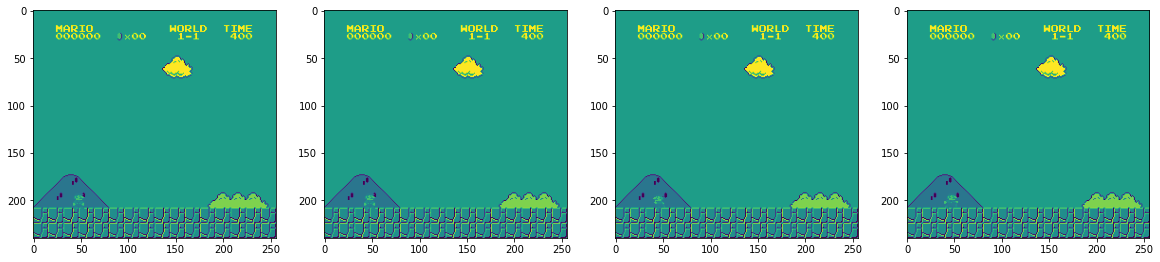

In [13]:
# 5. Stack frames
stacks = 4

env = VecFrameStack(env, stacks, channels_order='last')

state = env.reset()
print('shape of env:', state.shape)

# run 4 steps to visualize the stack
for i in range(stacks):
    state, reward, done, info = env.step([env.action_space.sample()])

# plot the stacks, history from left to right
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1, stacks,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

## Train Model

In [14]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [15]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1, name=None):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.name = name

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            if self.name==None:
                model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            else:
                model_path = os.path.join(self.save_path, f'{self.name}_{self.n_calls}')
            self.model.save(model_path)

        return True

In [16]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [17]:
callback = TrainAndLoggingCallback(check_freq=5e5, save_path=CHECKPOINT_DIR, name='10stacks')

In [18]:
model = PPO('CnnPolicy', env, verbose=1, learning_rate = 5e-6, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=5e6, callback=callback)

c:\users\11101\miniconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 88  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 2            |
|    time_elapsed         | 15           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0013112276 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.00244     |
|    learning_rate        | 5e-06        |
|    loss                 | 65           |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00242     |
|    value_loss           | 169          |
------------------------------------------
-----------------------

-------------------------------------------
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 13            |
|    time_elapsed         | 136           |
|    total_timesteps      | 6656          |
| train/                  |               |
|    approx_kl            | 0.00085692713 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.9          |
|    explained_variance   | 0.0321        |
|    learning_rate        | 5e-06         |
|    loss                 | 0.0426        |
|    n_updates            | 120           |
|    policy_gradient_loss | -0.00115      |
|    value_loss           | 0.146         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 14           |
|    time_elapsed         | 146     

----------------------------------------
| time/                   |            |
|    fps                  | 48         |
|    iterations           | 24         |
|    time_elapsed         | 250        |
|    total_timesteps      | 12288      |
| train/                  |            |
|    approx_kl            | 0.00521433 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.72      |
|    explained_variance   | -0.0559    |
|    learning_rate        | 5e-06      |
|    loss                 | 0.147      |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.00173   |
|    value_loss           | 1.42       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 25           |
|    time_elapsed         | 261          |
|    total_timesteps      | 12800        |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 35           |
|    time_elapsed         | 365          |
|    total_timesteps      | 17920        |
| train/                  |              |
|    approx_kl            | 0.0018782871 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | -0.29        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0367       |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.000746    |
|    value_loss           | 0.868        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 36           |
|    time_elapsed         | 375          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 46           |
|    time_elapsed         | 480          |
|    total_timesteps      | 23552        |
| train/                  |              |
|    approx_kl            | 0.0012777742 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.0396       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.322        |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 0.435        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 47          |
|    time_elapsed         | 490         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 57           |
|    time_elapsed         | 594          |
|    total_timesteps      | 29184        |
| train/                  |              |
|    approx_kl            | 0.0033066662 |
|    clip_fraction        | 0.0244       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.673       |
|    explained_variance   | 0.119        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.167        |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.00286     |
|    value_loss           | 0.443        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 58           |
|    time_elapsed         | 604          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 68           |
|    time_elapsed         | 708          |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0036116887 |
|    clip_fraction        | 0.0244       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.558       |
|    explained_variance   | -0.123       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.169        |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00199     |
|    value_loss           | 0.945        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 69           |
|    time_elapsed         | 718          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 79           |
|    time_elapsed         | 821          |
|    total_timesteps      | 40448        |
| train/                  |              |
|    approx_kl            | 0.0019986765 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.507       |
|    explained_variance   | 0.0394       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.285        |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 0.57         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 80          |
|    time_elapsed         | 832         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 90           |
|    time_elapsed         | 936          |
|    total_timesteps      | 46080        |
| train/                  |              |
|    approx_kl            | 7.507275e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.127       |
|    explained_variance   | 0.00695      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.766        |
|    n_updates            | 890          |
|    policy_gradient_loss | 2.59e-05     |
|    value_loss           | 2.47         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 91           |
|    time_elapsed         | 946          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 101          |
|    time_elapsed         | 1050         |
|    total_timesteps      | 51712        |
| train/                  |              |
|    approx_kl            | 0.0003502092 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.723        |
|    learning_rate        | 5e-06        |
|    loss                 | 12.8         |
|    n_updates            | 1000         |
|    policy_gradient_loss | 0.000195     |
|    value_loss           | 63.3         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 102          |
|    time_elapsed         | 1060         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 49          |
|    iterations           | 112         |
|    time_elapsed         | 1166        |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.002518126 |
|    clip_fraction        | 0.0121      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.217      |
|    explained_variance   | -0.0913     |
|    learning_rate        | 5e-06       |
|    loss                 | 0.104       |
|    n_updates            | 1110        |
|    policy_gradient_loss | 0.000556    |
|    value_loss           | 0.714       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 113          |
|    time_elapsed         | 1176         |
|    total_timesteps      | 5

------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 123          |
|    time_elapsed         | 1281         |
|    total_timesteps      | 62976        |
| train/                  |              |
|    approx_kl            | 0.0022691013 |
|    clip_fraction        | 0.0396       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.289       |
|    explained_variance   | 0.00905      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.482        |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.00351     |
|    value_loss           | 0.615        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 124          |
|    time_elapsed         | 1291         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 134           |
|    time_elapsed         | 1397          |
|    total_timesteps      | 68608         |
| train/                  |               |
|    approx_kl            | 1.9117724e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0735       |
|    explained_variance   | 0.681         |
|    learning_rate        | 5e-06         |
|    loss                 | 89.9          |
|    n_updates            | 1330          |
|    policy_gradient_loss | 0.000583      |
|    value_loss           | 164           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 135           |
|    time_elapsed         | 1407

-------------------------------------------
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 145           |
|    time_elapsed         | 1513          |
|    total_timesteps      | 74240         |
| train/                  |               |
|    approx_kl            | 0.00022414594 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.235        |
|    explained_variance   | -0.163        |
|    learning_rate        | 5e-06         |
|    loss                 | 2.13          |
|    n_updates            | 1440          |
|    policy_gradient_loss | -0.00054      |
|    value_loss           | 1.95          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 49            |
|    iterations           | 146           |
|    time_elapsed         | 1525

-------------------------------------------
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 156           |
|    time_elapsed         | 1639          |
|    total_timesteps      | 79872         |
| train/                  |               |
|    approx_kl            | 0.00039935322 |
|    clip_fraction        | 0.00352       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.184        |
|    explained_variance   | -0.0452       |
|    learning_rate        | 5e-06         |
|    loss                 | 0.13          |
|    n_updates            | 1550          |
|    policy_gradient_loss | -0.000849     |
|    value_loss           | 1.03          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 157         |
|    time_elapsed         | 1651        

------------------------------------------
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 167          |
|    time_elapsed         | 1764         |
|    total_timesteps      | 85504        |
| train/                  |              |
|    approx_kl            | 0.0012262631 |
|    clip_fraction        | 0.00957      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.945        |
|    learning_rate        | 5e-06        |
|    loss                 | 17.6         |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.0007      |
|    value_loss           | 57.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 168          |
|    time_elapsed         | 1776         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 178           |
|    time_elapsed         | 1889          |
|    total_timesteps      | 91136         |
| train/                  |               |
|    approx_kl            | 0.00013550429 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0558       |
|    explained_variance   | -0.00935      |
|    learning_rate        | 5e-06         |
|    loss                 | 0.206         |
|    n_updates            | 1770          |
|    policy_gradient_loss | -9.17e-05     |
|    value_loss           | 0.194         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 179          |
|    time_elapsed         | 1901    

-------------------------------------------
| time/                   |               |
|    fps                  | 48            |
|    iterations           | 189           |
|    time_elapsed         | 2015          |
|    total_timesteps      | 96768         |
| train/                  |               |
|    approx_kl            | 0.00015462562 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0495       |
|    explained_variance   | -1.14         |
|    learning_rate        | 5e-06         |
|    loss                 | 0.127         |
|    n_updates            | 1880          |
|    policy_gradient_loss | -0.000212     |
|    value_loss           | 1.21          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 190           |
|    time_elapsed         | 2027

------------------------------------------
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 200          |
|    time_elapsed         | 2534         |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0008126815 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.125       |
|    explained_variance   | -0.0838      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.138        |
|    n_updates            | 1990         |
|    policy_gradient_loss | -0.000315    |
|    value_loss           | 0.39         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 201          |
|    time_elapsed         | 2545         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 211           |
|    time_elapsed         | 2662          |
|    total_timesteps      | 108032        |
| train/                  |               |
|    approx_kl            | 0.00056609185 |
|    clip_fraction        | 0.00156       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.118        |
|    explained_variance   | 0.134         |
|    learning_rate        | 5e-06         |
|    loss                 | 0.965         |
|    n_updates            | 2100          |
|    policy_gradient_loss | -0.000192     |
|    value_loss           | 1.72          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 212          |
|    time_elapsed         | 2674    

-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 222           |
|    time_elapsed         | 2791          |
|    total_timesteps      | 113664        |
| train/                  |               |
|    approx_kl            | 0.00028558238 |
|    clip_fraction        | 0.0041        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0956       |
|    explained_variance   | -0.0404       |
|    learning_rate        | 5e-06         |
|    loss                 | 0.59          |
|    n_updates            | 2210          |
|    policy_gradient_loss | -0.0023       |
|    value_loss           | 1.24          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 223           |
|    time_elapsed         | 2803

-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 233           |
|    time_elapsed         | 2921          |
|    total_timesteps      | 119296        |
| train/                  |               |
|    approx_kl            | 0.00013498135 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.102        |
|    explained_variance   | 0.0334        |
|    learning_rate        | 5e-06         |
|    loss                 | 0.813         |
|    n_updates            | 2320          |
|    policy_gradient_loss | -0.00041      |
|    value_loss           | 1.19          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 40           |
|    iterations           | 234          |
|    time_elapsed         | 2932    

-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 244           |
|    time_elapsed         | 3048          |
|    total_timesteps      | 124928        |
| train/                  |               |
|    approx_kl            | 0.00084789784 |
|    clip_fraction        | 0.0043        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0766       |
|    explained_variance   | -0.0696       |
|    learning_rate        | 5e-06         |
|    loss                 | 0.265         |
|    n_updates            | 2430          |
|    policy_gradient_loss | -0.000135     |
|    value_loss           | 0.999         |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 40            |
|    iterations           | 245           |
|    time_elapsed         | 3060

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 255          |
|    time_elapsed         | 3175         |
|    total_timesteps      | 130560       |
| train/                  |              |
|    approx_kl            | 2.814806e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0934      |
|    explained_variance   | -0.0483      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.214        |
|    n_updates            | 2540         |
|    policy_gradient_loss | -8.07e-06    |
|    value_loss           | 1.2          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 256          |
|    time_elapsed         | 3187         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 266          |
|    time_elapsed         | 3304         |
|    total_timesteps      | 136192       |
| train/                  |              |
|    approx_kl            | 0.0012387248 |
|    clip_fraction        | 0.00645      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.77         |
|    learning_rate        | 5e-06        |
|    loss                 | 136          |
|    n_updates            | 2650         |
|    policy_gradient_loss | -0.0027      |
|    value_loss           | 279          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 41          |
|    iterations           | 267         |
|    time_elapsed         | 3315        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 277          |
|    time_elapsed         | 3431         |
|    total_timesteps      | 141824       |
| train/                  |              |
|    approx_kl            | 0.0003334263 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | -0.346       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0568       |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.000308    |
|    value_loss           | 0.837        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 278          |
|    time_elapsed         | 3443         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 288           |
|    time_elapsed         | 3558          |
|    total_timesteps      | 147456        |
| train/                  |               |
|    approx_kl            | 6.3867425e-05 |
|    clip_fraction        | 0.000781      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.146        |
|    explained_variance   | -0.0928       |
|    learning_rate        | 5e-06         |
|    loss                 | 0.653         |
|    n_updates            | 2870          |
|    policy_gradient_loss | 0.000186      |
|    value_loss           | 1.21          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 289          |
|    time_elapsed         | 3570    

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 299          |
|    time_elapsed         | 3686         |
|    total_timesteps      | 153088       |
| train/                  |              |
|    approx_kl            | 8.919998e-05 |
|    clip_fraction        | 0.00645      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.14        |
|    explained_variance   | -0.0275      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0781       |
|    n_updates            | 2980         |
|    policy_gradient_loss | 0.000263     |
|    value_loss           | 0.338        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 300           |
|    time_elapsed         | 3697          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 310          |
|    time_elapsed         | 3813         |
|    total_timesteps      | 158720       |
| train/                  |              |
|    approx_kl            | 0.0006718312 |
|    clip_fraction        | 0.00684      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | -0.203       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.082        |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.000759    |
|    value_loss           | 0.209        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 311          |
|    time_elapsed         | 3824         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 321          |
|    time_elapsed         | 3940         |
|    total_timesteps      | 164352       |
| train/                  |              |
|    approx_kl            | 9.292236e-05 |
|    clip_fraction        | 0.00234      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.292       |
|    explained_variance   | 0.0867       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0621       |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.00035     |
|    value_loss           | 0.669        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 322          |
|    time_elapsed         | 3952         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 332          |
|    time_elapsed         | 4068         |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0011718262 |
|    clip_fraction        | 0.0213       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.489       |
|    explained_variance   | 0.882        |
|    learning_rate        | 5e-06        |
|    loss                 | 41.9         |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.00626     |
|    value_loss           | 123          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 333          |
|    time_elapsed         | 4079         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 343          |
|    time_elapsed         | 4196         |
|    total_timesteps      | 175616       |
| train/                  |              |
|    approx_kl            | 0.0009493603 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.52        |
|    explained_variance   | -0.268       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0865       |
|    n_updates            | 3420         |
|    policy_gradient_loss | -0.000511    |
|    value_loss           | 0.442        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 344          |
|    time_elapsed         | 4207         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 354          |
|    time_elapsed         | 4323         |
|    total_timesteps      | 181248       |
| train/                  |              |
|    approx_kl            | 0.0016691958 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.55        |
|    explained_variance   | -0.44        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.077        |
|    n_updates            | 3530         |
|    policy_gradient_loss | -0.000321    |
|    value_loss           | 0.228        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 355          |
|    time_elapsed         | 4335         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 365          |
|    time_elapsed         | 4450         |
|    total_timesteps      | 186880       |
| train/                  |              |
|    approx_kl            | 0.0009771262 |
|    clip_fraction        | 0.00527      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.716       |
|    explained_variance   | -0.292       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.378        |
|    n_updates            | 3640         |
|    policy_gradient_loss | -0.00112     |
|    value_loss           | 2.11         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 366          |
|    time_elapsed         | 4462         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 376          |
|    time_elapsed         | 4578         |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0060677663 |
|    clip_fraction        | 0.0184       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | -0.288       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.107        |
|    n_updates            | 3750         |
|    policy_gradient_loss | -0.00398     |
|    value_loss           | 0.197        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 377          |
|    time_elapsed         | 4589         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 387          |
|    time_elapsed         | 4707         |
|    total_timesteps      | 198144       |
| train/                  |              |
|    approx_kl            | 0.0044801645 |
|    clip_fraction        | 0.0326       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.598       |
|    explained_variance   | -0.242       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.113        |
|    n_updates            | 3860         |
|    policy_gradient_loss | -0.00384     |
|    value_loss           | 0.398        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 388          |
|    time_elapsed         | 4719         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 398         |
|    time_elapsed         | 4836        |
|    total_timesteps      | 203776      |
| train/                  |             |
|    approx_kl            | 0.004879996 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.699      |
|    explained_variance   | -0.317      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.137       |
|    n_updates            | 3970        |
|    policy_gradient_loss | -0.00232    |
|    value_loss           | 0.405       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 399         |
|    time_elapsed         | 4848        |
|    total_timesteps      | 204288

-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 409         |
|    time_elapsed         | 4964        |
|    total_timesteps      | 209408      |
| train/                  |             |
|    approx_kl            | 0.010548587 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.707      |
|    explained_variance   | -0.137      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.108       |
|    n_updates            | 4080        |
|    policy_gradient_loss | -0.00268    |
|    value_loss           | 0.331       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 410          |
|    time_elapsed         | 4976         |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 420          |
|    time_elapsed         | 5093         |
|    total_timesteps      | 215040       |
| train/                  |              |
|    approx_kl            | 0.0014661022 |
|    clip_fraction        | 0.0342       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.259       |
|    explained_variance   | 0.808        |
|    learning_rate        | 5e-06        |
|    loss                 | 106          |
|    n_updates            | 4190         |
|    policy_gradient_loss | 8.35e-05     |
|    value_loss           | 195          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 421           |
|    time_elapsed         | 5105          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 431           |
|    time_elapsed         | 5224          |
|    total_timesteps      | 220672        |
| train/                  |               |
|    approx_kl            | 0.00021940132 |
|    clip_fraction        | 0.000195      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.161        |
|    explained_variance   | 0.797         |
|    learning_rate        | 5e-06         |
|    loss                 | 143           |
|    n_updates            | 4300          |
|    policy_gradient_loss | -1.3e-05      |
|    value_loss           | 262           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 432          |
|    time_elapsed         | 5235    

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 442          |
|    time_elapsed         | 5352         |
|    total_timesteps      | 226304       |
| train/                  |              |
|    approx_kl            | 0.0015445285 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.22        |
|    explained_variance   | 0.391        |
|    learning_rate        | 5e-06        |
|    loss                 | 240          |
|    n_updates            | 4410         |
|    policy_gradient_loss | -0.00029     |
|    value_loss           | 668          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 443          |
|    time_elapsed         | 5363         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 453          |
|    time_elapsed         | 5481         |
|    total_timesteps      | 231936       |
| train/                  |              |
|    approx_kl            | 0.0007508332 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.744        |
|    learning_rate        | 5e-06        |
|    loss                 | 449          |
|    n_updates            | 4520         |
|    policy_gradient_loss | -0.000435    |
|    value_loss           | 566          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 42         |
|    iterations           | 454        |
|    time_elapsed         | 5493       |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 464          |
|    time_elapsed         | 5610         |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0003509227 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.342        |
|    learning_rate        | 5e-06        |
|    loss                 | 147          |
|    n_updates            | 4630         |
|    policy_gradient_loss | -3.72e-05    |
|    value_loss           | 797          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 465          |
|    time_elapsed         | 5622         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 475          |
|    time_elapsed         | 5740         |
|    total_timesteps      | 243200       |
| train/                  |              |
|    approx_kl            | 0.0023531746 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.143       |
|    explained_variance   | 0.587        |
|    learning_rate        | 5e-06        |
|    loss                 | 95.1         |
|    n_updates            | 4740         |
|    policy_gradient_loss | -0.00178     |
|    value_loss           | 253          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 476          |
|    time_elapsed         | 5752         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 486         |
|    time_elapsed         | 5872        |
|    total_timesteps      | 248832      |
| train/                  |             |
|    approx_kl            | 0.005915091 |
|    clip_fraction        | 0.0432      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.514      |
|    explained_variance   | 0.048       |
|    learning_rate        | 5e-06       |
|    loss                 | 1.32        |
|    n_updates            | 4850        |
|    policy_gradient_loss | 3.96e-05    |
|    value_loss           | 12.9        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 487           |
|    time_elapsed         | 5884          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 497          |
|    time_elapsed         | 6003         |
|    total_timesteps      | 254464       |
| train/                  |              |
|    approx_kl            | 0.0020639426 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.87         |
|    learning_rate        | 5e-06        |
|    loss                 | 94           |
|    n_updates            | 4960         |
|    policy_gradient_loss | -0.00292     |
|    value_loss           | 182          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 498         |
|    time_elapsed         | 6015        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 508          |
|    time_elapsed         | 6132         |
|    total_timesteps      | 260096       |
| train/                  |              |
|    approx_kl            | 0.0015331429 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0951      |
|    explained_variance   | 0.633        |
|    learning_rate        | 5e-06        |
|    loss                 | 76.5         |
|    n_updates            | 5070         |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 195          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 509          |
|    time_elapsed         | 6144         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 519          |
|    time_elapsed         | 6261         |
|    total_timesteps      | 265728       |
| train/                  |              |
|    approx_kl            | 0.0013611565 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.121       |
|    explained_variance   | 0.506        |
|    learning_rate        | 5e-06        |
|    loss                 | 475          |
|    n_updates            | 5180         |
|    policy_gradient_loss | -0.001       |
|    value_loss           | 678          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 520         |
|    time_elapsed         | 6272        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 530          |
|    time_elapsed         | 6387         |
|    total_timesteps      | 271360       |
| train/                  |              |
|    approx_kl            | 0.0006798436 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.102       |
|    explained_variance   | 0.564        |
|    learning_rate        | 5e-06        |
|    loss                 | 394          |
|    n_updates            | 5290         |
|    policy_gradient_loss | -0.00246     |
|    value_loss           | 552          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 531           |
|    time_elapsed         | 6399          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 541           |
|    time_elapsed         | 6520          |
|    total_timesteps      | 276992        |
| train/                  |               |
|    approx_kl            | 0.00050356577 |
|    clip_fraction        | 0.0102        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.139        |
|    explained_variance   | 0.474         |
|    learning_rate        | 5e-06         |
|    loss                 | 241           |
|    n_updates            | 5400          |
|    policy_gradient_loss | -0.000865     |
|    value_loss           | 681           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 542          |
|    time_elapsed         | 6532    

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 552          |
|    time_elapsed         | 6651         |
|    total_timesteps      | 282624       |
| train/                  |              |
|    approx_kl            | 0.0018581664 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.215       |
|    explained_variance   | 0.309        |
|    learning_rate        | 5e-06        |
|    loss                 | 715          |
|    n_updates            | 5510         |
|    policy_gradient_loss | -0.00326     |
|    value_loss           | 848          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 553          |
|    time_elapsed         | 6663         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 563           |
|    time_elapsed         | 6780          |
|    total_timesteps      | 288256        |
| train/                  |               |
|    approx_kl            | 5.2724732e-05 |
|    clip_fraction        | 0.00371       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.207        |
|    explained_variance   | 0.755         |
|    learning_rate        | 5e-06         |
|    loss                 | 84            |
|    n_updates            | 5620          |
|    policy_gradient_loss | -0.0012       |
|    value_loss           | 221           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 564          |
|    time_elapsed         | 6792    

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 574          |
|    time_elapsed         | 6909         |
|    total_timesteps      | 293888       |
| train/                  |              |
|    approx_kl            | 0.0023961288 |
|    clip_fraction        | 0.0281       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.113       |
|    explained_variance   | 0.691        |
|    learning_rate        | 5e-06        |
|    loss                 | 235          |
|    n_updates            | 5730         |
|    policy_gradient_loss | -0.00194     |
|    value_loss           | 422          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 575          |
|    time_elapsed         | 6921         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 585          |
|    time_elapsed         | 7038         |
|    total_timesteps      | 299520       |
| train/                  |              |
|    approx_kl            | 0.0013994867 |
|    clip_fraction        | 0.0109       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.137       |
|    explained_variance   | 0.587        |
|    learning_rate        | 5e-06        |
|    loss                 | 135          |
|    n_updates            | 5840         |
|    policy_gradient_loss | -0.0024      |
|    value_loss           | 241          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 586           |
|    time_elapsed         | 7049          |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 596          |
|    time_elapsed         | 7167         |
|    total_timesteps      | 305152       |
| train/                  |              |
|    approx_kl            | 0.0028823516 |
|    clip_fraction        | 0.0211       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.951        |
|    learning_rate        | 5e-06        |
|    loss                 | 25.8         |
|    n_updates            | 5950         |
|    policy_gradient_loss | -0.00159     |
|    value_loss           | 82.9         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 597         |
|    time_elapsed         | 7179        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 607          |
|    time_elapsed         | 7295         |
|    total_timesteps      | 310784       |
| train/                  |              |
|    approx_kl            | 0.0008839228 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.095       |
|    explained_variance   | 0.743        |
|    learning_rate        | 5e-06        |
|    loss                 | 154          |
|    n_updates            | 6060         |
|    policy_gradient_loss | -0.000824    |
|    value_loss           | 294          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 608           |
|    time_elapsed         | 7307          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 618           |
|    time_elapsed         | 7424          |
|    total_timesteps      | 316416        |
| train/                  |               |
|    approx_kl            | 0.00015460025 |
|    clip_fraction        | 0.0119        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.287        |
|    explained_variance   | 0.722         |
|    learning_rate        | 5e-06         |
|    loss                 | 150           |
|    n_updates            | 6170          |
|    policy_gradient_loss | -0.000111     |
|    value_loss           | 562           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 619          |
|    time_elapsed         | 7435    

-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 629         |
|    time_elapsed         | 7553        |
|    total_timesteps      | 322048      |
| train/                  |             |
|    approx_kl            | 0.002656238 |
|    clip_fraction        | 0.0209      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.191      |
|    explained_variance   | 0.738       |
|    learning_rate        | 5e-06       |
|    loss                 | 275         |
|    n_updates            | 6280        |
|    policy_gradient_loss | -0.00195    |
|    value_loss           | 466         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 630          |
|    time_elapsed         | 7566         |
|    total_timesteps      | 3

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 640          |
|    time_elapsed         | 7685         |
|    total_timesteps      | 327680       |
| train/                  |              |
|    approx_kl            | 0.0006763048 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.125       |
|    explained_variance   | 0.538        |
|    learning_rate        | 5e-06        |
|    loss                 | 340          |
|    n_updates            | 6390         |
|    policy_gradient_loss | -0.000921    |
|    value_loss           | 550          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 641          |
|    time_elapsed         | 7697         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 651           |
|    time_elapsed         | 7816          |
|    total_timesteps      | 333312        |
| train/                  |               |
|    approx_kl            | 0.00042650464 |
|    clip_fraction        | 0.00547       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.078        |
|    explained_variance   | 0.449         |
|    learning_rate        | 5e-06         |
|    loss                 | 385           |
|    n_updates            | 6500          |
|    policy_gradient_loss | -0.00139      |
|    value_loss           | 1.11e+03      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 652           |
|    time_elapsed         | 7827

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 662          |
|    time_elapsed         | 7945         |
|    total_timesteps      | 338944       |
| train/                  |              |
|    approx_kl            | 8.972897e-05 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.046       |
|    explained_variance   | 0.717        |
|    learning_rate        | 5e-06        |
|    loss                 | 528          |
|    n_updates            | 6610         |
|    policy_gradient_loss | -0.000257    |
|    value_loss           | 705          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 663          |
|    time_elapsed         | 7957         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 673          |
|    time_elapsed         | 8073         |
|    total_timesteps      | 344576       |
| train/                  |              |
|    approx_kl            | 0.0008980157 |
|    clip_fraction        | 0.00273      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0861      |
|    explained_variance   | 0.866        |
|    learning_rate        | 5e-06        |
|    loss                 | 32.4         |
|    n_updates            | 6720         |
|    policy_gradient_loss | -0.000359    |
|    value_loss           | 96.6         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 674           |
|    time_elapsed         | 8085          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 684           |
|    time_elapsed         | 8203          |
|    total_timesteps      | 350208        |
| train/                  |               |
|    approx_kl            | 2.9599527e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0825       |
|    explained_variance   | 0.736         |
|    learning_rate        | 5e-06         |
|    loss                 | 238           |
|    n_updates            | 6830          |
|    policy_gradient_loss | -0.000143     |
|    value_loss           | 460           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 685           |
|    time_elapsed         | 8215

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 695          |
|    time_elapsed         | 8333         |
|    total_timesteps      | 355840       |
| train/                  |              |
|    approx_kl            | 0.0008589919 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.131       |
|    explained_variance   | 0.704        |
|    learning_rate        | 5e-06        |
|    loss                 | 96.6         |
|    n_updates            | 6940         |
|    policy_gradient_loss | -0.000338    |
|    value_loss           | 427          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 696          |
|    time_elapsed         | 8345         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 706          |
|    time_elapsed         | 8461         |
|    total_timesteps      | 361472       |
| train/                  |              |
|    approx_kl            | 0.0031598988 |
|    clip_fraction        | 0.0215       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.285       |
|    explained_variance   | 0.829        |
|    learning_rate        | 5e-06        |
|    loss                 | 230          |
|    n_updates            | 7050         |
|    policy_gradient_loss | -0.000277    |
|    value_loss           | 588          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 707          |
|    time_elapsed         | 8473         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 717          |
|    time_elapsed         | 8586         |
|    total_timesteps      | 367104       |
| train/                  |              |
|    approx_kl            | 0.0012954231 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.411        |
|    learning_rate        | 5e-06        |
|    loss                 | 84.2         |
|    n_updates            | 7160         |
|    policy_gradient_loss | 0.000222     |
|    value_loss           | 244          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 718         |
|    time_elapsed         | 8597        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 728          |
|    time_elapsed         | 8709         |
|    total_timesteps      | 372736       |
| train/                  |              |
|    approx_kl            | 7.491629e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.48         |
|    learning_rate        | 5e-06        |
|    loss                 | 190          |
|    n_updates            | 7270         |
|    policy_gradient_loss | -0.00014     |
|    value_loss           | 714          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 729          |
|    time_elapsed         | 8721         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 739          |
|    time_elapsed         | 8833         |
|    total_timesteps      | 378368       |
| train/                  |              |
|    approx_kl            | 0.0022476832 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.754        |
|    learning_rate        | 5e-06        |
|    loss                 | 59.7         |
|    n_updates            | 7380         |
|    policy_gradient_loss | -0.00362     |
|    value_loss           | 114          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 740          |
|    time_elapsed         | 8844         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 750           |
|    time_elapsed         | 8957          |
|    total_timesteps      | 384000        |
| train/                  |               |
|    approx_kl            | 0.00031266967 |
|    clip_fraction        | 0.0168        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.33         |
|    explained_variance   | 0.893         |
|    learning_rate        | 5e-06         |
|    loss                 | 94.4          |
|    n_updates            | 7490          |
|    policy_gradient_loss | -0.000488     |
|    value_loss           | 197           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 751           |
|    time_elapsed         | 8968

-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 761         |
|    time_elapsed         | 9081        |
|    total_timesteps      | 389632      |
| train/                  |             |
|    approx_kl            | 0.003990273 |
|    clip_fraction        | 0.0238      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.321      |
|    explained_variance   | 0.713       |
|    learning_rate        | 5e-06       |
|    loss                 | 106         |
|    n_updates            | 7600        |
|    policy_gradient_loss | -0.00198    |
|    value_loss           | 208         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 42          |
|    iterations           | 762         |
|    time_elapsed         | 9092        |
|    total_timesteps      | 390144

------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 772          |
|    time_elapsed         | 9204         |
|    total_timesteps      | 395264       |
| train/                  |              |
|    approx_kl            | 0.0010860866 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.444        |
|    learning_rate        | 5e-06        |
|    loss                 | 140          |
|    n_updates            | 7710         |
|    policy_gradient_loss | -0.000955    |
|    value_loss           | 533          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 773          |
|    time_elapsed         | 9216         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 783           |
|    time_elapsed         | 9328          |
|    total_timesteps      | 400896        |
| train/                  |               |
|    approx_kl            | 0.00022597401 |
|    clip_fraction        | 0.00273       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.437        |
|    explained_variance   | 0.879         |
|    learning_rate        | 5e-06         |
|    loss                 | 42.7          |
|    n_updates            | 7820          |
|    policy_gradient_loss | -4.35e-05     |
|    value_loss           | 107           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 42           |
|    iterations           | 784          |
|    time_elapsed         | 9339    

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 794          |
|    time_elapsed         | 9452         |
|    total_timesteps      | 406528       |
| train/                  |              |
|    approx_kl            | 0.0011008782 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 0.768        |
|    learning_rate        | 5e-06        |
|    loss                 | 62.9         |
|    n_updates            | 7930         |
|    policy_gradient_loss | -0.00195     |
|    value_loss           | 169          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 795          |
|    time_elapsed         | 9463         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 805           |
|    time_elapsed         | 9576          |
|    total_timesteps      | 412160        |
| train/                  |               |
|    approx_kl            | 2.7004047e-05 |
|    clip_fraction        | 0.0143        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.167        |
|    explained_variance   | 0.874         |
|    learning_rate        | 5e-06         |
|    loss                 | 24.8          |
|    n_updates            | 8040          |
|    policy_gradient_loss | -0.000572     |
|    value_loss           | 85            |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 806           |
|    time_elapsed         | 9587

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 816          |
|    time_elapsed         | 9700         |
|    total_timesteps      | 417792       |
| train/                  |              |
|    approx_kl            | 3.448513e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0395      |
|    explained_variance   | 0.658        |
|    learning_rate        | 5e-06        |
|    loss                 | 257          |
|    n_updates            | 8150         |
|    policy_gradient_loss | -0.000401    |
|    value_loss           | 662          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 817          |
|    time_elapsed         | 9711         |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 827           |
|    time_elapsed         | 9823          |
|    total_timesteps      | 423424        |
| train/                  |               |
|    approx_kl            | 0.00067821576 |
|    clip_fraction        | 0.00781       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.108        |
|    explained_variance   | 0.833         |
|    learning_rate        | 5e-06         |
|    loss                 | 58.3          |
|    n_updates            | 8260          |
|    policy_gradient_loss | -1.51e-07     |
|    value_loss           | 146           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 828           |
|    time_elapsed         | 9835

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 838           |
|    time_elapsed         | 9947          |
|    total_timesteps      | 429056        |
| train/                  |               |
|    approx_kl            | 0.00010801875 |
|    clip_fraction        | 0.000391      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.076        |
|    explained_variance   | 0.819         |
|    learning_rate        | 5e-06         |
|    loss                 | 202           |
|    n_updates            | 8370          |
|    policy_gradient_loss | -0.000596     |
|    value_loss           | 364           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 839           |
|    time_elapsed         | 9958

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 849          |
|    time_elapsed         | 10070        |
|    total_timesteps      | 434688       |
| train/                  |              |
|    approx_kl            | 0.0032680854 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.128       |
|    explained_variance   | 0.758        |
|    learning_rate        | 5e-06        |
|    loss                 | 166          |
|    n_updates            | 8480         |
|    policy_gradient_loss | -0.000554    |
|    value_loss           | 454          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 850           |
|    time_elapsed         | 10082         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 860          |
|    time_elapsed         | 10194        |
|    total_timesteps      | 440320       |
| train/                  |              |
|    approx_kl            | 0.0007459796 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.159       |
|    explained_variance   | 0.856        |
|    learning_rate        | 5e-06        |
|    loss                 | 192          |
|    n_updates            | 8590         |
|    policy_gradient_loss | 0.000689     |
|    value_loss           | 477          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 861           |
|    time_elapsed         | 10205         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 871           |
|    time_elapsed         | 10336         |
|    total_timesteps      | 445952        |
| train/                  |               |
|    approx_kl            | 0.00049190514 |
|    clip_fraction        | 0.0043        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.116        |
|    explained_variance   | 0.525         |
|    learning_rate        | 5e-06         |
|    loss                 | 64            |
|    n_updates            | 8700          |
|    policy_gradient_loss | -0.00124      |
|    value_loss           | 731           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 872           |
|    time_elapsed         | 1034

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 882          |
|    time_elapsed         | 10460        |
|    total_timesteps      | 451584       |
| train/                  |              |
|    approx_kl            | 0.0029676463 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.833        |
|    learning_rate        | 5e-06        |
|    loss                 | 41.8         |
|    n_updates            | 8810         |
|    policy_gradient_loss | -0.00169     |
|    value_loss           | 130          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 883           |
|    time_elapsed         | 10471         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 893         |
|    time_elapsed         | 10584       |
|    total_timesteps      | 457216      |
| train/                  |             |
|    approx_kl            | 0.004913478 |
|    clip_fraction        | 0.0205      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0941     |
|    explained_variance   | 0.58        |
|    learning_rate        | 5e-06       |
|    loss                 | 75.8        |
|    n_updates            | 8920        |
|    policy_gradient_loss | -0.00412    |
|    value_loss           | 215         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 894          |
|    time_elapsed         | 10595        |
|    total_timesteps      | 4

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 904          |
|    time_elapsed         | 10707        |
|    total_timesteps      | 462848       |
| train/                  |              |
|    approx_kl            | 0.0023102546 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.281       |
|    explained_variance   | 0.294        |
|    learning_rate        | 5e-06        |
|    loss                 | 223          |
|    n_updates            | 9030         |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 1.1e+03      |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 905           |
|    time_elapsed         | 10719         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 915          |
|    time_elapsed         | 10831        |
|    total_timesteps      | 468480       |
| train/                  |              |
|    approx_kl            | 0.0007121874 |
|    clip_fraction        | 0.0357       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.788       |
|    explained_variance   | -0.206       |
|    learning_rate        | 5e-06        |
|    loss                 | 1            |
|    n_updates            | 9140         |
|    policy_gradient_loss | 0.00142      |
|    value_loss           | 6.71         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 916           |
|    time_elapsed         | 10842         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 926          |
|    time_elapsed         | 10954        |
|    total_timesteps      | 474112       |
| train/                  |              |
|    approx_kl            | 0.0027184691 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.721       |
|    explained_variance   | 0.721        |
|    learning_rate        | 5e-06        |
|    loss                 | 44           |
|    n_updates            | 9250         |
|    policy_gradient_loss | -0.00165     |
|    value_loss           | 175          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 927          |
|    time_elapsed         | 10966        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 937          |
|    time_elapsed         | 11078        |
|    total_timesteps      | 479744       |
| train/                  |              |
|    approx_kl            | 0.0008284155 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.491       |
|    explained_variance   | 0.941        |
|    learning_rate        | 5e-06        |
|    loss                 | 36.7         |
|    n_updates            | 9360         |
|    policy_gradient_loss | 0.0014       |
|    value_loss           | 91.5         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 938         |
|    time_elapsed         | 11089       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 948           |
|    time_elapsed         | 11202         |
|    total_timesteps      | 485376        |
| train/                  |               |
|    approx_kl            | 2.2810069e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.19         |
|    explained_variance   | 0.693         |
|    learning_rate        | 5e-06         |
|    loss                 | 61            |
|    n_updates            | 9470          |
|    policy_gradient_loss | -0.000158     |
|    value_loss           | 170           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 949           |
|    time_elapsed         | 1121

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 959          |
|    time_elapsed         | 11325        |
|    total_timesteps      | 491008       |
| train/                  |              |
|    approx_kl            | 0.0004533769 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.14        |
|    explained_variance   | 0.8          |
|    learning_rate        | 5e-06        |
|    loss                 | 53.6         |
|    n_updates            | 9580         |
|    policy_gradient_loss | 0.000171     |
|    value_loss           | 229          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 960          |
|    time_elapsed         | 11337        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 43         |
|    iterations           | 970        |
|    time_elapsed         | 11449      |
|    total_timesteps      | 496640     |
| train/                  |            |
|    approx_kl            | 0.00330274 |
|    clip_fraction        | 0.0137     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.261     |
|    explained_variance   | 0.655      |
|    learning_rate        | 5e-06      |
|    loss                 | 95.6       |
|    n_updates            | 9690       |
|    policy_gradient_loss | -0.00178   |
|    value_loss           | 301        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 971          |
|    time_elapsed         | 11460        |
|    total_timesteps      | 497152       |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 981          |
|    time_elapsed         | 11571        |
|    total_timesteps      | 502272       |
| train/                  |              |
|    approx_kl            | 0.0012097921 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.147       |
|    explained_variance   | 0.703        |
|    learning_rate        | 5e-06        |
|    loss                 | 169          |
|    n_updates            | 9800         |
|    policy_gradient_loss | -0.000725    |
|    value_loss           | 613          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 982           |
|    time_elapsed         | 11581         |
|    t

--------------------------------------------
| time/                   |                |
|    fps                  | 43             |
|    iterations           | 992            |
|    time_elapsed         | 11684          |
|    total_timesteps      | 507904         |
| train/                  |                |
|    approx_kl            | 1.04587525e-05 |
|    clip_fraction        | 0.0139         |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.192         |
|    explained_variance   | 0.772          |
|    learning_rate        | 5e-06          |
|    loss                 | 28.1           |
|    n_updates            | 9910           |
|    policy_gradient_loss | -0.000848      |
|    value_loss           | 104            |
--------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 993          |
|    time_elapsed 

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 1003          |
|    time_elapsed         | 11797         |
|    total_timesteps      | 513536        |
| train/                  |               |
|    approx_kl            | 0.00021990447 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.211        |
|    explained_variance   | 0.713         |
|    learning_rate        | 5e-06         |
|    loss                 | 64.8          |
|    n_updates            | 10020         |
|    policy_gradient_loss | -0.000233     |
|    value_loss           | 203           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 1004        |
|    time_elapsed         | 11807       

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1014         |
|    time_elapsed         | 11910        |
|    total_timesteps      | 519168       |
| train/                  |              |
|    approx_kl            | 0.0022874884 |
|    clip_fraction        | 0.0615       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.292       |
|    explained_variance   | 0.486        |
|    learning_rate        | 5e-06        |
|    loss                 | 560          |
|    n_updates            | 10130        |
|    policy_gradient_loss | -0.00237     |
|    value_loss           | 645          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1015         |
|    time_elapsed         | 11920        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 1025        |
|    time_elapsed         | 12023       |
|    total_timesteps      | 524800      |
| train/                  |             |
|    approx_kl            | 0.000674931 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.148      |
|    explained_variance   | 0.786       |
|    learning_rate        | 5e-06       |
|    loss                 | 41.9        |
|    n_updates            | 10240       |
|    policy_gradient_loss | -0.000274   |
|    value_loss           | 98.9        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 1026        |
|    time_elapsed         | 12033       |
|    total_timesteps      | 525312

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1036         |
|    time_elapsed         | 12136        |
|    total_timesteps      | 530432       |
| train/                  |              |
|    approx_kl            | 0.0003737586 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 0.634        |
|    learning_rate        | 5e-06        |
|    loss                 | 69.7         |
|    n_updates            | 10350        |
|    policy_gradient_loss | -0.000567    |
|    value_loss           | 220          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 1037          |
|    time_elapsed         | 12147         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1047         |
|    time_elapsed         | 12250        |
|    total_timesteps      | 536064       |
| train/                  |              |
|    approx_kl            | 0.0003640086 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.213       |
|    explained_variance   | 0.586        |
|    learning_rate        | 5e-06        |
|    loss                 | 106          |
|    n_updates            | 10460        |
|    policy_gradient_loss | -0.00125     |
|    value_loss           | 560          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1048         |
|    time_elapsed         | 12260        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 43            |
|    iterations           | 1058          |
|    time_elapsed         | 12363         |
|    total_timesteps      | 541696        |
| train/                  |               |
|    approx_kl            | 0.00044819014 |
|    clip_fraction        | 0.00117       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.147        |
|    explained_variance   | 0.819         |
|    learning_rate        | 5e-06         |
|    loss                 | 120           |
|    n_updates            | 10570         |
|    policy_gradient_loss | 0.000561      |
|    value_loss           | 286           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 1059        |
|    time_elapsed         | 12373       

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1069         |
|    time_elapsed         | 12476        |
|    total_timesteps      | 547328       |
| train/                  |              |
|    approx_kl            | 0.0009037863 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.132       |
|    explained_variance   | 0.488        |
|    learning_rate        | 5e-06        |
|    loss                 | 433          |
|    n_updates            | 10680        |
|    policy_gradient_loss | -0.000864    |
|    value_loss           | 616          |
------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 43             |
|    iterations           | 1070           |
|    time_elapsed         | 12486          |
|

-----------------------------------------
| time/                   |             |
|    fps                  | 43          |
|    iterations           | 1080        |
|    time_elapsed         | 12589       |
|    total_timesteps      | 552960      |
| train/                  |             |
|    approx_kl            | 0.002125565 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.287      |
|    explained_variance   | 0.45        |
|    learning_rate        | 5e-06       |
|    loss                 | 245         |
|    n_updates            | 10790       |
|    policy_gradient_loss | -0.00103    |
|    value_loss           | 749         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1081         |
|    time_elapsed         | 12599        |
|    total_timesteps      | 5

------------------------------------------
| time/                   |              |
|    fps                  | 43           |
|    iterations           | 1091         |
|    time_elapsed         | 12702        |
|    total_timesteps      | 558592       |
| train/                  |              |
|    approx_kl            | 0.0035131443 |
|    clip_fraction        | 0.0551       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.365       |
|    explained_variance   | 0.801        |
|    learning_rate        | 5e-06        |
|    loss                 | 50.8         |
|    n_updates            | 10900        |
|    policy_gradient_loss | -0.00532     |
|    value_loss           | 143          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 43         |
|    iterations           | 1092       |
|    time_elapsed         | 12712      |
|    total_timesteps 

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1102        |
|    time_elapsed         | 12815       |
|    total_timesteps      | 564224      |
| train/                  |             |
|    approx_kl            | 0.005052628 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.337      |
|    explained_variance   | 0.81        |
|    learning_rate        | 5e-06       |
|    loss                 | 20.6        |
|    n_updates            | 11010       |
|    policy_gradient_loss | -0.00398    |
|    value_loss           | 112         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1103          |
|    time_elapsed         | 12825         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1113          |
|    time_elapsed         | 12928         |
|    total_timesteps      | 569856        |
| train/                  |               |
|    approx_kl            | 0.00018409977 |
|    clip_fraction        | 0.00859       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.326        |
|    explained_variance   | 0.955         |
|    learning_rate        | 5e-06         |
|    loss                 | 24.5          |
|    n_updates            | 11120         |
|    policy_gradient_loss | -0.000558     |
|    value_loss           | 73.4          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1114         |
|    time_elapsed         | 12938   

-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1124          |
|    time_elapsed         | 13041         |
|    total_timesteps      | 575488        |
| train/                  |               |
|    approx_kl            | 0.00042393897 |
|    clip_fraction        | 0.00488       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.28         |
|    explained_variance   | 0.329         |
|    learning_rate        | 5e-06         |
|    loss                 | 333           |
|    n_updates            | 11230         |
|    policy_gradient_loss | 0.00256       |
|    value_loss           | 884           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1125        |
|    time_elapsed         | 13051       

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1135         |
|    time_elapsed         | 13154        |
|    total_timesteps      | 581120       |
| train/                  |              |
|    approx_kl            | 0.0016668318 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.717        |
|    learning_rate        | 5e-06        |
|    loss                 | 264          |
|    n_updates            | 11340        |
|    policy_gradient_loss | -0.0012      |
|    value_loss           | 470          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1136         |
|    time_elapsed         | 13164        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1146         |
|    time_elapsed         | 13267        |
|    total_timesteps      | 586752       |
| train/                  |              |
|    approx_kl            | 0.0013677008 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.262       |
|    explained_variance   | 0.819        |
|    learning_rate        | 5e-06        |
|    loss                 | 83.2         |
|    n_updates            | 11450        |
|    policy_gradient_loss | 0.000298     |
|    value_loss           | 216          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1147         |
|    time_elapsed         | 13277        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1157         |
|    time_elapsed         | 13380        |
|    total_timesteps      | 592384       |
| train/                  |              |
|    approx_kl            | 0.0008984518 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0584      |
|    explained_variance   | 0.515        |
|    learning_rate        | 5e-06        |
|    loss                 | 259          |
|    n_updates            | 11560        |
|    policy_gradient_loss | 0.00129      |
|    value_loss           | 628          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1158         |
|    time_elapsed         | 13390        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1168         |
|    time_elapsed         | 13493        |
|    total_timesteps      | 598016       |
| train/                  |              |
|    approx_kl            | 0.0026065046 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.37        |
|    explained_variance   | 0.886        |
|    learning_rate        | 5e-06        |
|    loss                 | 112          |
|    n_updates            | 11670        |
|    policy_gradient_loss | -0.00114     |
|    value_loss           | 236          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 44         |
|    iterations           | 1169       |
|    time_elapsed         | 13503      |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1179         |
|    time_elapsed         | 13606        |
|    total_timesteps      | 603648       |
| train/                  |              |
|    approx_kl            | 0.0023395596 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.597       |
|    explained_variance   | -0.87        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.671        |
|    n_updates            | 11780        |
|    policy_gradient_loss | -0.00121     |
|    value_loss           | 3.31         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1180        |
|    time_elapsed         | 13616       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1190         |
|    time_elapsed         | 13719        |
|    total_timesteps      | 609280       |
| train/                  |              |
|    approx_kl            | 0.0005084687 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | -0.595       |
|    learning_rate        | 5e-06        |
|    loss                 | 1.05         |
|    n_updates            | 11890        |
|    policy_gradient_loss | 0.000897     |
|    value_loss           | 4.85         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1191        |
|    time_elapsed         | 13729       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1201        |
|    time_elapsed         | 13832       |
|    total_timesteps      | 614912      |
| train/                  |             |
|    approx_kl            | 0.007054506 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.763      |
|    explained_variance   | -0.925      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.305       |
|    n_updates            | 12000       |
|    policy_gradient_loss | -0.00409    |
|    value_loss           | 0.699       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1202        |
|    time_elapsed         | 13842       |
|    total_timesteps      | 615424

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1212         |
|    time_elapsed         | 13945        |
|    total_timesteps      | 620544       |
| train/                  |              |
|    approx_kl            | 0.0028393816 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.327       |
|    explained_variance   | 0.836        |
|    learning_rate        | 5e-06        |
|    loss                 | 284          |
|    n_updates            | 12110        |
|    policy_gradient_loss | 0.000897     |
|    value_loss           | 553          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1213         |
|    time_elapsed         | 13955        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1223        |
|    time_elapsed         | 14058       |
|    total_timesteps      | 626176      |
| train/                  |             |
|    approx_kl            | 0.009400664 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | -0.39       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.43        |
|    n_updates            | 12220       |
|    policy_gradient_loss | -0.00246    |
|    value_loss           | 1.32        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1224        |
|    time_elapsed         | 14068       |
|    total_timesteps      | 626688

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1234        |
|    time_elapsed         | 14170       |
|    total_timesteps      | 631808      |
| train/                  |             |
|    approx_kl            | 0.006315975 |
|    clip_fraction        | 0.00703     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.613      |
|    explained_variance   | -0.625      |
|    learning_rate        | 5e-06       |
|    loss                 | 2.12        |
|    n_updates            | 12330       |
|    policy_gradient_loss | -0.00236    |
|    value_loss           | 22          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1235        |
|    time_elapsed         | 14180       |
|    total_timesteps      | 632320

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1245         |
|    time_elapsed         | 14282        |
|    total_timesteps      | 637440       |
| train/                  |              |
|    approx_kl            | 0.0067522307 |
|    clip_fraction        | 0.00371      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.749       |
|    explained_variance   | -0.425       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.302        |
|    n_updates            | 12440        |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 1.66         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1246        |
|    time_elapsed         | 14293       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1256        |
|    time_elapsed         | 14396       |
|    total_timesteps      | 643072      |
| train/                  |             |
|    approx_kl            | 0.006066249 |
|    clip_fraction        | 0.0441      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.264      |
|    explained_variance   | 0.89        |
|    learning_rate        | 5e-06       |
|    loss                 | 123         |
|    n_updates            | 12550       |
|    policy_gradient_loss | 0.00127     |
|    value_loss           | 574         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1257          |
|    time_elapsed         | 14406         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1267          |
|    time_elapsed         | 14509         |
|    total_timesteps      | 648704        |
| train/                  |               |
|    approx_kl            | 0.00035803893 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.125        |
|    explained_variance   | 0.739         |
|    learning_rate        | 5e-06         |
|    loss                 | 50.3          |
|    n_updates            | 12660         |
|    policy_gradient_loss | 0.00046       |
|    value_loss           | 176           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1268         |
|    time_elapsed         | 14519   

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1278         |
|    time_elapsed         | 14622        |
|    total_timesteps      | 654336       |
| train/                  |              |
|    approx_kl            | 0.0006610368 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.603        |
|    learning_rate        | 5e-06        |
|    loss                 | 85.4         |
|    n_updates            | 12770        |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 475          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1279          |
|    time_elapsed         | 14632         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 44          |
|    iterations           | 1289        |
|    time_elapsed         | 14735       |
|    total_timesteps      | 659968      |
| train/                  |             |
|    approx_kl            | 0.005025997 |
|    clip_fraction        | 0.0041      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.455      |
|    explained_variance   | -0.242      |
|    learning_rate        | 5e-06       |
|    loss                 | 1.98        |
|    n_updates            | 12880       |
|    policy_gradient_loss | -0.0013     |
|    value_loss           | 15.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1290         |
|    time_elapsed         | 14745        |
|    total_timesteps      | 6

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1300         |
|    time_elapsed         | 14848        |
|    total_timesteps      | 665600       |
| train/                  |              |
|    approx_kl            | 0.0005871409 |
|    clip_fraction        | 0.00684      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.791        |
|    learning_rate        | 5e-06        |
|    loss                 | 331          |
|    n_updates            | 12990        |
|    policy_gradient_loss | -0.00113     |
|    value_loss           | 777          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1301         |
|    time_elapsed         | 14858        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1311         |
|    time_elapsed         | 14961        |
|    total_timesteps      | 671232       |
| train/                  |              |
|    approx_kl            | 0.0010016429 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.226       |
|    explained_variance   | 0.716        |
|    learning_rate        | 5e-06        |
|    loss                 | 220          |
|    n_updates            | 13100        |
|    policy_gradient_loss | -0.0004      |
|    value_loss           | 726          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1312          |
|    time_elapsed         | 14971         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1322          |
|    time_elapsed         | 15073         |
|    total_timesteps      | 676864        |
| train/                  |               |
|    approx_kl            | 0.00044368336 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0878       |
|    explained_variance   | 0.663         |
|    learning_rate        | 5e-06         |
|    loss                 | 399           |
|    n_updates            | 13210         |
|    policy_gradient_loss | 0.000124      |
|    value_loss           | 655           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1323         |
|    time_elapsed         | 15084   

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1333         |
|    time_elapsed         | 15186        |
|    total_timesteps      | 682496       |
| train/                  |              |
|    approx_kl            | 0.0012543446 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.217       |
|    explained_variance   | 0.786        |
|    learning_rate        | 5e-06        |
|    loss                 | 286          |
|    n_updates            | 13320        |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 516          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 44            |
|    iterations           | 1334          |
|    time_elapsed         | 15197         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1344         |
|    time_elapsed         | 15299        |
|    total_timesteps      | 688128       |
| train/                  |              |
|    approx_kl            | 0.0014728697 |
|    clip_fraction        | 0.0143       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.351       |
|    explained_variance   | 0.743        |
|    learning_rate        | 5e-06        |
|    loss                 | 386          |
|    n_updates            | 13430        |
|    policy_gradient_loss | -0.00204     |
|    value_loss           | 723          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 44           |
|    iterations           | 1345         |
|    time_elapsed         | 15309        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1355         |
|    time_elapsed         | 15413        |
|    total_timesteps      | 693760       |
| train/                  |              |
|    approx_kl            | 0.0013568476 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.825        |
|    learning_rate        | 5e-06        |
|    loss                 | 151          |
|    n_updates            | 13540        |
|    policy_gradient_loss | -0.000498    |
|    value_loss           | 388          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1356          |
|    time_elapsed         | 15423         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1366         |
|    time_elapsed         | 15526        |
|    total_timesteps      | 699392       |
| train/                  |              |
|    approx_kl            | 0.0017414825 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.63         |
|    learning_rate        | 5e-06        |
|    loss                 | 189          |
|    n_updates            | 13650        |
|    policy_gradient_loss | -5.72e-05    |
|    value_loss           | 447          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1367         |
|    time_elapsed         | 15536        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1377         |
|    time_elapsed         | 15639        |
|    total_timesteps      | 705024       |
| train/                  |              |
|    approx_kl            | 0.0030778039 |
|    clip_fraction        | 0.0283       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.31        |
|    explained_variance   | 0.895        |
|    learning_rate        | 5e-06        |
|    loss                 | 159          |
|    n_updates            | 13760        |
|    policy_gradient_loss | -0.00308     |
|    value_loss           | 234          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1378         |
|    time_elapsed         | 15650        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1388         |
|    time_elapsed         | 15752        |
|    total_timesteps      | 710656       |
| train/                  |              |
|    approx_kl            | 0.0016274459 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.291       |
|    explained_variance   | 0.799        |
|    learning_rate        | 5e-06        |
|    loss                 | 215          |
|    n_updates            | 13870        |
|    policy_gradient_loss | -0.000871    |
|    value_loss           | 429          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1389          |
|    time_elapsed         | 15762         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1399          |
|    time_elapsed         | 15865         |
|    total_timesteps      | 716288        |
| train/                  |               |
|    approx_kl            | 4.1514053e-05 |
|    clip_fraction        | 0.000977      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.331        |
|    explained_variance   | 0.519         |
|    learning_rate        | 5e-06         |
|    loss                 | 339           |
|    n_updates            | 13980         |
|    policy_gradient_loss | -5.76e-05     |
|    value_loss           | 715           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1400         |
|    time_elapsed         | 15875   

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1410         |
|    time_elapsed         | 15978        |
|    total_timesteps      | 721920       |
| train/                  |              |
|    approx_kl            | 0.0010668094 |
|    clip_fraction        | 0.00117      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.3         |
|    explained_variance   | 0.938        |
|    learning_rate        | 5e-06        |
|    loss                 | 76.9         |
|    n_updates            | 14090        |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 271          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1411         |
|    time_elapsed         | 15988        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1421         |
|    time_elapsed         | 16091        |
|    total_timesteps      | 727552       |
| train/                  |              |
|    approx_kl            | 0.0024505951 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.331       |
|    explained_variance   | 0.871        |
|    learning_rate        | 5e-06        |
|    loss                 | 82.1         |
|    n_updates            | 14200        |
|    policy_gradient_loss | -0.00158     |
|    value_loss           | 182          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1422         |
|    time_elapsed         | 16102        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1432         |
|    time_elapsed         | 16204        |
|    total_timesteps      | 733184       |
| train/                  |              |
|    approx_kl            | 0.0002079868 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.131       |
|    explained_variance   | 0.798        |
|    learning_rate        | 5e-06        |
|    loss                 | 60.1         |
|    n_updates            | 14310        |
|    policy_gradient_loss | -5.62e-05    |
|    value_loss           | 182          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1433         |
|    time_elapsed         | 16215        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1443         |
|    time_elapsed         | 16317        |
|    total_timesteps      | 738816       |
| train/                  |              |
|    approx_kl            | 0.0017558129 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.11        |
|    explained_variance   | 0.878        |
|    learning_rate        | 5e-06        |
|    loss                 | 62.5         |
|    n_updates            | 14420        |
|    policy_gradient_loss | -0.00101     |
|    value_loss           | 186          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1444          |
|    time_elapsed         | 16327         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1454        |
|    time_elapsed         | 16430       |
|    total_timesteps      | 744448      |
| train/                  |             |
|    approx_kl            | 0.000749771 |
|    clip_fraction        | 0.0187      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.199      |
|    explained_variance   | 0.71        |
|    learning_rate        | 5e-06       |
|    loss                 | 63.5        |
|    n_updates            | 14530       |
|    policy_gradient_loss | -0.000517   |
|    value_loss           | 148         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1455        |
|    time_elapsed         | 16440       |
|    total_timesteps      | 744960

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1465         |
|    time_elapsed         | 16543        |
|    total_timesteps      | 750080       |
| train/                  |              |
|    approx_kl            | 0.0001851361 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.429        |
|    learning_rate        | 5e-06        |
|    loss                 | 287          |
|    n_updates            | 14640        |
|    policy_gradient_loss | -0.000642    |
|    value_loss           | 719          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1466         |
|    time_elapsed         | 16553        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1476         |
|    time_elapsed         | 16656        |
|    total_timesteps      | 755712       |
| train/                  |              |
|    approx_kl            | 0.0032282444 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.26        |
|    explained_variance   | 0.737        |
|    learning_rate        | 5e-06        |
|    loss                 | 141          |
|    n_updates            | 14750        |
|    policy_gradient_loss | -0.00196     |
|    value_loss           | 320          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1477         |
|    time_elapsed         | 16666        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1487         |
|    time_elapsed         | 16769        |
|    total_timesteps      | 761344       |
| train/                  |              |
|    approx_kl            | 0.0008396079 |
|    clip_fraction        | 0.00352      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.752        |
|    learning_rate        | 5e-06        |
|    loss                 | 90.6         |
|    n_updates            | 14860        |
|    policy_gradient_loss | 0.000124     |
|    value_loss           | 223          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1488        |
|    time_elapsed         | 16779       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1498          |
|    time_elapsed         | 16882         |
|    total_timesteps      | 766976        |
| train/                  |               |
|    approx_kl            | 0.00017273694 |
|    clip_fraction        | 0.0352        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.55         |
|    explained_variance   | -0.102        |
|    learning_rate        | 5e-06         |
|    loss                 | 1.8           |
|    n_updates            | 14970         |
|    policy_gradient_loss | -0.000196     |
|    value_loss           | 7.9           |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 45             |
|    iterations           | 1499           |
|    time_elapsed         | 

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1509         |
|    time_elapsed         | 16997        |
|    total_timesteps      | 772608       |
| train/                  |              |
|    approx_kl            | 0.0015682924 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.365        |
|    learning_rate        | 5e-06        |
|    loss                 | 226          |
|    n_updates            | 15080        |
|    policy_gradient_loss | 0.000925     |
|    value_loss           | 560          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1510         |
|    time_elapsed         | 17007        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1520        |
|    time_elapsed         | 17110       |
|    total_timesteps      | 778240      |
| train/                  |             |
|    approx_kl            | 0.008853207 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.576      |
|    explained_variance   | 0.557       |
|    learning_rate        | 5e-06       |
|    loss                 | 1.64        |
|    n_updates            | 15190       |
|    policy_gradient_loss | -0.00385    |
|    value_loss           | 3.99        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1521        |
|    time_elapsed         | 17120       |
|    total_timesteps      | 778752

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1531         |
|    time_elapsed         | 17224        |
|    total_timesteps      | 783872       |
| train/                  |              |
|    approx_kl            | 0.0002017502 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.641       |
|    explained_variance   | 0.111        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.611        |
|    n_updates            | 15300        |
|    policy_gradient_loss | -0.000651    |
|    value_loss           | 1.08         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1532         |
|    time_elapsed         | 17235        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1542          |
|    time_elapsed         | 17353         |
|    total_timesteps      | 789504        |
| train/                  |               |
|    approx_kl            | 0.00032885384 |
|    clip_fraction        | 0.00254       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.67         |
|    explained_variance   | 0.225         |
|    learning_rate        | 5e-06         |
|    loss                 | 1.49          |
|    n_updates            | 15410         |
|    policy_gradient_loss | -0.000502     |
|    value_loss           | 4.48          |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1543        |
|    time_elapsed         | 17365       

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1553        |
|    time_elapsed         | 17480       |
|    total_timesteps      | 795136      |
| train/                  |             |
|    approx_kl            | 0.005520376 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.335      |
|    explained_variance   | 0.82        |
|    learning_rate        | 5e-06       |
|    loss                 | 130         |
|    n_updates            | 15520       |
|    policy_gradient_loss | 0.0018      |
|    value_loss           | 303         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1554         |
|    time_elapsed         | 17492        |
|    total_timesteps      | 7

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1564          |
|    time_elapsed         | 17614         |
|    total_timesteps      | 800768        |
| train/                  |               |
|    approx_kl            | 0.00030424958 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.258        |
|    explained_variance   | 0.924         |
|    learning_rate        | 5e-06         |
|    loss                 | 37.8          |
|    n_updates            | 15630         |
|    policy_gradient_loss | -0.00166      |
|    value_loss           | 172           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1565         |
|    time_elapsed         | 17627   

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1575         |
|    time_elapsed         | 17752        |
|    total_timesteps      | 806400       |
| train/                  |              |
|    approx_kl            | 0.0003546069 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.253       |
|    explained_variance   | 0.756        |
|    learning_rate        | 5e-06        |
|    loss                 | 424          |
|    n_updates            | 15740        |
|    policy_gradient_loss | 0.000672     |
|    value_loss           | 738          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1576          |
|    time_elapsed         | 17764         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1586          |
|    time_elapsed         | 17883         |
|    total_timesteps      | 812032        |
| train/                  |               |
|    approx_kl            | 0.00026081107 |
|    clip_fraction        | 0.00117       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.245        |
|    explained_variance   | 0.832         |
|    learning_rate        | 5e-06         |
|    loss                 | 171           |
|    n_updates            | 15850         |
|    policy_gradient_loss | -0.00103      |
|    value_loss           | 307           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1587          |
|    time_elapsed         | 1789

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1597         |
|    time_elapsed         | 17991        |
|    total_timesteps      | 817664       |
| train/                  |              |
|    approx_kl            | 0.0002848946 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.734        |
|    learning_rate        | 5e-06        |
|    loss                 | 130          |
|    n_updates            | 15960        |
|    policy_gradient_loss | -0.0015      |
|    value_loss           | 533          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1598          |
|    time_elapsed         | 18000         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1608         |
|    time_elapsed         | 18097        |
|    total_timesteps      | 823296       |
| train/                  |              |
|    approx_kl            | 0.0025666102 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 0.891        |
|    learning_rate        | 5e-06        |
|    loss                 | 139          |
|    n_updates            | 16070        |
|    policy_gradient_loss | -0.00584     |
|    value_loss           | 224          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1609         |
|    time_elapsed         | 18106        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1619        |
|    time_elapsed         | 18203       |
|    total_timesteps      | 828928      |
| train/                  |             |
|    approx_kl            | 0.005713204 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.289      |
|    explained_variance   | 0.905       |
|    learning_rate        | 5e-06       |
|    loss                 | 162         |
|    n_updates            | 16180       |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 238         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1620         |
|    time_elapsed         | 18212        |
|    total_timesteps      | 8

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1630         |
|    time_elapsed         | 18311        |
|    total_timesteps      | 834560       |
| train/                  |              |
|    approx_kl            | 0.0015919221 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.244       |
|    explained_variance   | 0.899        |
|    learning_rate        | 5e-06        |
|    loss                 | 50.5         |
|    n_updates            | 16290        |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 97.2         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1631         |
|    time_elapsed         | 18321        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1641         |
|    time_elapsed         | 18419        |
|    total_timesteps      | 840192       |
| train/                  |              |
|    approx_kl            | 0.0018147578 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.291       |
|    explained_variance   | 0.729        |
|    learning_rate        | 5e-06        |
|    loss                 | 264          |
|    n_updates            | 16400        |
|    policy_gradient_loss | -0.00535     |
|    value_loss           | 468          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1642          |
|    time_elapsed         | 18429         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1652        |
|    time_elapsed         | 18528       |
|    total_timesteps      | 845824      |
| train/                  |             |
|    approx_kl            | 0.004293872 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.388      |
|    explained_variance   | 0.874       |
|    learning_rate        | 5e-06       |
|    loss                 | 101         |
|    n_updates            | 16510       |
|    policy_gradient_loss | -0.00458    |
|    value_loss           | 330         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1653          |
|    time_elapsed         | 18538         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1663          |
|    time_elapsed         | 18637         |
|    total_timesteps      | 851456        |
| train/                  |               |
|    approx_kl            | 0.00069733255 |
|    clip_fraction        | 0.0154        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.129        |
|    explained_variance   | 0.518         |
|    learning_rate        | 5e-06         |
|    loss                 | 175           |
|    n_updates            | 16620         |
|    policy_gradient_loss | -0.00121      |
|    value_loss           | 895           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1664        |
|    time_elapsed         | 18648       

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1674         |
|    time_elapsed         | 18747        |
|    total_timesteps      | 857088       |
| train/                  |              |
|    approx_kl            | 0.0022852318 |
|    clip_fraction        | 0.0178       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.877        |
|    learning_rate        | 5e-06        |
|    loss                 | 50.5         |
|    n_updates            | 16730        |
|    policy_gradient_loss | -0.000859    |
|    value_loss           | 197          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1675          |
|    time_elapsed         | 18757         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1685         |
|    time_elapsed         | 18855        |
|    total_timesteps      | 862720       |
| train/                  |              |
|    approx_kl            | 0.0013774916 |
|    clip_fraction        | 0.0113       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 0.416        |
|    learning_rate        | 5e-06        |
|    loss                 | 92.6         |
|    n_updates            | 16840        |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 656          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1686         |
|    time_elapsed         | 18865        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1696         |
|    time_elapsed         | 18965        |
|    total_timesteps      | 868352       |
| train/                  |              |
|    approx_kl            | 7.311371e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.814        |
|    learning_rate        | 5e-06        |
|    loss                 | 41.6         |
|    n_updates            | 16950        |
|    policy_gradient_loss | -0.000626    |
|    value_loss           | 164          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1697         |
|    time_elapsed         | 18975        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1707         |
|    time_elapsed         | 19076        |
|    total_timesteps      | 873984       |
| train/                  |              |
|    approx_kl            | 0.0028584658 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.241       |
|    explained_variance   | 0.699        |
|    learning_rate        | 5e-06        |
|    loss                 | 71.9         |
|    n_updates            | 17060        |
|    policy_gradient_loss | -0.00109     |
|    value_loss           | 217          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1708         |
|    time_elapsed         | 19086        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1718        |
|    time_elapsed         | 19187       |
|    total_timesteps      | 879616      |
| train/                  |             |
|    approx_kl            | 0.003614448 |
|    clip_fraction        | 0.00977     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.831       |
|    learning_rate        | 5e-06       |
|    loss                 | 81.5        |
|    n_updates            | 17170       |
|    policy_gradient_loss | -0.0042     |
|    value_loss           | 343         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1719         |
|    time_elapsed         | 19197        |
|    total_timesteps      | 8

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1729         |
|    time_elapsed         | 19296        |
|    total_timesteps      | 885248       |
| train/                  |              |
|    approx_kl            | 0.0027983533 |
|    clip_fraction        | 0.015        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.421        |
|    learning_rate        | 5e-06        |
|    loss                 | 80.5         |
|    n_updates            | 17280        |
|    policy_gradient_loss | 0.00171      |
|    value_loss           | 277          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1730          |
|    time_elapsed         | 19306         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1740         |
|    time_elapsed         | 19407        |
|    total_timesteps      | 890880       |
| train/                  |              |
|    approx_kl            | 0.0038540764 |
|    clip_fraction        | 0.0461       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.352       |
|    explained_variance   | 0.852        |
|    learning_rate        | 5e-06        |
|    loss                 | 47.3         |
|    n_updates            | 17390        |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 226          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 1741        |
|    time_elapsed         | 19416       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1751          |
|    time_elapsed         | 19516         |
|    total_timesteps      | 896512        |
| train/                  |               |
|    approx_kl            | 0.00041779527 |
|    clip_fraction        | 0.0041        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.102        |
|    explained_variance   | 0.383         |
|    learning_rate        | 5e-06         |
|    loss                 | 253           |
|    n_updates            | 17500         |
|    policy_gradient_loss | -0.00118      |
|    value_loss           | 640           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1752         |
|    time_elapsed         | 19526   

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 1762         |
|    time_elapsed         | 19623        |
|    total_timesteps      | 902144       |
| train/                  |              |
|    approx_kl            | 0.0011244935 |
|    clip_fraction        | 0.0043       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.282       |
|    explained_variance   | 0.957        |
|    learning_rate        | 5e-06        |
|    loss                 | 45.1         |
|    n_updates            | 17610        |
|    policy_gradient_loss | -0.00202     |
|    value_loss           | 162          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 1763          |
|    time_elapsed         | 19633         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1773         |
|    time_elapsed         | 19731        |
|    total_timesteps      | 907776       |
| train/                  |              |
|    approx_kl            | 0.0010801763 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.858        |
|    learning_rate        | 5e-06        |
|    loss                 | 68.8         |
|    n_updates            | 17720        |
|    policy_gradient_loss | -4.27e-05    |
|    value_loss           | 202          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1774         |
|    time_elapsed         | 19740        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1784         |
|    time_elapsed         | 19837        |
|    total_timesteps      | 913408       |
| train/                  |              |
|    approx_kl            | 0.0018488622 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.283       |
|    explained_variance   | 0.814        |
|    learning_rate        | 5e-06        |
|    loss                 | 81.6         |
|    n_updates            | 17830        |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 200          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1785         |
|    time_elapsed         | 19847        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1795         |
|    time_elapsed         | 19946        |
|    total_timesteps      | 919040       |
| train/                  |              |
|    approx_kl            | 0.0025509687 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.259       |
|    explained_variance   | 0.888        |
|    learning_rate        | 5e-06        |
|    loss                 | 42.4         |
|    n_updates            | 17940        |
|    policy_gradient_loss | -0.00313     |
|    value_loss           | 177          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1796         |
|    time_elapsed         | 19956        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1806        |
|    time_elapsed         | 20055       |
|    total_timesteps      | 924672      |
| train/                  |             |
|    approx_kl            | 0.000905436 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.347      |
|    explained_variance   | 0.839       |
|    learning_rate        | 5e-06       |
|    loss                 | 101         |
|    n_updates            | 18050       |
|    policy_gradient_loss | -0.000412   |
|    value_loss           | 250         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1807         |
|    time_elapsed         | 20065        |
|    total_timesteps      | 9

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1817          |
|    time_elapsed         | 20162         |
|    total_timesteps      | 930304        |
| train/                  |               |
|    approx_kl            | 0.00035031454 |
|    clip_fraction        | 0.0201        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.329        |
|    explained_variance   | 0.758         |
|    learning_rate        | 5e-06         |
|    loss                 | 122           |
|    n_updates            | 18160         |
|    policy_gradient_loss | -0.00271      |
|    value_loss           | 455           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1818        |
|    time_elapsed         | 20172       

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1828          |
|    time_elapsed         | 20270         |
|    total_timesteps      | 935936        |
| train/                  |               |
|    approx_kl            | 0.00037537178 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0648       |
|    explained_variance   | 0.586         |
|    learning_rate        | 5e-06         |
|    loss                 | 285           |
|    n_updates            | 18270         |
|    policy_gradient_loss | 0.00135       |
|    value_loss           | 507           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1829          |
|    time_elapsed         | 2027

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1839        |
|    time_elapsed         | 20377       |
|    total_timesteps      | 941568      |
| train/                  |             |
|    approx_kl            | 0.012741303 |
|    clip_fraction        | 0.0361      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.314      |
|    explained_variance   | 0.654       |
|    learning_rate        | 5e-06       |
|    loss                 | 60          |
|    n_updates            | 18380       |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 254         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1840         |
|    time_elapsed         | 20387        |
|    total_timesteps      | 9

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1850         |
|    time_elapsed         | 20485        |
|    total_timesteps      | 947200       |
| train/                  |              |
|    approx_kl            | 0.0014836966 |
|    clip_fraction        | 0.00859      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.917        |
|    learning_rate        | 5e-06        |
|    loss                 | 79.5         |
|    n_updates            | 18490        |
|    policy_gradient_loss | -0.00221     |
|    value_loss           | 233          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1851         |
|    time_elapsed         | 20495        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1861         |
|    time_elapsed         | 20594        |
|    total_timesteps      | 952832       |
| train/                  |              |
|    approx_kl            | 0.0009671403 |
|    clip_fraction        | 0.0041       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0968      |
|    explained_variance   | 0.588        |
|    learning_rate        | 5e-06        |
|    loss                 | 279          |
|    n_updates            | 18600        |
|    policy_gradient_loss | 0.00195      |
|    value_loss           | 636          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1862          |
|    time_elapsed         | 20603         |
|    t

----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 1872       |
|    time_elapsed         | 20703      |
|    total_timesteps      | 958464     |
| train/                  |            |
|    approx_kl            | 0.00427949 |
|    clip_fraction        | 0.0186     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.248     |
|    explained_variance   | 0.666      |
|    learning_rate        | 5e-06      |
|    loss                 | 12.9       |
|    n_updates            | 18710      |
|    policy_gradient_loss | -0.000821  |
|    value_loss           | 113        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1873         |
|    time_elapsed         | 20712        |
|    total_timesteps      | 958976       |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1883         |
|    time_elapsed         | 20810        |
|    total_timesteps      | 964096       |
| train/                  |              |
|    approx_kl            | 0.0055942186 |
|    clip_fraction        | 0.0287       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.44        |
|    explained_variance   | 0.668        |
|    learning_rate        | 5e-06        |
|    loss                 | 35.3         |
|    n_updates            | 18820        |
|    policy_gradient_loss | -0.000783    |
|    value_loss           | 142          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1884         |
|    time_elapsed         | 20820        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1894         |
|    time_elapsed         | 20918        |
|    total_timesteps      | 969728       |
| train/                  |              |
|    approx_kl            | 0.0019975607 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.655        |
|    learning_rate        | 5e-06        |
|    loss                 | 53.6         |
|    n_updates            | 18930        |
|    policy_gradient_loss | 0.000673     |
|    value_loss           | 221          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1895         |
|    time_elapsed         | 20927        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1905         |
|    time_elapsed         | 21025        |
|    total_timesteps      | 975360       |
| train/                  |              |
|    approx_kl            | 0.0014819626 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.124       |
|    explained_variance   | 0.602        |
|    learning_rate        | 5e-06        |
|    loss                 | 180          |
|    n_updates            | 19040        |
|    policy_gradient_loss | 0.000731     |
|    value_loss           | 560          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1906         |
|    time_elapsed         | 21035        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1916         |
|    time_elapsed         | 21133        |
|    total_timesteps      | 980992       |
| train/                  |              |
|    approx_kl            | 0.0011596335 |
|    clip_fraction        | 0.00488      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.219       |
|    explained_variance   | 0.855        |
|    learning_rate        | 5e-06        |
|    loss                 | 22.7         |
|    n_updates            | 19150        |
|    policy_gradient_loss | 0.000837     |
|    value_loss           | 98.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1917         |
|    time_elapsed         | 21142        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1927         |
|    time_elapsed         | 21244        |
|    total_timesteps      | 986624       |
| train/                  |              |
|    approx_kl            | 0.0010517979 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0801      |
|    explained_variance   | 0.346        |
|    learning_rate        | 5e-06        |
|    loss                 | 241          |
|    n_updates            | 19260        |
|    policy_gradient_loss | -0.00111     |
|    value_loss           | 742          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1928         |
|    time_elapsed         | 21254        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1938        |
|    time_elapsed         | 21352       |
|    total_timesteps      | 992256      |
| train/                  |             |
|    approx_kl            | 0.004124339 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 0.913       |
|    learning_rate        | 5e-06       |
|    loss                 | 77.8        |
|    n_updates            | 19370       |
|    policy_gradient_loss | -0.000411   |
|    value_loss           | 204         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1939          |
|    time_elapsed         | 21362         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1949         |
|    time_elapsed         | 21460        |
|    total_timesteps      | 997888       |
| train/                  |              |
|    approx_kl            | 0.0024788245 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.162       |
|    explained_variance   | 0.79         |
|    learning_rate        | 5e-06        |
|    loss                 | 328          |
|    n_updates            | 19480        |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 354          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 1950       |
|    time_elapsed         | 21470      |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1960          |
|    time_elapsed         | 21577         |
|    total_timesteps      | 1003520       |
| train/                  |               |
|    approx_kl            | 0.00020464754 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.645        |
|    explained_variance   | 0.442         |
|    learning_rate        | 5e-06         |
|    loss                 | 1.8           |
|    n_updates            | 19590         |
|    policy_gradient_loss | 0.000797      |
|    value_loss           | 6.4           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1961         |
|    time_elapsed         | 21588   

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1971        |
|    time_elapsed         | 21697       |
|    total_timesteps      | 1009152     |
| train/                  |             |
|    approx_kl            | 0.003435698 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.472      |
|    explained_variance   | 0.526       |
|    learning_rate        | 5e-06       |
|    loss                 | 31.2        |
|    n_updates            | 19700       |
|    policy_gradient_loss | -0.00402    |
|    value_loss           | 140         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1972          |
|    time_elapsed         | 21708         |
|    total_timesteps    

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 1982          |
|    time_elapsed         | 21812         |
|    total_timesteps      | 1014784       |
| train/                  |               |
|    approx_kl            | 0.00018835231 |
|    clip_fraction        | 0.000391      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.241        |
|    explained_variance   | 0.551         |
|    learning_rate        | 5e-06         |
|    loss                 | 222           |
|    n_updates            | 19810         |
|    policy_gradient_loss | -0.000197     |
|    value_loss           | 607           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 1983       |
|    time_elapsed         | 21822      |
|  

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 1993        |
|    time_elapsed         | 21918       |
|    total_timesteps      | 1020416     |
| train/                  |             |
|    approx_kl            | 0.001153907 |
|    clip_fraction        | 0.00254     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.344      |
|    explained_variance   | 0.797       |
|    learning_rate        | 5e-06       |
|    loss                 | 217         |
|    n_updates            | 19920       |
|    policy_gradient_loss | -0.00207    |
|    value_loss           | 312         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 1994         |
|    time_elapsed         | 21928        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2004          |
|    time_elapsed         | 22024         |
|    total_timesteps      | 1026048       |
| train/                  |               |
|    approx_kl            | 0.00015128474 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.113        |
|    explained_variance   | 0.777         |
|    learning_rate        | 5e-06         |
|    loss                 | 96.5          |
|    n_updates            | 20030         |
|    policy_gradient_loss | 0.0004        |
|    value_loss           | 304           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2005          |
|    time_elapsed         | 2203

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2015         |
|    time_elapsed         | 22131        |
|    total_timesteps      | 1031680      |
| train/                  |              |
|    approx_kl            | 0.0033609162 |
|    clip_fraction        | 0.0365       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.203       |
|    explained_variance   | 0.697        |
|    learning_rate        | 5e-06        |
|    loss                 | 418          |
|    n_updates            | 20140        |
|    policy_gradient_loss | -0.00368     |
|    value_loss           | 610          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2016         |
|    time_elapsed         | 22140        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2026         |
|    time_elapsed         | 22237        |
|    total_timesteps      | 1037312      |
| train/                  |              |
|    approx_kl            | 0.0007179206 |
|    clip_fraction        | 0.0043       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.704        |
|    learning_rate        | 5e-06        |
|    loss                 | 50.2         |
|    n_updates            | 20250        |
|    policy_gradient_loss | -0.000385    |
|    value_loss           | 173          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2027         |
|    time_elapsed         | 22246        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2037        |
|    time_elapsed         | 22343       |
|    total_timesteps      | 1042944     |
| train/                  |             |
|    approx_kl            | 0.001573393 |
|    clip_fraction        | 0.00488     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.305      |
|    explained_variance   | 0.892       |
|    learning_rate        | 5e-06       |
|    loss                 | 200         |
|    n_updates            | 20360       |
|    policy_gradient_loss | -0.00134    |
|    value_loss           | 367         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2038          |
|    time_elapsed         | 22352         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2048         |
|    time_elapsed         | 22449        |
|    total_timesteps      | 1048576      |
| train/                  |              |
|    approx_kl            | 0.0019752616 |
|    clip_fraction        | 0.0271       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.855        |
|    learning_rate        | 5e-06        |
|    loss                 | 59.8         |
|    n_updates            | 20470        |
|    policy_gradient_loss | -0.00402     |
|    value_loss           | 145          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2049         |
|    time_elapsed         | 22458        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2059         |
|    time_elapsed         | 22555        |
|    total_timesteps      | 1054208      |
| train/                  |              |
|    approx_kl            | 0.0012351351 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.503        |
|    learning_rate        | 5e-06        |
|    loss                 | 181          |
|    n_updates            | 20580        |
|    policy_gradient_loss | -0.000714    |
|    value_loss           | 615          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2060          |
|    time_elapsed         | 22566         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2070        |
|    time_elapsed         | 22662       |
|    total_timesteps      | 1059840     |
| train/                  |             |
|    approx_kl            | 0.013072748 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | -0.345      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.163       |
|    n_updates            | 20690       |
|    policy_gradient_loss | -0.00728    |
|    value_loss           | 0.234       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2071         |
|    time_elapsed         | 22671        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2081         |
|    time_elapsed         | 22767        |
|    total_timesteps      | 1065472      |
| train/                  |              |
|    approx_kl            | 0.0010916017 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.717       |
|    explained_variance   | 0.235        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.786        |
|    n_updates            | 20800        |
|    policy_gradient_loss | -0.00326     |
|    value_loss           | 5.64         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2082         |
|    time_elapsed         | 22777        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2092         |
|    time_elapsed         | 22873        |
|    total_timesteps      | 1071104      |
| train/                  |              |
|    approx_kl            | 0.0017409396 |
|    clip_fraction        | 0.0043       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.649       |
|    explained_variance   | 0.87         |
|    learning_rate        | 5e-06        |
|    loss                 | 18.9         |
|    n_updates            | 20910        |
|    policy_gradient_loss | 0.00244      |
|    value_loss           | 130          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2093         |
|    time_elapsed         | 22883        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2103         |
|    time_elapsed         | 22979        |
|    total_timesteps      | 1076736      |
| train/                  |              |
|    approx_kl            | 0.0025547433 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.91        |
|    explained_variance   | -0.0876      |
|    learning_rate        | 5e-06        |
|    loss                 | 0.144        |
|    n_updates            | 21020        |
|    policy_gradient_loss | -0.00332     |
|    value_loss           | 0.442        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2104        |
|    time_elapsed         | 22989       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2114        |
|    time_elapsed         | 23085       |
|    total_timesteps      | 1082368     |
| train/                  |             |
|    approx_kl            | 0.006448581 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.766      |
|    explained_variance   | -0.16       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.17        |
|    n_updates            | 21130       |
|    policy_gradient_loss | -0.00263    |
|    value_loss           | 0.335       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2115        |
|    time_elapsed         | 23095       |
|    total_timesteps      | 108288

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2125        |
|    time_elapsed         | 23191       |
|    total_timesteps      | 1088000     |
| train/                  |             |
|    approx_kl            | 0.005137336 |
|    clip_fraction        | 0.00176     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.658      |
|    explained_variance   | -0.0104     |
|    learning_rate        | 5e-06       |
|    loss                 | 0.828       |
|    n_updates            | 21240       |
|    policy_gradient_loss | -0.000275   |
|    value_loss           | 5.38        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2126          |
|    time_elapsed         | 23201         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2136         |
|    time_elapsed         | 23297        |
|    total_timesteps      | 1093632      |
| train/                  |              |
|    approx_kl            | 0.0044712545 |
|    clip_fraction        | 0.059        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.678       |
|    explained_variance   | -0.519       |
|    learning_rate        | 5e-06        |
|    loss                 | 0.289        |
|    n_updates            | 21350        |
|    policy_gradient_loss | -0.00545     |
|    value_loss           | 0.383        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 2137         |
|    time_elapsed         | 23307        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 2147          |
|    time_elapsed         | 23403         |
|    total_timesteps      | 1099264       |
| train/                  |               |
|    approx_kl            | 0.00031528797 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.691        |
|    explained_variance   | -0.237        |
|    learning_rate        | 5e-06         |
|    loss                 | 0.23          |
|    n_updates            | 21460         |
|    policy_gradient_loss | -0.000436     |
|    value_loss           | 0.491         |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2148        |
|    time_elapsed         | 23412       

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 2158        |
|    time_elapsed         | 23509       |
|    total_timesteps      | 1104896     |
| train/                  |             |
|    approx_kl            | 0.006657094 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.747      |
|    explained_variance   | -0.572      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.198       |
|    n_updates            | 21570       |
|    policy_gradient_loss | -0.00405    |
|    value_loss           | 0.656       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2159         |
|    time_elapsed         | 23518        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2169        |
|    time_elapsed         | 23615       |
|    total_timesteps      | 1110528     |
| train/                  |             |
|    approx_kl            | 0.005561296 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.511      |
|    explained_variance   | 0.732       |
|    learning_rate        | 5e-06       |
|    loss                 | 42.7        |
|    n_updates            | 21680       |
|    policy_gradient_loss | 0.00155     |
|    value_loss           | 131         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2170         |
|    time_elapsed         | 23624        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2180         |
|    time_elapsed         | 23719        |
|    total_timesteps      | 1116160      |
| train/                  |              |
|    approx_kl            | 0.0001104112 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.13        |
|    explained_variance   | 0.931        |
|    learning_rate        | 5e-06        |
|    loss                 | 36.3         |
|    n_updates            | 21790        |
|    policy_gradient_loss | -0.000331    |
|    value_loss           | 105          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2181        |
|    time_elapsed         | 23728       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2191         |
|    time_elapsed         | 23823        |
|    total_timesteps      | 1121792      |
| train/                  |              |
|    approx_kl            | 0.0005126138 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.958        |
|    learning_rate        | 5e-06        |
|    loss                 | 67           |
|    n_updates            | 21900        |
|    policy_gradient_loss | -8.5e-05     |
|    value_loss           | 147          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2192          |
|    time_elapsed         | 23833         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2202        |
|    time_elapsed         | 23927       |
|    total_timesteps      | 1127424     |
| train/                  |             |
|    approx_kl            | 0.007994212 |
|    clip_fraction        | 0.0631      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.608      |
|    explained_variance   | -2.73       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.764       |
|    n_updates            | 22010       |
|    policy_gradient_loss | -0.00286    |
|    value_loss           | 0.958       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2203        |
|    time_elapsed         | 23937       |
|    total_timesteps      | 112793

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2213        |
|    time_elapsed         | 24032       |
|    total_timesteps      | 1133056     |
| train/                  |             |
|    approx_kl            | 0.002186955 |
|    clip_fraction        | 0.0158      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.183      |
|    explained_variance   | 0.925       |
|    learning_rate        | 5e-06       |
|    loss                 | 74.9        |
|    n_updates            | 22120       |
|    policy_gradient_loss | -0.00141    |
|    value_loss           | 169         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2214         |
|    time_elapsed         | 24041        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2224         |
|    time_elapsed         | 24136        |
|    total_timesteps      | 1138688      |
| train/                  |              |
|    approx_kl            | 0.0021839016 |
|    clip_fraction        | 0.0133       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.271       |
|    explained_variance   | 0.972        |
|    learning_rate        | 5e-06        |
|    loss                 | 33.8         |
|    n_updates            | 22230        |
|    policy_gradient_loss | -0.00139     |
|    value_loss           | 111          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2225         |
|    time_elapsed         | 24146        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2235         |
|    time_elapsed         | 24241        |
|    total_timesteps      | 1144320      |
| train/                  |              |
|    approx_kl            | 0.0010359815 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.732        |
|    learning_rate        | 5e-06        |
|    loss                 | 57.1         |
|    n_updates            | 22340        |
|    policy_gradient_loss | -0.000424    |
|    value_loss           | 432          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2236         |
|    time_elapsed         | 24250        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2246         |
|    time_elapsed         | 24346        |
|    total_timesteps      | 1149952      |
| train/                  |              |
|    approx_kl            | 0.0014675403 |
|    clip_fraction        | 0.0148       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.316       |
|    explained_variance   | 0.725        |
|    learning_rate        | 5e-06        |
|    loss                 | 111          |
|    n_updates            | 22450        |
|    policy_gradient_loss | -0.00236     |
|    value_loss           | 228          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2247         |
|    time_elapsed         | 24356        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2257         |
|    time_elapsed         | 24452        |
|    total_timesteps      | 1155584      |
| train/                  |              |
|    approx_kl            | 0.0010477947 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.223       |
|    explained_variance   | 0.727        |
|    learning_rate        | 5e-06        |
|    loss                 | 592          |
|    n_updates            | 22560        |
|    policy_gradient_loss | -0.0016      |
|    value_loss           | 709          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2258        |
|    time_elapsed         | 24462       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2268         |
|    time_elapsed         | 24559        |
|    total_timesteps      | 1161216      |
| train/                  |              |
|    approx_kl            | 0.0031601107 |
|    clip_fraction        | 0.018        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.301       |
|    explained_variance   | 0.735        |
|    learning_rate        | 5e-06        |
|    loss                 | 252          |
|    n_updates            | 22670        |
|    policy_gradient_loss | -0.00212     |
|    value_loss           | 913          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2269         |
|    time_elapsed         | 24569        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2279         |
|    time_elapsed         | 24663        |
|    total_timesteps      | 1166848      |
| train/                  |              |
|    approx_kl            | 0.0019585034 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.208       |
|    explained_variance   | 0.915        |
|    learning_rate        | 5e-06        |
|    loss                 | 44.6         |
|    n_updates            | 22780        |
|    policy_gradient_loss | -0.000699    |
|    value_loss           | 129          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2280          |
|    time_elapsed         | 24673         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2290         |
|    time_elapsed         | 24768        |
|    total_timesteps      | 1172480      |
| train/                  |              |
|    approx_kl            | 0.0001794186 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.342       |
|    explained_variance   | 0.916        |
|    learning_rate        | 5e-06        |
|    loss                 | 52.6         |
|    n_updates            | 22890        |
|    policy_gradient_loss | 0.000252     |
|    value_loss           | 188          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2291        |
|    time_elapsed         | 24777       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2301          |
|    time_elapsed         | 24872         |
|    total_timesteps      | 1178112       |
| train/                  |               |
|    approx_kl            | 0.00011804688 |
|    clip_fraction        | 0.0232        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.212        |
|    explained_variance   | 0.8           |
|    learning_rate        | 5e-06         |
|    loss                 | 43.2          |
|    n_updates            | 23000         |
|    policy_gradient_loss | 0.000258      |
|    value_loss           | 150           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2302        |
|    time_elapsed         | 24881       

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2312         |
|    time_elapsed         | 24976        |
|    total_timesteps      | 1183744      |
| train/                  |              |
|    approx_kl            | 0.0010155321 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.649        |
|    learning_rate        | 5e-06        |
|    loss                 | 213          |
|    n_updates            | 23110        |
|    policy_gradient_loss | 0.0027       |
|    value_loss           | 722          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2313          |
|    time_elapsed         | 24985         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2323         |
|    time_elapsed         | 25081        |
|    total_timesteps      | 1189376      |
| train/                  |              |
|    approx_kl            | 0.0049246857 |
|    clip_fraction        | 0.0576       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | -1.41        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.0617       |
|    n_updates            | 23220        |
|    policy_gradient_loss | -0.00641     |
|    value_loss           | 0.257        |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2324        |
|    time_elapsed         | 25090       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2334        |
|    time_elapsed         | 25184       |
|    total_timesteps      | 1195008     |
| train/                  |             |
|    approx_kl            | 0.005410962 |
|    clip_fraction        | 0.0414      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.99       |
|    explained_variance   | 0.964       |
|    learning_rate        | 5e-06       |
|    loss                 | 10.1        |
|    n_updates            | 23330       |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 178         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2335         |
|    time_elapsed         | 25194        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2345         |
|    time_elapsed         | 25289        |
|    total_timesteps      | 1200640      |
| train/                  |              |
|    approx_kl            | 0.0037654724 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.817       |
|    explained_variance   | 0.285        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.171        |
|    n_updates            | 23440        |
|    policy_gradient_loss | 9.51e-05     |
|    value_loss           | 0.962        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2346         |
|    time_elapsed         | 25298        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2356       |
|    time_elapsed         | 25399      |
|    total_timesteps      | 1206272    |
| train/                  |            |
|    approx_kl            | 0.01863109 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.82      |
|    explained_variance   | -0.432     |
|    learning_rate        | 5e-06      |
|    loss                 | 0.166      |
|    n_updates            | 23550      |
|    policy_gradient_loss | -0.00381   |
|    value_loss           | 0.465      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2357        |
|    time_elapsed         | 25412       |
|    total_timesteps      | 1206784     |
| train/  

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2367          |
|    time_elapsed         | 25523         |
|    total_timesteps      | 1211904       |
| train/                  |               |
|    approx_kl            | 0.00078004086 |
|    clip_fraction        | 0.00156       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.784        |
|    explained_variance   | 0.104         |
|    learning_rate        | 5e-06         |
|    loss                 | 0.228         |
|    n_updates            | 23660         |
|    policy_gradient_loss | -0.000452     |
|    value_loss           | 0.956         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2368         |
|    time_elapsed         | 25534   

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2378        |
|    time_elapsed         | 25635       |
|    total_timesteps      | 1217536     |
| train/                  |             |
|    approx_kl            | 0.015574139 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.755      |
|    explained_variance   | -0.188      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.402       |
|    n_updates            | 23770       |
|    policy_gradient_loss | -0.00461    |
|    value_loss           | 1.04        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2379         |
|    time_elapsed         | 25645        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2389         |
|    time_elapsed         | 25745        |
|    total_timesteps      | 1223168      |
| train/                  |              |
|    approx_kl            | 0.0034555756 |
|    clip_fraction        | 0.0355       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.884        |
|    learning_rate        | 5e-06        |
|    loss                 | 116          |
|    n_updates            | 23880        |
|    policy_gradient_loss | -0.00183     |
|    value_loss           | 330          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2390         |
|    time_elapsed         | 25755        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2400          |
|    time_elapsed         | 25855         |
|    total_timesteps      | 1228800       |
| train/                  |               |
|    approx_kl            | 0.00017276278 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.268        |
|    explained_variance   | 0.933         |
|    learning_rate        | 5e-06         |
|    loss                 | 39.5          |
|    n_updates            | 23990         |
|    policy_gradient_loss | -0.000627     |
|    value_loss           | 126           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2401         |
|    time_elapsed         | 25865   

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2411        |
|    time_elapsed         | 25965       |
|    total_timesteps      | 1234432     |
| train/                  |             |
|    approx_kl            | 0.002585853 |
|    clip_fraction        | 0.0227      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.752       |
|    learning_rate        | 5e-06       |
|    loss                 | 155         |
|    n_updates            | 24100       |
|    policy_gradient_loss | -0.00279    |
|    value_loss           | 425         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2412        |
|    time_elapsed         | 25975       |
|    total_timesteps      | 123494

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2422          |
|    time_elapsed         | 26075         |
|    total_timesteps      | 1240064       |
| train/                  |               |
|    approx_kl            | 0.00092187873 |
|    clip_fraction        | 0.00391       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.224        |
|    explained_variance   | 0.698         |
|    learning_rate        | 5e-06         |
|    loss                 | 48.4          |
|    n_updates            | 24210         |
|    policy_gradient_loss | 6.92e-05      |
|    value_loss           | 167           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2423       |
|    time_elapsed         | 26085      |
|  

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2433          |
|    time_elapsed         | 26185         |
|    total_timesteps      | 1245696       |
| train/                  |               |
|    approx_kl            | 0.00043338677 |
|    clip_fraction        | 0.0139        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.145        |
|    explained_variance   | 0.958         |
|    learning_rate        | 5e-06         |
|    loss                 | 37.7          |
|    n_updates            | 24320         |
|    policy_gradient_loss | -6.92e-05     |
|    value_loss           | 101           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2434         |
|    time_elapsed         | 26195   

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2444         |
|    time_elapsed         | 26296        |
|    total_timesteps      | 1251328      |
| train/                  |              |
|    approx_kl            | 0.0019475702 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.333       |
|    explained_variance   | 0.837        |
|    learning_rate        | 5e-06        |
|    loss                 | 66.7         |
|    n_updates            | 24430        |
|    policy_gradient_loss | -0.00089     |
|    value_loss           | 177          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2445         |
|    time_elapsed         | 26306        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2455         |
|    time_elapsed         | 26406        |
|    total_timesteps      | 1256960      |
| train/                  |              |
|    approx_kl            | 0.0013012418 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.668        |
|    learning_rate        | 5e-06        |
|    loss                 | 326          |
|    n_updates            | 24540        |
|    policy_gradient_loss | 0.000635     |
|    value_loss           | 499          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2456          |
|    time_elapsed         | 26417         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2466         |
|    time_elapsed         | 26517        |
|    total_timesteps      | 1262592      |
| train/                  |              |
|    approx_kl            | 0.0033738245 |
|    clip_fraction        | 0.0311       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.215       |
|    explained_variance   | 0.77         |
|    learning_rate        | 5e-06        |
|    loss                 | 262          |
|    n_updates            | 24650        |
|    policy_gradient_loss | -0.00224     |
|    value_loss           | 460          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2467         |
|    time_elapsed         | 26527        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2477         |
|    time_elapsed         | 26630        |
|    total_timesteps      | 1268224      |
| train/                  |              |
|    approx_kl            | 0.0016930727 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.488        |
|    learning_rate        | 5e-06        |
|    loss                 | 265          |
|    n_updates            | 24760        |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 590          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2478        |
|    time_elapsed         | 26641       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2488         |
|    time_elapsed         | 26745        |
|    total_timesteps      | 1273856      |
| train/                  |              |
|    approx_kl            | 6.453623e-05 |
|    clip_fraction        | 0.000195     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.71         |
|    learning_rate        | 5e-06        |
|    loss                 | 111          |
|    n_updates            | 24870        |
|    policy_gradient_loss | -0.000304    |
|    value_loss           | 515          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2489          |
|    time_elapsed         | 26755         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2499        |
|    time_elapsed         | 26856       |
|    total_timesteps      | 1279488     |
| train/                  |             |
|    approx_kl            | 0.003226785 |
|    clip_fraction        | 0.0164      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.206      |
|    explained_variance   | 0.538       |
|    learning_rate        | 5e-06       |
|    loss                 | 21.2        |
|    n_updates            | 24980       |
|    policy_gradient_loss | 0.00056     |
|    value_loss           | 115         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2500         |
|    time_elapsed         | 26866        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2510         |
|    time_elapsed         | 26970        |
|    total_timesteps      | 1285120      |
| train/                  |              |
|    approx_kl            | 0.0034787518 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.243       |
|    explained_variance   | 0.956        |
|    learning_rate        | 5e-06        |
|    loss                 | 33.8         |
|    n_updates            | 25090        |
|    policy_gradient_loss | -0.00123     |
|    value_loss           | 130          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2511         |
|    time_elapsed         | 26980        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2521          |
|    time_elapsed         | 27084         |
|    total_timesteps      | 1290752       |
| train/                  |               |
|    approx_kl            | 1.5810248e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.116        |
|    explained_variance   | 0.468         |
|    learning_rate        | 5e-06         |
|    loss                 | 144           |
|    n_updates            | 25200         |
|    policy_gradient_loss | -0.000131     |
|    value_loss           | 555           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2522         |
|    time_elapsed         | 27094   

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2532         |
|    time_elapsed         | 27198        |
|    total_timesteps      | 1296384      |
| train/                  |              |
|    approx_kl            | 0.0007990326 |
|    clip_fraction        | 0.00293      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.67         |
|    learning_rate        | 5e-06        |
|    loss                 | 260          |
|    n_updates            | 25310        |
|    policy_gradient_loss | 0.000202     |
|    value_loss           | 699          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2533        |
|    time_elapsed         | 27209       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2543         |
|    time_elapsed         | 27315        |
|    total_timesteps      | 1302016      |
| train/                  |              |
|    approx_kl            | 0.0022250903 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.244       |
|    explained_variance   | 0.93         |
|    learning_rate        | 5e-06        |
|    loss                 | 143          |
|    n_updates            | 25420        |
|    policy_gradient_loss | -0.000872    |
|    value_loss           | 196          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2544         |
|    time_elapsed         | 27326        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2554          |
|    time_elapsed         | 27431         |
|    total_timesteps      | 1307648       |
| train/                  |               |
|    approx_kl            | 0.00013858965 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.133        |
|    explained_variance   | 0.62          |
|    learning_rate        | 5e-06         |
|    loss                 | 68.2          |
|    n_updates            | 25530         |
|    policy_gradient_loss | 0.000163      |
|    value_loss           | 173           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2555        |
|    time_elapsed         | 27441       

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2565         |
|    time_elapsed         | 27547        |
|    total_timesteps      | 1313280      |
| train/                  |              |
|    approx_kl            | 0.0035998654 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.323       |
|    explained_variance   | 0.616        |
|    learning_rate        | 5e-06        |
|    loss                 | 148          |
|    n_updates            | 25640        |
|    policy_gradient_loss | -0.00108     |
|    value_loss           | 582          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2566          |
|    time_elapsed         | 27558         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2576          |
|    time_elapsed         | 27665         |
|    total_timesteps      | 1318912       |
| train/                  |               |
|    approx_kl            | 0.00018715684 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.558        |
|    explained_variance   | 0.825         |
|    learning_rate        | 5e-06         |
|    loss                 | 21.1          |
|    n_updates            | 25750         |
|    policy_gradient_loss | 0.000765      |
|    value_loss           | 51.6          |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2577       |
|    time_elapsed         | 27676      |
|  

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2587         |
|    time_elapsed         | 27784        |
|    total_timesteps      | 1324544      |
| train/                  |              |
|    approx_kl            | 0.0038623128 |
|    clip_fraction        | 0.00156      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.571       |
|    explained_variance   | 0.804        |
|    learning_rate        | 5e-06        |
|    loss                 | 13.1         |
|    n_updates            | 25860        |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 101          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2588        |
|    time_elapsed         | 27794       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2598         |
|    time_elapsed         | 27902        |
|    total_timesteps      | 1330176      |
| train/                  |              |
|    approx_kl            | 0.0058203246 |
|    clip_fraction        | 0.0535       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.352       |
|    explained_variance   | 0.323        |
|    learning_rate        | 5e-06        |
|    loss                 | 417          |
|    n_updates            | 25970        |
|    policy_gradient_loss | -0.00394     |
|    value_loss           | 750          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2599         |
|    time_elapsed         | 27914        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2609         |
|    time_elapsed         | 28020        |
|    total_timesteps      | 1335808      |
| train/                  |              |
|    approx_kl            | 0.0045434856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.574       |
|    explained_variance   | 0.855        |
|    learning_rate        | 5e-06        |
|    loss                 | 42           |
|    n_updates            | 26080        |
|    policy_gradient_loss | -0.000673    |
|    value_loss           | 168          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2610         |
|    time_elapsed         | 28031        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2620       |
|    time_elapsed         | 28136      |
|    total_timesteps      | 1341440    |
| train/                  |            |
|    approx_kl            | 0.00623852 |
|    clip_fraction        | 0.0404     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.427     |
|    explained_variance   | 0.724      |
|    learning_rate        | 5e-06      |
|    loss                 | 91         |
|    n_updates            | 26190      |
|    policy_gradient_loss | -0.00509   |
|    value_loss           | 281        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2621         |
|    time_elapsed         | 28147        |
|    total_timesteps      | 1341952      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2631         |
|    time_elapsed         | 28252        |
|    total_timesteps      | 1347072      |
| train/                  |              |
|    approx_kl            | 0.0007101416 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.835        |
|    learning_rate        | 5e-06        |
|    loss                 | 76.3         |
|    n_updates            | 26300        |
|    policy_gradient_loss | -0.000473    |
|    value_loss           | 309          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2632         |
|    time_elapsed         | 28263        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2642        |
|    time_elapsed         | 28368       |
|    total_timesteps      | 1352704     |
| train/                  |             |
|    approx_kl            | 0.018989429 |
|    clip_fraction        | 0.0381      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.326      |
|    explained_variance   | 0.551       |
|    learning_rate        | 5e-06       |
|    loss                 | 288         |
|    n_updates            | 26410       |
|    policy_gradient_loss | -0.00646    |
|    value_loss           | 700         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2643         |
|    time_elapsed         | 28379        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2653          |
|    time_elapsed         | 28486         |
|    total_timesteps      | 1358336       |
| train/                  |               |
|    approx_kl            | 0.00044474856 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.301        |
|    explained_variance   | 0.843         |
|    learning_rate        | 5e-06         |
|    loss                 | 127           |
|    n_updates            | 26520         |
|    policy_gradient_loss | -9.75e-05     |
|    value_loss           | 344           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2654       |
|    time_elapsed         | 28496      |
|  

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2664         |
|    time_elapsed         | 28602        |
|    total_timesteps      | 1363968      |
| train/                  |              |
|    approx_kl            | 0.0010495511 |
|    clip_fraction        | 0.00703      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.145       |
|    explained_variance   | 0.838        |
|    learning_rate        | 5e-06        |
|    loss                 | 51.7         |
|    n_updates            | 26630        |
|    policy_gradient_loss | -0.00123     |
|    value_loss           | 176          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2665          |
|    time_elapsed         | 28612         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2675         |
|    time_elapsed         | 28719        |
|    total_timesteps      | 1369600      |
| train/                  |              |
|    approx_kl            | 0.0013903105 |
|    clip_fraction        | 0.0139       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.781        |
|    learning_rate        | 5e-06        |
|    loss                 | 33.9         |
|    n_updates            | 26740        |
|    policy_gradient_loss | -0.00136     |
|    value_loss           | 133          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2676         |
|    time_elapsed         | 28730        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2686         |
|    time_elapsed         | 28836        |
|    total_timesteps      | 1375232      |
| train/                  |              |
|    approx_kl            | 0.0010066045 |
|    clip_fraction        | 0.00879      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.16        |
|    explained_variance   | 0.877        |
|    learning_rate        | 5e-06        |
|    loss                 | 65.2         |
|    n_updates            | 26850        |
|    policy_gradient_loss | -0.00194     |
|    value_loss           | 160          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2687         |
|    time_elapsed         | 28846        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2697          |
|    time_elapsed         | 28951         |
|    total_timesteps      | 1380864       |
| train/                  |               |
|    approx_kl            | 0.00015551865 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.17         |
|    explained_variance   | 0.676         |
|    learning_rate        | 5e-06         |
|    loss                 | 74.2          |
|    n_updates            | 26960         |
|    policy_gradient_loss | -0.000127     |
|    value_loss           | 284           |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2698          |
|    time_elapsed         | 2896

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2708         |
|    time_elapsed         | 29066        |
|    total_timesteps      | 1386496      |
| train/                  |              |
|    approx_kl            | 0.0013435088 |
|    clip_fraction        | 0.0436       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.769        |
|    learning_rate        | 5e-06        |
|    loss                 | 108          |
|    n_updates            | 27070        |
|    policy_gradient_loss | -0.00391     |
|    value_loss           | 250          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2709         |
|    time_elapsed         | 29077        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2719        |
|    time_elapsed         | 29184       |
|    total_timesteps      | 1392128     |
| train/                  |             |
|    approx_kl            | 0.014844693 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.538      |
|    explained_variance   | 0.851       |
|    learning_rate        | 5e-06       |
|    loss                 | 39.8        |
|    n_updates            | 27180       |
|    policy_gradient_loss | -0.00383    |
|    value_loss           | 246         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2720         |
|    time_elapsed         | 29194        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2730        |
|    time_elapsed         | 29300       |
|    total_timesteps      | 1397760     |
| train/                  |             |
|    approx_kl            | 0.014509229 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.898      |
|    explained_variance   | -0.149      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.115       |
|    n_updates            | 27290       |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.357       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2731        |
|    time_elapsed         | 29311       |
|    total_timesteps      | 139827

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2741         |
|    time_elapsed         | 29415        |
|    total_timesteps      | 1403392      |
| train/                  |              |
|    approx_kl            | 0.0022740746 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.664       |
|    explained_variance   | 0.316        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.515        |
|    n_updates            | 27400        |
|    policy_gradient_loss | 7.38e-05     |
|    value_loss           | 6.3          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2742        |
|    time_elapsed         | 29425       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2752        |
|    time_elapsed         | 29529       |
|    total_timesteps      | 1409024     |
| train/                  |             |
|    approx_kl            | 0.010495761 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.702      |
|    explained_variance   | -0.694      |
|    learning_rate        | 5e-06       |
|    loss                 | 1.17        |
|    n_updates            | 27510       |
|    policy_gradient_loss | -0.00095    |
|    value_loss           | 3.14        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2753        |
|    time_elapsed         | 29540       |
|    total_timesteps      | 140953

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2763          |
|    time_elapsed         | 29645         |
|    total_timesteps      | 1414656       |
| train/                  |               |
|    approx_kl            | 0.00029258174 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.732        |
|    explained_variance   | -1.66         |
|    learning_rate        | 5e-06         |
|    loss                 | 0.262         |
|    n_updates            | 27620         |
|    policy_gradient_loss | -0.000128     |
|    value_loss           | 0.723         |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2764         |
|    time_elapsed         | 29656   

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2774        |
|    time_elapsed         | 29765       |
|    total_timesteps      | 1420288     |
| train/                  |             |
|    approx_kl            | 0.005909832 |
|    clip_fraction        | 0.0107      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.666      |
|    explained_variance   | -0.42       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.0974      |
|    n_updates            | 27730       |
|    policy_gradient_loss | -0.00346    |
|    value_loss           | 0.191       |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 2775       |
|    time_elapsed         | 29775      |
|    total_timesteps      | 1420800    

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2785         |
|    time_elapsed         | 29882        |
|    total_timesteps      | 1425920      |
| train/                  |              |
|    approx_kl            | 0.0009413598 |
|    clip_fraction        | 0.000586     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.653        |
|    learning_rate        | 5e-06        |
|    loss                 | 113          |
|    n_updates            | 27840        |
|    policy_gradient_loss | 0.00148      |
|    value_loss           | 314          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2786         |
|    time_elapsed         | 29892        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2796         |
|    time_elapsed         | 29999        |
|    total_timesteps      | 1431552      |
| train/                  |              |
|    approx_kl            | 0.0022103242 |
|    clip_fraction        | 0.0338       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.736        |
|    learning_rate        | 5e-06        |
|    loss                 | 335          |
|    n_updates            | 27950        |
|    policy_gradient_loss | -0.00117     |
|    value_loss           | 630          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2797         |
|    time_elapsed         | 30009        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2807          |
|    time_elapsed         | 30116         |
|    total_timesteps      | 1437184       |
| train/                  |               |
|    approx_kl            | 0.00046952767 |
|    clip_fraction        | 0.000391      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.271        |
|    explained_variance   | 0.898         |
|    learning_rate        | 5e-06         |
|    loss                 | 76.4          |
|    n_updates            | 28060         |
|    policy_gradient_loss | -0.000524     |
|    value_loss           | 181           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2808        |
|    time_elapsed         | 30126       

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2818        |
|    time_elapsed         | 30234       |
|    total_timesteps      | 1442816     |
| train/                  |             |
|    approx_kl            | 0.003974097 |
|    clip_fraction        | 0.0117      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.832       |
|    learning_rate        | 5e-06       |
|    loss                 | 20.6        |
|    n_updates            | 28170       |
|    policy_gradient_loss | -0.00353    |
|    value_loss           | 106         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2819          |
|    time_elapsed         | 30245         |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2829        |
|    time_elapsed         | 30355       |
|    total_timesteps      | 1448448     |
| train/                  |             |
|    approx_kl            | 0.000650626 |
|    clip_fraction        | 0.00195     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.207      |
|    explained_variance   | 0.873       |
|    learning_rate        | 5e-06       |
|    loss                 | 101         |
|    n_updates            | 28280       |
|    policy_gradient_loss | -0.00112    |
|    value_loss           | 297         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2830          |
|    time_elapsed         | 30367         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2840         |
|    time_elapsed         | 30484        |
|    total_timesteps      | 1454080      |
| train/                  |              |
|    approx_kl            | 0.0032079362 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.122       |
|    explained_variance   | 0.705        |
|    learning_rate        | 5e-06        |
|    loss                 | 61.3         |
|    n_updates            | 28390        |
|    policy_gradient_loss | -0.000257    |
|    value_loss           | 197          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2841         |
|    time_elapsed         | 30495        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2851          |
|    time_elapsed         | 30609         |
|    total_timesteps      | 1459712       |
| train/                  |               |
|    approx_kl            | 0.00025433267 |
|    clip_fraction        | 0.00703       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.147        |
|    explained_variance   | 0.766         |
|    learning_rate        | 5e-06         |
|    loss                 | 217           |
|    n_updates            | 28500         |
|    policy_gradient_loss | -0.000545     |
|    value_loss           | 439           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2852        |
|    time_elapsed         | 30621       

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2862         |
|    time_elapsed         | 30734        |
|    total_timesteps      | 1465344      |
| train/                  |              |
|    approx_kl            | 0.0013403264 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.106       |
|    explained_variance   | 0.664        |
|    learning_rate        | 5e-06        |
|    loss                 | 171          |
|    n_updates            | 28610        |
|    policy_gradient_loss | 5.75e-05     |
|    value_loss           | 503          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2863          |
|    time_elapsed         | 30745         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2873         |
|    time_elapsed         | 30858        |
|    total_timesteps      | 1470976      |
| train/                  |              |
|    approx_kl            | 0.0013542527 |
|    clip_fraction        | 0.0191       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.848        |
|    learning_rate        | 5e-06        |
|    loss                 | 35.6         |
|    n_updates            | 28720        |
|    policy_gradient_loss | 0.000117     |
|    value_loss           | 110          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2874         |
|    time_elapsed         | 30870        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2884         |
|    time_elapsed         | 30983        |
|    total_timesteps      | 1476608      |
| train/                  |              |
|    approx_kl            | 0.0018636542 |
|    clip_fraction        | 0.0813       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.306       |
|    explained_variance   | 0.886        |
|    learning_rate        | 5e-06        |
|    loss                 | 75.5         |
|    n_updates            | 28830        |
|    policy_gradient_loss | -0.005       |
|    value_loss           | 199          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2885         |
|    time_elapsed         | 30994        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2895         |
|    time_elapsed         | 31108        |
|    total_timesteps      | 1482240      |
| train/                  |              |
|    approx_kl            | 0.0015671938 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.923        |
|    learning_rate        | 5e-06        |
|    loss                 | 48.1         |
|    n_updates            | 28940        |
|    policy_gradient_loss | -0.00234     |
|    value_loss           | 94.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2896         |
|    time_elapsed         | 31119        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2906         |
|    time_elapsed         | 31232        |
|    total_timesteps      | 1487872      |
| train/                  |              |
|    approx_kl            | 0.0033193368 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.376       |
|    explained_variance   | -0.3         |
|    learning_rate        | 5e-06        |
|    loss                 | 6.75         |
|    n_updates            | 29050        |
|    policy_gradient_loss | -0.0005      |
|    value_loss           | 39.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2907         |
|    time_elapsed         | 31243        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2917          |
|    time_elapsed         | 31356         |
|    total_timesteps      | 1493504       |
| train/                  |               |
|    approx_kl            | 0.00050483004 |
|    clip_fraction        | 0.0041        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.204        |
|    explained_variance   | 0.805         |
|    learning_rate        | 5e-06         |
|    loss                 | 189           |
|    n_updates            | 29160         |
|    policy_gradient_loss | -0.000601     |
|    value_loss           | 364           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2918         |
|    time_elapsed         | 31367   

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2928          |
|    time_elapsed         | 31480         |
|    total_timesteps      | 1499136       |
| train/                  |               |
|    approx_kl            | 0.00026500237 |
|    clip_fraction        | 0.00664       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.232        |
|    explained_variance   | 0.814         |
|    learning_rate        | 5e-06         |
|    loss                 | 89            |
|    n_updates            | 29270         |
|    policy_gradient_loss | -0.000429     |
|    value_loss           | 189           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2929         |
|    time_elapsed         | 31492   

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2939         |
|    time_elapsed         | 31609        |
|    total_timesteps      | 1504768      |
| train/                  |              |
|    approx_kl            | 0.0022895918 |
|    clip_fraction        | 0.216        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.637       |
|    explained_variance   | -2.88        |
|    learning_rate        | 5e-06        |
|    loss                 | 2.95         |
|    n_updates            | 29380        |
|    policy_gradient_loss | 0.0058       |
|    value_loss           | 11.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2940        |
|    time_elapsed         | 31620       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2950         |
|    time_elapsed         | 31735        |
|    total_timesteps      | 1510400      |
| train/                  |              |
|    approx_kl            | 0.0110223405 |
|    clip_fraction        | 0.0545       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.32        |
|    explained_variance   | 0.669        |
|    learning_rate        | 5e-06        |
|    loss                 | 151          |
|    n_updates            | 29490        |
|    policy_gradient_loss | -0.00719     |
|    value_loss           | 290          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2951         |
|    time_elapsed         | 31746        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2961        |
|    time_elapsed         | 31861       |
|    total_timesteps      | 1516032     |
| train/                  |             |
|    approx_kl            | 0.001103298 |
|    clip_fraction        | 0.0201      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 0.864       |
|    learning_rate        | 5e-06       |
|    loss                 | 60.4        |
|    n_updates            | 29600       |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 125         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2962         |
|    time_elapsed         | 31873        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2972         |
|    time_elapsed         | 31990        |
|    total_timesteps      | 1521664      |
| train/                  |              |
|    approx_kl            | 0.0015104926 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.544        |
|    learning_rate        | 5e-06        |
|    loss                 | 295          |
|    n_updates            | 29710        |
|    policy_gradient_loss | -0.00122     |
|    value_loss           | 614          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2973         |
|    time_elapsed         | 32002        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2983         |
|    time_elapsed         | 32119        |
|    total_timesteps      | 1527296      |
| train/                  |              |
|    approx_kl            | 0.0017484844 |
|    clip_fraction        | 0.00723      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.176       |
|    explained_variance   | 0.728        |
|    learning_rate        | 5e-06        |
|    loss                 | 65.7         |
|    n_updates            | 29820        |
|    policy_gradient_loss | -0.000104    |
|    value_loss           | 138          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 2984        |
|    time_elapsed         | 32131       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 2994         |
|    time_elapsed         | 32250        |
|    total_timesteps      | 1532928      |
| train/                  |              |
|    approx_kl            | 0.0012641973 |
|    clip_fraction        | 0.00566      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.123       |
|    explained_variance   | 0.682        |
|    learning_rate        | 5e-06        |
|    loss                 | 88.5         |
|    n_updates            | 29930        |
|    policy_gradient_loss | -0.00338     |
|    value_loss           | 256          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 2995          |
|    time_elapsed         | 32262         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3005         |
|    time_elapsed         | 32379        |
|    total_timesteps      | 1538560      |
| train/                  |              |
|    approx_kl            | 0.0099149635 |
|    clip_fraction        | 0.0527       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.958        |
|    learning_rate        | 5e-06        |
|    loss                 | 35.9         |
|    n_updates            | 30040        |
|    policy_gradient_loss | -0.000316    |
|    value_loss           | 152          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3006          |
|    time_elapsed         | 32391         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3016          |
|    time_elapsed         | 32509         |
|    total_timesteps      | 1544192       |
| train/                  |               |
|    approx_kl            | 0.00020188314 |
|    clip_fraction        | 0.00293       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.165        |
|    explained_variance   | 0.687         |
|    learning_rate        | 5e-06         |
|    loss                 | 29.8          |
|    n_updates            | 30150         |
|    policy_gradient_loss | -0.000921     |
|    value_loss           | 149           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3017         |
|    time_elapsed         | 32521   

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3027        |
|    time_elapsed         | 32639       |
|    total_timesteps      | 1549824     |
| train/                  |             |
|    approx_kl            | 0.006694706 |
|    clip_fraction        | 0.0434      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.325      |
|    explained_variance   | 0.869       |
|    learning_rate        | 5e-06       |
|    loss                 | 71.8        |
|    n_updates            | 30260       |
|    policy_gradient_loss | -0.0061     |
|    value_loss           | 230         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3028         |
|    time_elapsed         | 32651        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3038        |
|    time_elapsed         | 32768       |
|    total_timesteps      | 1555456     |
| train/                  |             |
|    approx_kl            | 0.015960202 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.82       |
|    explained_variance   | -1          |
|    learning_rate        | 5e-06       |
|    loss                 | 0.198       |
|    n_updates            | 30370       |
|    policy_gradient_loss | -0.00451    |
|    value_loss           | 0.278       |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3039         |
|    time_elapsed         | 32780        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3049         |
|    time_elapsed         | 32898        |
|    total_timesteps      | 1561088      |
| train/                  |              |
|    approx_kl            | 4.400499e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.00872     |
|    explained_variance   | 0.579        |
|    learning_rate        | 5e-06        |
|    loss                 | 332          |
|    n_updates            | 30480        |
|    policy_gradient_loss | -7.04e-05    |
|    value_loss           | 648          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3050          |
|    time_elapsed         | 32910         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3060         |
|    time_elapsed         | 33030        |
|    total_timesteps      | 1566720      |
| train/                  |              |
|    approx_kl            | 6.481074e-06 |
|    clip_fraction        | 0.000391     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0315      |
|    explained_variance   | 0.785        |
|    learning_rate        | 5e-06        |
|    loss                 | 26.1         |
|    n_updates            | 30590        |
|    policy_gradient_loss | -0.000405    |
|    value_loss           | 86.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3061         |
|    time_elapsed         | 33042        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3071         |
|    time_elapsed         | 33164        |
|    total_timesteps      | 1572352      |
| train/                  |              |
|    approx_kl            | 0.0001241772 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0393      |
|    explained_variance   | 0.586        |
|    learning_rate        | 5e-06        |
|    loss                 | 455          |
|    n_updates            | 30700        |
|    policy_gradient_loss | -0.000864    |
|    value_loss           | 653          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3072          |
|    time_elapsed         | 33177         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3082         |
|    time_elapsed         | 33297        |
|    total_timesteps      | 1577984      |
| train/                  |              |
|    approx_kl            | 0.0014499485 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.815        |
|    learning_rate        | 5e-06        |
|    loss                 | 43.9         |
|    n_updates            | 30810        |
|    policy_gradient_loss | -0.000582    |
|    value_loss           | 131          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3083         |
|    time_elapsed         | 33309        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3093         |
|    time_elapsed         | 33429        |
|    total_timesteps      | 1583616      |
| train/                  |              |
|    approx_kl            | 0.0024192925 |
|    clip_fraction        | 0.0082       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.379       |
|    explained_variance   | 0.699        |
|    learning_rate        | 5e-06        |
|    loss                 | 53.6         |
|    n_updates            | 30920        |
|    policy_gradient_loss | -0.000426    |
|    value_loss           | 421          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3094         |
|    time_elapsed         | 33441        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3104         |
|    time_elapsed         | 33558        |
|    total_timesteps      | 1589248      |
| train/                  |              |
|    approx_kl            | 0.0018936531 |
|    clip_fraction        | 0.00605      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.441       |
|    explained_variance   | 0.852        |
|    learning_rate        | 5e-06        |
|    loss                 | 8.14         |
|    n_updates            | 31030        |
|    policy_gradient_loss | 0.00311      |
|    value_loss           | 56.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3105         |
|    time_elapsed         | 33570        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3115         |
|    time_elapsed         | 33689        |
|    total_timesteps      | 1594880      |
| train/                  |              |
|    approx_kl            | 0.0010810038 |
|    clip_fraction        | 0.000977     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.279       |
|    explained_variance   | 0.491        |
|    learning_rate        | 5e-06        |
|    loss                 | 34.1         |
|    n_updates            | 31140        |
|    policy_gradient_loss | -0.000879    |
|    value_loss           | 160          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3116         |
|    time_elapsed         | 33701        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3126        |
|    time_elapsed         | 33821       |
|    total_timesteps      | 1600512     |
| train/                  |             |
|    approx_kl            | 0.002597786 |
|    clip_fraction        | 0.0172      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.31       |
|    explained_variance   | 0.695       |
|    learning_rate        | 5e-06       |
|    loss                 | 326         |
|    n_updates            | 31250       |
|    policy_gradient_loss | -0.0021     |
|    value_loss           | 762         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3127         |
|    time_elapsed         | 33832        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3137          |
|    time_elapsed         | 33952         |
|    total_timesteps      | 1606144       |
| train/                  |               |
|    approx_kl            | 0.00010311871 |
|    clip_fraction        | 0.000586      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.271        |
|    explained_variance   | 0.523         |
|    learning_rate        | 5e-06         |
|    loss                 | 93.2          |
|    n_updates            | 31360         |
|    policy_gradient_loss | -0.000362     |
|    value_loss           | 635           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3138         |
|    time_elapsed         | 33964   

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3148        |
|    time_elapsed         | 34083       |
|    total_timesteps      | 1611776     |
| train/                  |             |
|    approx_kl            | 0.005462031 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.263      |
|    explained_variance   | 0.607       |
|    learning_rate        | 5e-06       |
|    loss                 | 440         |
|    n_updates            | 31470       |
|    policy_gradient_loss | -0.00526    |
|    value_loss           | 559         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3149          |
|    time_elapsed         | 34095         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3159         |
|    time_elapsed         | 34214        |
|    total_timesteps      | 1617408      |
| train/                  |              |
|    approx_kl            | 0.0014424326 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.21        |
|    explained_variance   | 0.708        |
|    learning_rate        | 5e-06        |
|    loss                 | 39.4         |
|    n_updates            | 31580        |
|    policy_gradient_loss | 0.000816     |
|    value_loss           | 160          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3160        |
|    time_elapsed         | 34226       |
|    total_times

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3170          |
|    time_elapsed         | 34344         |
|    total_timesteps      | 1623040       |
| train/                  |               |
|    approx_kl            | 0.00015341479 |
|    clip_fraction        | 0.026         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.252        |
|    explained_variance   | 0.791         |
|    learning_rate        | 5e-06         |
|    loss                 | 45.9          |
|    n_updates            | 31690         |
|    policy_gradient_loss | 0.000106      |
|    value_loss           | 104           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3171        |
|    time_elapsed         | 34356       

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3181         |
|    time_elapsed         | 34474        |
|    total_timesteps      | 1628672      |
| train/                  |              |
|    approx_kl            | 0.0012148103 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.313       |
|    explained_variance   | 0.82         |
|    learning_rate        | 5e-06        |
|    loss                 | 56.3         |
|    n_updates            | 31800        |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 140          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3182         |
|    time_elapsed         | 34486        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3192        |
|    time_elapsed         | 34604       |
|    total_timesteps      | 1634304     |
| train/                  |             |
|    approx_kl            | 0.002342147 |
|    clip_fraction        | 0.024       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.916       |
|    learning_rate        | 5e-06       |
|    loss                 | 25.2        |
|    n_updates            | 31910       |
|    policy_gradient_loss | 3.07e-05    |
|    value_loss           | 84.7        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3193         |
|    time_elapsed         | 34615        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3203        |
|    time_elapsed         | 34733       |
|    total_timesteps      | 1639936     |
| train/                  |             |
|    approx_kl            | 0.004209392 |
|    clip_fraction        | 0.0287      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.209      |
|    explained_variance   | 0.492       |
|    learning_rate        | 5e-06       |
|    loss                 | 263         |
|    n_updates            | 32020       |
|    policy_gradient_loss | -0.00224    |
|    value_loss           | 663         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3204         |
|    time_elapsed         | 34745        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3214        |
|    time_elapsed         | 34866       |
|    total_timesteps      | 1645568     |
| train/                  |             |
|    approx_kl            | 0.009418622 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.497      |
|    explained_variance   | -3.75       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.49        |
|    n_updates            | 32130       |
|    policy_gradient_loss | -0.00202    |
|    value_loss           | 1.52        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3215         |
|    time_elapsed         | 34878        |
|    total_timesteps      | 1

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3225          |
|    time_elapsed         | 34998         |
|    total_timesteps      | 1651200       |
| train/                  |               |
|    approx_kl            | 0.00039348262 |
|    clip_fraction        | 0.00156       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.111        |
|    explained_variance   | 0.721         |
|    learning_rate        | 5e-06         |
|    loss                 | 51.8          |
|    n_updates            | 32240         |
|    policy_gradient_loss | -0.000671     |
|    value_loss           | 186           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3226         |
|    time_elapsed         | 35010   

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3236         |
|    time_elapsed         | 35132        |
|    total_timesteps      | 1656832      |
| train/                  |              |
|    approx_kl            | 0.0014555263 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.107       |
|    explained_variance   | 0.73         |
|    learning_rate        | 5e-06        |
|    loss                 | 279          |
|    n_updates            | 32350        |
|    policy_gradient_loss | -0.000388    |
|    value_loss           | 427          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3237         |
|    time_elapsed         | 35144        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3247          |
|    time_elapsed         | 35263         |
|    total_timesteps      | 1662464       |
| train/                  |               |
|    approx_kl            | 0.00023245113 |
|    clip_fraction        | 0.00313       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.153        |
|    explained_variance   | 0.761         |
|    learning_rate        | 5e-06         |
|    loss                 | 31.8          |
|    n_updates            | 32460         |
|    policy_gradient_loss | -0.000165     |
|    value_loss           | 98.3          |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3248          |
|    time_elapsed         | 3527

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3258         |
|    time_elapsed         | 35395        |
|    total_timesteps      | 1668096      |
| train/                  |              |
|    approx_kl            | 0.0009359309 |
|    clip_fraction        | 0.0227       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.301       |
|    explained_variance   | 0.911        |
|    learning_rate        | 5e-06        |
|    loss                 | 22.6         |
|    n_updates            | 32570        |
|    policy_gradient_loss | 0.000917     |
|    value_loss           | 104          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 3259       |
|    time_elapsed         | 35407      |
|    total_timesteps 

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3269        |
|    time_elapsed         | 35529       |
|    total_timesteps      | 1673728     |
| train/                  |             |
|    approx_kl            | 0.007496456 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.5        |
|    explained_variance   | 0.951       |
|    learning_rate        | 5e-06       |
|    loss                 | 40.7        |
|    n_updates            | 32680       |
|    policy_gradient_loss | -0.00397    |
|    value_loss           | 132         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 47         |
|    iterations           | 3270       |
|    time_elapsed         | 35541      |
|    total_timesteps      | 1674240    

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3280        |
|    time_elapsed         | 35661       |
|    total_timesteps      | 1679360     |
| train/                  |             |
|    approx_kl            | 0.004400028 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.383      |
|    explained_variance   | 0.89        |
|    learning_rate        | 5e-06       |
|    loss                 | 118         |
|    n_updates            | 32790       |
|    policy_gradient_loss | -0.00269    |
|    value_loss           | 203         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3281         |
|    time_elapsed         | 35673        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3291         |
|    time_elapsed         | 35791        |
|    total_timesteps      | 1684992      |
| train/                  |              |
|    approx_kl            | 0.0028202273 |
|    clip_fraction        | 0.05         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.87         |
|    learning_rate        | 5e-06        |
|    loss                 | 53.1         |
|    n_updates            | 32900        |
|    policy_gradient_loss | -0.00483     |
|    value_loss           | 172          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3292          |
|    time_elapsed         | 35803         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3302         |
|    time_elapsed         | 35922        |
|    total_timesteps      | 1690624      |
| train/                  |              |
|    approx_kl            | 1.961796e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0499      |
|    explained_variance   | 0.379        |
|    learning_rate        | 5e-06        |
|    loss                 | 263          |
|    n_updates            | 33010        |
|    policy_gradient_loss | -0.000576    |
|    value_loss           | 702          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 47            |
|    iterations           | 3303          |
|    time_elapsed         | 35934         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3313        |
|    time_elapsed         | 36061       |
|    total_timesteps      | 1696256     |
| train/                  |             |
|    approx_kl            | 0.000989022 |
|    clip_fraction        | 0.00605     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.203      |
|    explained_variance   | 0.578       |
|    learning_rate        | 5e-06       |
|    loss                 | 217         |
|    n_updates            | 33120       |
|    policy_gradient_loss | -0.000519   |
|    value_loss           | 547         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3314        |
|    time_elapsed         | 36073       |
|    total_timesteps      | 169676

-----------------------------------------
| time/                   |             |
|    fps                  | 47          |
|    iterations           | 3324        |
|    time_elapsed         | 36200       |
|    total_timesteps      | 1701888     |
| train/                  |             |
|    approx_kl            | 0.002148852 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.31       |
|    explained_variance   | 0.753       |
|    learning_rate        | 5e-06       |
|    loss                 | 72.8        |
|    n_updates            | 33230       |
|    policy_gradient_loss | -0.00143    |
|    value_loss           | 157         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 3325         |
|    time_elapsed         | 36214        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3335        |
|    time_elapsed         | 36340       |
|    total_timesteps      | 1707520     |
| train/                  |             |
|    approx_kl            | 0.009114083 |
|    clip_fraction        | 0.0189      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.476      |
|    explained_variance   | 0.849       |
|    learning_rate        | 5e-06       |
|    loss                 | 105         |
|    n_updates            | 33340       |
|    policy_gradient_loss | -0.00101    |
|    value_loss           | 348         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3336          |
|    time_elapsed         | 36353         |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3346         |
|    time_elapsed         | 36488        |
|    total_timesteps      | 1713152      |
| train/                  |              |
|    approx_kl            | 0.0020802002 |
|    clip_fraction        | 0.0318       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.393       |
|    explained_variance   | 0.788        |
|    learning_rate        | 5e-06        |
|    loss                 | 25.8         |
|    n_updates            | 33450        |
|    policy_gradient_loss | 0.000762     |
|    value_loss           | 123          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3347        |
|    time_elapsed         | 36502       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3357         |
|    time_elapsed         | 36637        |
|    total_timesteps      | 1718784      |
| train/                  |              |
|    approx_kl            | 0.0012427439 |
|    clip_fraction        | 0.00371      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.42         |
|    learning_rate        | 5e-06        |
|    loss                 | 557          |
|    n_updates            | 33560        |
|    policy_gradient_loss | -0.00197     |
|    value_loss           | 603          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3358        |
|    time_elapsed         | 36651       |
|    total_times

----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 3368       |
|    time_elapsed         | 36786      |
|    total_timesteps      | 1724416    |
| train/                  |            |
|    approx_kl            | 0.00852369 |
|    clip_fraction        | 0.0254     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.148     |
|    explained_variance   | 0.549      |
|    learning_rate        | 5e-06      |
|    loss                 | 292        |
|    n_updates            | 33670      |
|    policy_gradient_loss | -0.000802  |
|    value_loss           | 564        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3369         |
|    time_elapsed         | 36800        |
|    total_timesteps      | 1724928      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3379         |
|    time_elapsed         | 36935        |
|    total_timesteps      | 1730048      |
| train/                  |              |
|    approx_kl            | 0.0007014817 |
|    clip_fraction        | 0.00547      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.179       |
|    explained_variance   | 0.6          |
|    learning_rate        | 5e-06        |
|    loss                 | 291          |
|    n_updates            | 33780        |
|    policy_gradient_loss | -0.00097     |
|    value_loss           | 465          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3380         |
|    time_elapsed         | 36949        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3390         |
|    time_elapsed         | 37085        |
|    total_timesteps      | 1735680      |
| train/                  |              |
|    approx_kl            | 0.0037736539 |
|    clip_fraction        | 0.0375       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.716        |
|    learning_rate        | 5e-06        |
|    loss                 | 167          |
|    n_updates            | 33890        |
|    policy_gradient_loss | -0.00211     |
|    value_loss           | 423          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3391        |
|    time_elapsed         | 37099       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3401         |
|    time_elapsed         | 37235        |
|    total_timesteps      | 1741312      |
| train/                  |              |
|    approx_kl            | 0.0050671217 |
|    clip_fraction        | 0.0221       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.411       |
|    explained_variance   | 0.961        |
|    learning_rate        | 5e-06        |
|    loss                 | 62.4         |
|    n_updates            | 34000        |
|    policy_gradient_loss | -0.00148     |
|    value_loss           | 122          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3402         |
|    time_elapsed         | 37247        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3412        |
|    time_elapsed         | 37369       |
|    total_timesteps      | 1746944     |
| train/                  |             |
|    approx_kl            | 0.001153494 |
|    clip_fraction        | 0.0146      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.14       |
|    explained_variance   | 0.934       |
|    learning_rate        | 5e-06       |
|    loss                 | 33.6        |
|    n_updates            | 34110       |
|    policy_gradient_loss | -0.0023     |
|    value_loss           | 92.6        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3413        |
|    time_elapsed         | 37381       |
|    total_timesteps      | 174745

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3423         |
|    time_elapsed         | 37508        |
|    total_timesteps      | 1752576      |
| train/                  |              |
|    approx_kl            | 0.0035905594 |
|    clip_fraction        | 0.0506       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.247       |
|    explained_variance   | 0.844        |
|    learning_rate        | 5e-06        |
|    loss                 | 182          |
|    n_updates            | 34220        |
|    policy_gradient_loss | -0.00504     |
|    value_loss           | 316          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3424        |
|    time_elapsed         | 37522       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3434         |
|    time_elapsed         | 37656        |
|    total_timesteps      | 1758208      |
| train/                  |              |
|    approx_kl            | 0.0013153725 |
|    clip_fraction        | 0.0127       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.767        |
|    learning_rate        | 5e-06        |
|    loss                 | 79.2         |
|    n_updates            | 34330        |
|    policy_gradient_loss | -0.00677     |
|    value_loss           | 429          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3435        |
|    time_elapsed         | 37669       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3445        |
|    time_elapsed         | 37803       |
|    total_timesteps      | 1763840     |
| train/                  |             |
|    approx_kl            | 0.008626503 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | 0.423       |
|    learning_rate        | 5e-06       |
|    loss                 | 88.2        |
|    n_updates            | 34440       |
|    policy_gradient_loss | 0.000421    |
|    value_loss           | 205         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3446        |
|    time_elapsed         | 37816       |
|    total_timesteps      | 176435

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3456        |
|    time_elapsed         | 37951       |
|    total_timesteps      | 1769472     |
| train/                  |             |
|    approx_kl            | 0.011550257 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.407      |
|    explained_variance   | 0.83        |
|    learning_rate        | 5e-06       |
|    loss                 | 118         |
|    n_updates            | 34550       |
|    policy_gradient_loss | -0.00824    |
|    value_loss           | 408         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3457        |
|    time_elapsed         | 37964       |
|    total_timesteps      | 176998

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3467        |
|    time_elapsed         | 38098       |
|    total_timesteps      | 1775104     |
| train/                  |             |
|    approx_kl            | 0.016988117 |
|    clip_fraction        | 0.0557      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.256      |
|    explained_variance   | 0.708       |
|    learning_rate        | 5e-06       |
|    loss                 | 203         |
|    n_updates            | 34660       |
|    policy_gradient_loss | 0.00786     |
|    value_loss           | 553         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3468         |
|    time_elapsed         | 38111        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3478        |
|    time_elapsed         | 38245       |
|    total_timesteps      | 1780736     |
| train/                  |             |
|    approx_kl            | 0.002330609 |
|    clip_fraction        | 0.00449     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.116      |
|    explained_variance   | 0.691       |
|    learning_rate        | 5e-06       |
|    loss                 | 66.1        |
|    n_updates            | 34770       |
|    policy_gradient_loss | -0.00364    |
|    value_loss           | 395         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3479        |
|    time_elapsed         | 38258       |
|    total_timesteps      | 178124

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3489         |
|    time_elapsed         | 38392        |
|    total_timesteps      | 1786368      |
| train/                  |              |
|    approx_kl            | 0.0046893507 |
|    clip_fraction        | 0.0447       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | 0.746        |
|    learning_rate        | 5e-06        |
|    loss                 | 193          |
|    n_updates            | 34880        |
|    policy_gradient_loss | -0.00118     |
|    value_loss           | 379          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3490        |
|    time_elapsed         | 38406       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3500         |
|    time_elapsed         | 38540        |
|    total_timesteps      | 1792000      |
| train/                  |              |
|    approx_kl            | 0.0066846777 |
|    clip_fraction        | 0.0551       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | -0.00149     |
|    learning_rate        | 5e-06        |
|    loss                 | 22.7         |
|    n_updates            | 34990        |
|    policy_gradient_loss | -0.00647     |
|    value_loss           | 75.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3501         |
|    time_elapsed         | 38552        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3511         |
|    time_elapsed         | 38671        |
|    total_timesteps      | 1797632      |
| train/                  |              |
|    approx_kl            | 0.0034393761 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.187       |
|    explained_variance   | 0.707        |
|    learning_rate        | 5e-06        |
|    loss                 | 104          |
|    n_updates            | 35100        |
|    policy_gradient_loss | -0.00147     |
|    value_loss           | 491          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3512         |
|    time_elapsed         | 38683        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3522          |
|    time_elapsed         | 38804         |
|    total_timesteps      | 1803264       |
| train/                  |               |
|    approx_kl            | 0.00091326854 |
|    clip_fraction        | 0.00586       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.202        |
|    explained_variance   | 0.885         |
|    learning_rate        | 5e-06         |
|    loss                 | 28.4          |
|    n_updates            | 35210         |
|    policy_gradient_loss | -0.000639     |
|    value_loss           | 92.3          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3523         |
|    time_elapsed         | 38816   

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3533          |
|    time_elapsed         | 38950         |
|    total_timesteps      | 1808896       |
| train/                  |               |
|    approx_kl            | 0.00088824495 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.66         |
|    explained_variance   | 0.627         |
|    learning_rate        | 5e-06         |
|    loss                 | 0.324         |
|    n_updates            | 35320         |
|    policy_gradient_loss | 0.00127       |
|    value_loss           | 0.75          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3534         |
|    time_elapsed         | 38963   

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3544        |
|    time_elapsed         | 39096       |
|    total_timesteps      | 1814528     |
| train/                  |             |
|    approx_kl            | 0.015946958 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -1.35       |
|    learning_rate        | 5e-06       |
|    loss                 | 1.43        |
|    n_updates            | 35430       |
|    policy_gradient_loss | -0.000311   |
|    value_loss           | 19.5        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3545         |
|    time_elapsed         | 39110        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3555         |
|    time_elapsed         | 39245        |
|    total_timesteps      | 1820160      |
| train/                  |              |
|    approx_kl            | 0.0021809526 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 0.843        |
|    learning_rate        | 5e-06        |
|    loss                 | 44.5         |
|    n_updates            | 35540        |
|    policy_gradient_loss | -0.00086     |
|    value_loss           | 179          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3556          |
|    time_elapsed         | 39258         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3566          |
|    time_elapsed         | 39393         |
|    total_timesteps      | 1825792       |
| train/                  |               |
|    approx_kl            | 0.00022147375 |
|    clip_fraction        | 0.00176       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0551       |
|    explained_variance   | 0.455         |
|    learning_rate        | 5e-06         |
|    loss                 | 147           |
|    n_updates            | 35650         |
|    policy_gradient_loss | -0.00463      |
|    value_loss           | 948           |
-------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 3567       |
|    time_elapsed         | 39407      |
|  

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3577         |
|    time_elapsed         | 39541        |
|    total_timesteps      | 1831424      |
| train/                  |              |
|    approx_kl            | 0.0006096725 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | 0.672        |
|    learning_rate        | 5e-06        |
|    loss                 | 290          |
|    n_updates            | 35760        |
|    policy_gradient_loss | 0.000602     |
|    value_loss           | 479          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3578         |
|    time_elapsed         | 39554        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3588        |
|    time_elapsed         | 39689       |
|    total_timesteps      | 1837056     |
| train/                  |             |
|    approx_kl            | 0.003795537 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.11       |
|    explained_variance   | 0.813       |
|    learning_rate        | 5e-06       |
|    loss                 | 63.7        |
|    n_updates            | 35870       |
|    policy_gradient_loss | -0.0026     |
|    value_loss           | 160         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3589         |
|    time_elapsed         | 39703        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3599         |
|    time_elapsed         | 39839        |
|    total_timesteps      | 1842688      |
| train/                  |              |
|    approx_kl            | 0.0014327742 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.192       |
|    explained_variance   | 0.452        |
|    learning_rate        | 5e-06        |
|    loss                 | 83.2         |
|    n_updates            | 35980        |
|    policy_gradient_loss | 0.00273      |
|    value_loss           | 208          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3600        |
|    time_elapsed         | 39853       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3610        |
|    time_elapsed         | 39989       |
|    total_timesteps      | 1848320     |
| train/                  |             |
|    approx_kl            | 0.002844945 |
|    clip_fraction        | 0.0445      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.293      |
|    explained_variance   | -0.00498    |
|    learning_rate        | 5e-06       |
|    loss                 | 34.1        |
|    n_updates            | 36090       |
|    policy_gradient_loss | -0.00133    |
|    value_loss           | 99.9        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3611         |
|    time_elapsed         | 40003        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3621        |
|    time_elapsed         | 40140       |
|    total_timesteps      | 1853952     |
| train/                  |             |
|    approx_kl            | 0.012305541 |
|    clip_fraction        | 0.0701      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.368      |
|    explained_variance   | 0.879       |
|    learning_rate        | 5e-06       |
|    loss                 | 29.3        |
|    n_updates            | 36200       |
|    policy_gradient_loss | 0.00116     |
|    value_loss           | 200         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3622        |
|    time_elapsed         | 40154       |
|    total_timesteps      | 185446

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3632         |
|    time_elapsed         | 40277        |
|    total_timesteps      | 1859584      |
| train/                  |              |
|    approx_kl            | 0.0004511288 |
|    clip_fraction        | 0.0084       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.172       |
|    explained_variance   | 0.852        |
|    learning_rate        | 5e-06        |
|    loss                 | 72.6         |
|    n_updates            | 36310        |
|    policy_gradient_loss | -0.000541    |
|    value_loss           | 150          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3633         |
|    time_elapsed         | 40289        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3643        |
|    time_elapsed         | 40416       |
|    total_timesteps      | 1865216     |
| train/                  |             |
|    approx_kl            | 0.010575261 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.625      |
|    explained_variance   | -0.0449     |
|    learning_rate        | 5e-06       |
|    loss                 | 2.26        |
|    n_updates            | 36420       |
|    policy_gradient_loss | 0.0046      |
|    value_loss           | 4.35        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3644         |
|    time_elapsed         | 40430        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3654         |
|    time_elapsed         | 40567        |
|    total_timesteps      | 1870848      |
| train/                  |              |
|    approx_kl            | 0.0026199208 |
|    clip_fraction        | 0.0514       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.288       |
|    explained_variance   | 0.943        |
|    learning_rate        | 5e-06        |
|    loss                 | 31.3         |
|    n_updates            | 36530        |
|    policy_gradient_loss | -0.00131     |
|    value_loss           | 99.4         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 46            |
|    iterations           | 3655          |
|    time_elapsed         | 40580         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3665        |
|    time_elapsed         | 40716       |
|    total_timesteps      | 1876480     |
| train/                  |             |
|    approx_kl            | 0.004867764 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.4        |
|    explained_variance   | 0.493       |
|    learning_rate        | 5e-06       |
|    loss                 | 9.9         |
|    n_updates            | 36640       |
|    policy_gradient_loss | -0.00147    |
|    value_loss           | 45.4        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 3666       |
|    time_elapsed         | 40730      |
|    total_timesteps      | 1876992    

----------------------------------------
| time/                   |            |
|    fps                  | 46         |
|    iterations           | 3676       |
|    time_elapsed         | 40866      |
|    total_timesteps      | 1882112    |
| train/                  |            |
|    approx_kl            | 0.01006915 |
|    clip_fraction        | 0.0285     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.665     |
|    explained_variance   | 0.348      |
|    learning_rate        | 5e-06      |
|    loss                 | 2.88       |
|    n_updates            | 36750      |
|    policy_gradient_loss | -0.000549  |
|    value_loss           | 14.7       |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3677         |
|    time_elapsed         | 40880        |
|    total_timesteps      | 1882624      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 46           |
|    iterations           | 3687         |
|    time_elapsed         | 41016        |
|    total_timesteps      | 1887744      |
| train/                  |              |
|    approx_kl            | 0.0067609353 |
|    clip_fraction        | 0.0746       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.364       |
|    explained_variance   | 0.75         |
|    learning_rate        | 5e-06        |
|    loss                 | 282          |
|    n_updates            | 36860        |
|    policy_gradient_loss | -0.00727     |
|    value_loss           | 526          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 46          |
|    iterations           | 3688        |
|    time_elapsed         | 41030       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3698         |
|    time_elapsed         | 41166        |
|    total_timesteps      | 1893376      |
| train/                  |              |
|    approx_kl            | 0.0062419893 |
|    clip_fraction        | 0.093        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.689       |
|    explained_variance   | -0.371       |
|    learning_rate        | 5e-06        |
|    loss                 | 1.16         |
|    n_updates            | 36970        |
|    policy_gradient_loss | -0.00323     |
|    value_loss           | 4.6          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3699        |
|    time_elapsed         | 41180       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3709         |
|    time_elapsed         | 41315        |
|    total_timesteps      | 1899008      |
| train/                  |              |
|    approx_kl            | 0.0031068334 |
|    clip_fraction        | 0.0131       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.23        |
|    explained_variance   | 0.723        |
|    learning_rate        | 5e-06        |
|    loss                 | 324          |
|    n_updates            | 37080        |
|    policy_gradient_loss | -0.000963    |
|    value_loss           | 630          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3710         |
|    time_elapsed         | 41329        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3720         |
|    time_elapsed         | 41467        |
|    total_timesteps      | 1904640      |
| train/                  |              |
|    approx_kl            | 0.0066566877 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.286       |
|    explained_variance   | 0.716        |
|    learning_rate        | 5e-06        |
|    loss                 | 204          |
|    n_updates            | 37190        |
|    policy_gradient_loss | -0.00872     |
|    value_loss           | 502          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3721         |
|    time_elapsed         | 41481        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3731        |
|    time_elapsed         | 41607       |
|    total_timesteps      | 1910272     |
| train/                  |             |
|    approx_kl            | 0.002215087 |
|    clip_fraction        | 0.00391     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.406      |
|    explained_variance   | 0.97        |
|    learning_rate        | 5e-06       |
|    loss                 | 53.8        |
|    n_updates            | 37300       |
|    policy_gradient_loss | -0.000428   |
|    value_loss           | 103         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3732        |
|    time_elapsed         | 41618       |
|    total_timesteps      | 191078

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3742         |
|    time_elapsed         | 41736        |
|    total_timesteps      | 1915904      |
| train/                  |              |
|    approx_kl            | 0.0065704244 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.194       |
|    explained_variance   | 0.859        |
|    learning_rate        | 5e-06        |
|    loss                 | 45.3         |
|    n_updates            | 37410        |
|    policy_gradient_loss | -0.00668     |
|    value_loss           | 433          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3743         |
|    time_elapsed         | 41748        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3753        |
|    time_elapsed         | 41870       |
|    total_timesteps      | 1921536     |
| train/                  |             |
|    approx_kl            | 0.007641304 |
|    clip_fraction        | 0.0342      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.367      |
|    explained_variance   | 0.935       |
|    learning_rate        | 5e-06       |
|    loss                 | 81.4        |
|    n_updates            | 37520       |
|    policy_gradient_loss | -0.00132    |
|    value_loss           | 185         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3754         |
|    time_elapsed         | 41883        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3764         |
|    time_elapsed         | 42018        |
|    total_timesteps      | 1927168      |
| train/                  |              |
|    approx_kl            | 0.0024307235 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.27        |
|    explained_variance   | 0.958        |
|    learning_rate        | 5e-06        |
|    loss                 | 43.6         |
|    n_updates            | 37630        |
|    policy_gradient_loss | -0.00147     |
|    value_loss           | 126          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3765         |
|    time_elapsed         | 42031        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 3775       |
|    time_elapsed         | 42165      |
|    total_timesteps      | 1932800    |
| train/                  |            |
|    approx_kl            | 0.00868302 |
|    clip_fraction        | 0.0264     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.32      |
|    explained_variance   | 0.8        |
|    learning_rate        | 5e-06      |
|    loss                 | 29.1       |
|    n_updates            | 37740      |
|    policy_gradient_loss | -0.00122   |
|    value_loss           | 238        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3776        |
|    time_elapsed         | 42178       |
|    total_timesteps      | 1933312     |
| train/  

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3786         |
|    time_elapsed         | 42312        |
|    total_timesteps      | 1938432      |
| train/                  |              |
|    approx_kl            | 0.0014943953 |
|    clip_fraction        | 0.00977      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.621        |
|    learning_rate        | 5e-06        |
|    loss                 | 81.7         |
|    n_updates            | 37850        |
|    policy_gradient_loss | 0.00267      |
|    value_loss           | 191          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3787        |
|    time_elapsed         | 42325       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3797         |
|    time_elapsed         | 42460        |
|    total_timesteps      | 1944064      |
| train/                  |              |
|    approx_kl            | 0.0033707675 |
|    clip_fraction        | 0.0424       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.258       |
|    explained_variance   | 0.695        |
|    learning_rate        | 5e-06        |
|    loss                 | 68.8         |
|    n_updates            | 37960        |
|    policy_gradient_loss | -0.000572    |
|    value_loss           | 205          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3798         |
|    time_elapsed         | 42473        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3808        |
|    time_elapsed         | 42607       |
|    total_timesteps      | 1949696     |
| train/                  |             |
|    approx_kl            | 0.006001818 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.455      |
|    explained_variance   | 0.642       |
|    learning_rate        | 5e-06       |
|    loss                 | 6.5         |
|    n_updates            | 38070       |
|    policy_gradient_loss | -0.000704   |
|    value_loss           | 68.1        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3809         |
|    time_elapsed         | 42620        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3819         |
|    time_elapsed         | 42755        |
|    total_timesteps      | 1955328      |
| train/                  |              |
|    approx_kl            | 0.0026740762 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.318       |
|    explained_variance   | 0.0901       |
|    learning_rate        | 5e-06        |
|    loss                 | 15.2         |
|    n_updates            | 38180        |
|    policy_gradient_loss | -5.37e-05    |
|    value_loss           | 61.6         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3820         |
|    time_elapsed         | 42768        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3830         |
|    time_elapsed         | 42902        |
|    total_timesteps      | 1960960      |
| train/                  |              |
|    approx_kl            | 0.0030104923 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.254       |
|    explained_variance   | 0.63         |
|    learning_rate        | 5e-06        |
|    loss                 | 159          |
|    n_updates            | 38290        |
|    policy_gradient_loss | 0.00154      |
|    value_loss           | 397          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3831        |
|    time_elapsed         | 42916       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3841        |
|    time_elapsed         | 43050       |
|    total_timesteps      | 1966592     |
| train/                  |             |
|    approx_kl            | 0.003238067 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.098      |
|    explained_variance   | -0.776      |
|    learning_rate        | 5e-06       |
|    loss                 | 39.1        |
|    n_updates            | 38400       |
|    policy_gradient_loss | -0.000216   |
|    value_loss           | 213         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3842         |
|    time_elapsed         | 43064        |
|    total_timesteps      | 1

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3852        |
|    time_elapsed         | 43194       |
|    total_timesteps      | 1972224     |
| train/                  |             |
|    approx_kl            | 0.004011988 |
|    clip_fraction        | 0.0234      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.195      |
|    explained_variance   | 0.698       |
|    learning_rate        | 5e-06       |
|    loss                 | 127         |
|    n_updates            | 38510       |
|    policy_gradient_loss | 0.000316    |
|    value_loss           | 575         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3853         |
|    time_elapsed         | 43206        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3863         |
|    time_elapsed         | 43328        |
|    total_timesteps      | 1977856      |
| train/                  |              |
|    approx_kl            | 0.0001300904 |
|    clip_fraction        | 0.00195      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.037       |
|    explained_variance   | 0.599        |
|    learning_rate        | 5e-06        |
|    loss                 | 199          |
|    n_updates            | 38620        |
|    policy_gradient_loss | -0.000718    |
|    value_loss           | 595          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3864         |
|    time_elapsed         | 43340        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3874        |
|    time_elapsed         | 43475       |
|    total_timesteps      | 1983488     |
| train/                  |             |
|    approx_kl            | 0.011768463 |
|    clip_fraction        | 0.0232      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.18       |
|    explained_variance   | 0.617       |
|    learning_rate        | 5e-06       |
|    loss                 | 111         |
|    n_updates            | 38730       |
|    policy_gradient_loss | -0.0132     |
|    value_loss           | 466         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3875        |
|    time_elapsed         | 43488       |
|    total_timesteps      | 198400

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3885         |
|    time_elapsed         | 43621        |
|    total_timesteps      | 1989120      |
| train/                  |              |
|    approx_kl            | 0.0067674075 |
|    clip_fraction        | 0.0275       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.683       |
|    explained_variance   | -0.226       |
|    learning_rate        | 5e-06        |
|    loss                 | 3.04         |
|    n_updates            | 38840        |
|    policy_gradient_loss | 0.00386      |
|    value_loss           | 32           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3886         |
|    time_elapsed         | 43635        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3896        |
|    time_elapsed         | 43768       |
|    total_timesteps      | 1994752     |
| train/                  |             |
|    approx_kl            | 0.004123766 |
|    clip_fraction        | 0.0779      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | -0.355      |
|    learning_rate        | 5e-06       |
|    loss                 | 0.253       |
|    n_updates            | 38950       |
|    policy_gradient_loss | 0.001       |
|    value_loss           | 1.09        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3897         |
|    time_elapsed         | 43782        |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3907         |
|    time_elapsed         | 43917        |
|    total_timesteps      | 2000384      |
| train/                  |              |
|    approx_kl            | 0.0028156952 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.256       |
|    explained_variance   | 0.788        |
|    learning_rate        | 5e-06        |
|    loss                 | 99.3         |
|    n_updates            | 39060        |
|    policy_gradient_loss | 0.00748      |
|    value_loss           | 357          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 3908          |
|    time_elapsed         | 43931         |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 3918          |
|    time_elapsed         | 44068         |
|    total_timesteps      | 2006016       |
| train/                  |               |
|    approx_kl            | 0.00070598524 |
|    clip_fraction        | 0.0107        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.148        |
|    explained_variance   | 0.74          |
|    learning_rate        | 5e-06         |
|    loss                 | 79            |
|    n_updates            | 39170         |
|    policy_gradient_loss | -0.00314      |
|    value_loss           | 300           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3919        |
|    time_elapsed         | 44081       

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3929         |
|    time_elapsed         | 44217        |
|    total_timesteps      | 2011648      |
| train/                  |              |
|    approx_kl            | 0.0033245534 |
|    clip_fraction        | 0.00879      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.391       |
|    explained_variance   | 0.934        |
|    learning_rate        | 5e-06        |
|    loss                 | 97.3         |
|    n_updates            | 39280        |
|    policy_gradient_loss | -0.00276     |
|    value_loss           | 202          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3930        |
|    time_elapsed         | 44231       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3940        |
|    time_elapsed         | 44366       |
|    total_timesteps      | 2017280     |
| train/                  |             |
|    approx_kl            | 0.006003367 |
|    clip_fraction        | 0.0125      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.468      |
|    explained_variance   | 0.706       |
|    learning_rate        | 5e-06       |
|    loss                 | 80.5        |
|    n_updates            | 39390       |
|    policy_gradient_loss | -0.00433    |
|    value_loss           | 218         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3941        |
|    time_elapsed         | 44380       |
|    total_timesteps      | 201779

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3951         |
|    time_elapsed         | 44514        |
|    total_timesteps      | 2022912      |
| train/                  |              |
|    approx_kl            | 0.0064633163 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.489        |
|    learning_rate        | 5e-06        |
|    loss                 | 57.9         |
|    n_updates            | 39500        |
|    policy_gradient_loss | -0.00534     |
|    value_loss           | 181          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3952        |
|    time_elapsed         | 44528       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 3962        |
|    time_elapsed         | 44664       |
|    total_timesteps      | 2028544     |
| train/                  |             |
|    approx_kl            | 0.001441786 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.392      |
|    explained_variance   | 0.898       |
|    learning_rate        | 5e-06       |
|    loss                 | 53.7        |
|    n_updates            | 39610       |
|    policy_gradient_loss | -0.00202    |
|    value_loss           | 102         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3963         |
|    time_elapsed         | 44678        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3973         |
|    time_elapsed         | 44814        |
|    total_timesteps      | 2034176      |
| train/                  |              |
|    approx_kl            | 0.0015006328 |
|    clip_fraction        | 0.0279       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.844        |
|    learning_rate        | 5e-06        |
|    loss                 | 29.2         |
|    n_updates            | 39720        |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 86.7         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3974         |
|    time_elapsed         | 44828        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 3984          |
|    time_elapsed         | 44954         |
|    total_timesteps      | 2039808       |
| train/                  |               |
|    approx_kl            | 0.00014299364 |
|    clip_fraction        | 0.0166        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.645        |
|    explained_variance   | 0.387         |
|    learning_rate        | 5e-06         |
|    loss                 | 3.92          |
|    n_updates            | 39830         |
|    policy_gradient_loss | 0.000287      |
|    value_loss           | 8.81          |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3985         |
|    time_elapsed         | 44966   

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3995         |
|    time_elapsed         | 45098        |
|    total_timesteps      | 2045440      |
| train/                  |              |
|    approx_kl            | 0.0055639823 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.593       |
|    explained_variance   | -1.85        |
|    learning_rate        | 5e-06        |
|    loss                 | 0.256        |
|    n_updates            | 39940        |
|    policy_gradient_loss | -0.00793     |
|    value_loss           | 0.729        |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 3996         |
|    time_elapsed         | 45111        |
|    total_

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4006          |
|    time_elapsed         | 45249         |
|    total_timesteps      | 2051072       |
| train/                  |               |
|    approx_kl            | 0.00095666945 |
|    clip_fraction        | 0.00449       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.228        |
|    explained_variance   | 0.858         |
|    learning_rate        | 5e-06         |
|    loss                 | 39.4          |
|    n_updates            | 40050         |
|    policy_gradient_loss | -0.00134      |
|    value_loss           | 126           |
-------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4007        |
|    time_elapsed         | 45263       

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4017         |
|    time_elapsed         | 45401        |
|    total_timesteps      | 2056704      |
| train/                  |              |
|    approx_kl            | 0.0023104148 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.864        |
|    learning_rate        | 5e-06        |
|    loss                 | 65.3         |
|    n_updates            | 40160        |
|    policy_gradient_loss | 0.00179      |
|    value_loss           | 356          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4018         |
|    time_elapsed         | 45415        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4028        |
|    time_elapsed         | 45554       |
|    total_timesteps      | 2062336     |
| train/                  |             |
|    approx_kl            | 0.002934471 |
|    clip_fraction        | 0.0109      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0831     |
|    explained_variance   | 0.408       |
|    learning_rate        | 5e-06       |
|    loss                 | 237         |
|    n_updates            | 40270       |
|    policy_gradient_loss | -0.0022     |
|    value_loss           | 722         |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4029          |
|    time_elapsed         | 45568         |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4039        |
|    time_elapsed         | 45707       |
|    total_timesteps      | 2067968     |
| train/                  |             |
|    approx_kl            | 0.013965557 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.444      |
|    explained_variance   | 0.76        |
|    learning_rate        | 5e-06       |
|    loss                 | 74.5        |
|    n_updates            | 40380       |
|    policy_gradient_loss | 0.0109      |
|    value_loss           | 354         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4040         |
|    time_elapsed         | 45721        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4050         |
|    time_elapsed         | 45858        |
|    total_timesteps      | 2073600      |
| train/                  |              |
|    approx_kl            | 0.0011709428 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.579       |
|    explained_variance   | 0.813        |
|    learning_rate        | 5e-06        |
|    loss                 | 39.6         |
|    n_updates            | 40490        |
|    policy_gradient_loss | 0.000245     |
|    value_loss           | 92.1         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4051        |
|    time_elapsed         | 45871       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4061        |
|    time_elapsed         | 45997       |
|    total_timesteps      | 2079232     |
| train/                  |             |
|    approx_kl            | 0.002576643 |
|    clip_fraction        | 0.017       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.197      |
|    explained_variance   | 0.349       |
|    learning_rate        | 5e-06       |
|    loss                 | 52.5        |
|    n_updates            | 40600       |
|    policy_gradient_loss | 0.00381     |
|    value_loss           | 251         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4062         |
|    time_elapsed         | 46011        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4072         |
|    time_elapsed         | 46148        |
|    total_timesteps      | 2084864      |
| train/                  |              |
|    approx_kl            | 0.0022326736 |
|    clip_fraction        | 0.00605      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.501        |
|    learning_rate        | 5e-06        |
|    loss                 | 193          |
|    n_updates            | 40710        |
|    policy_gradient_loss | 0.000571     |
|    value_loss           | 609          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4073         |
|    time_elapsed         | 46161        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4083         |
|    time_elapsed         | 46298        |
|    total_timesteps      | 2090496      |
| train/                  |              |
|    approx_kl            | 0.0022959728 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.315       |
|    explained_variance   | 0.793        |
|    learning_rate        | 5e-06        |
|    loss                 | 80.9         |
|    n_updates            | 40820        |
|    policy_gradient_loss | 0.00062      |
|    value_loss           | 148          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4084         |
|    time_elapsed         | 46311        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4094         |
|    time_elapsed         | 46447        |
|    total_timesteps      | 2096128      |
| train/                  |              |
|    approx_kl            | 0.0035578185 |
|    clip_fraction        | 0.0566       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.215       |
|    explained_variance   | 0.848        |
|    learning_rate        | 5e-06        |
|    loss                 | 54.7         |
|    n_updates            | 40930        |
|    policy_gradient_loss | 0.00146      |
|    value_loss           | 152          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4095         |
|    time_elapsed         | 46461        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4105         |
|    time_elapsed         | 46597        |
|    total_timesteps      | 2101760      |
| train/                  |              |
|    approx_kl            | 0.0015580282 |
|    clip_fraction        | 0.0301       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.372       |
|    explained_variance   | 0.84         |
|    learning_rate        | 5e-06        |
|    loss                 | 44           |
|    n_updates            | 41040        |
|    policy_gradient_loss | 0.000276     |
|    value_loss           | 141          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4106         |
|    time_elapsed         | 46611        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4116         |
|    time_elapsed         | 46747        |
|    total_timesteps      | 2107392      |
| train/                  |              |
|    approx_kl            | 0.0016706939 |
|    clip_fraction        | 0.0152       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.299       |
|    explained_variance   | 0.895        |
|    learning_rate        | 5e-06        |
|    loss                 | 19.5         |
|    n_updates            | 41150        |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 75.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4117         |
|    time_elapsed         | 46761        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4127         |
|    time_elapsed         | 46888        |
|    total_timesteps      | 2113024      |
| train/                  |              |
|    approx_kl            | 0.0024351135 |
|    clip_fraction        | 0.0295       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.361       |
|    explained_variance   | 0.693        |
|    learning_rate        | 5e-06        |
|    loss                 | 157          |
|    n_updates            | 41260        |
|    policy_gradient_loss | 0.00106      |
|    value_loss           | 442          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4128        |
|    time_elapsed         | 46900       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4138         |
|    time_elapsed         | 47016        |
|    total_timesteps      | 2118656      |
| train/                  |              |
|    approx_kl            | 0.0016753096 |
|    clip_fraction        | 0.0309       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.467       |
|    explained_variance   | 0.789        |
|    learning_rate        | 5e-06        |
|    loss                 | 50.9         |
|    n_updates            | 41370        |
|    policy_gradient_loss | -9.15e-05    |
|    value_loss           | 92.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4139         |
|    time_elapsed         | 47027        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4149         |
|    time_elapsed         | 47145        |
|    total_timesteps      | 2124288      |
| train/                  |              |
|    approx_kl            | 0.0006668824 |
|    clip_fraction        | 0.00762      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0839      |
|    explained_variance   | 0.74         |
|    learning_rate        | 5e-06        |
|    loss                 | 109          |
|    n_updates            | 41480        |
|    policy_gradient_loss | -0.00356     |
|    value_loss           | 421          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4150         |
|    time_elapsed         | 47157        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4160         |
|    time_elapsed         | 47275        |
|    total_timesteps      | 2129920      |
| train/                  |              |
|    approx_kl            | 0.0039160703 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0809      |
|    explained_variance   | 0.44         |
|    learning_rate        | 5e-06        |
|    loss                 | 602          |
|    n_updates            | 41590        |
|    policy_gradient_loss | 0.00134      |
|    value_loss           | 650          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4161          |
|    time_elapsed         | 47287         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4171         |
|    time_elapsed         | 47404        |
|    total_timesteps      | 2135552      |
| train/                  |              |
|    approx_kl            | 0.0025472776 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.919        |
|    learning_rate        | 5e-06        |
|    loss                 | 166          |
|    n_updates            | 41700        |
|    policy_gradient_loss | -0.00112     |
|    value_loss           | 264          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4172         |
|    time_elapsed         | 47415        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4182         |
|    time_elapsed         | 47529        |
|    total_timesteps      | 2141184      |
| train/                  |              |
|    approx_kl            | 0.0065083522 |
|    clip_fraction        | 0.0674       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.274       |
|    explained_variance   | 0.868        |
|    learning_rate        | 5e-06        |
|    loss                 | 30.6         |
|    n_updates            | 41810        |
|    policy_gradient_loss | -0.00314     |
|    value_loss           | 139          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4183        |
|    time_elapsed         | 47541       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4193        |
|    time_elapsed         | 47656       |
|    total_timesteps      | 2146816     |
| train/                  |             |
|    approx_kl            | 0.002011445 |
|    clip_fraction        | 0.00957     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.138      |
|    explained_variance   | 0.508       |
|    learning_rate        | 5e-06       |
|    loss                 | 34.9        |
|    n_updates            | 41920       |
|    policy_gradient_loss | -0.00186    |
|    value_loss           | 234         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4194         |
|    time_elapsed         | 47667        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4204         |
|    time_elapsed         | 47782        |
|    total_timesteps      | 2152448      |
| train/                  |              |
|    approx_kl            | 0.0016033351 |
|    clip_fraction        | 0.0111       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.201       |
|    explained_variance   | 0.923        |
|    learning_rate        | 5e-06        |
|    loss                 | 48.6         |
|    n_updates            | 42030        |
|    policy_gradient_loss | -0.000641    |
|    value_loss           | 126          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4205         |
|    time_elapsed         | 47794        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4215         |
|    time_elapsed         | 47908        |
|    total_timesteps      | 2158080      |
| train/                  |              |
|    approx_kl            | 0.0047748024 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.245       |
|    explained_variance   | 0.802        |
|    learning_rate        | 5e-06        |
|    loss                 | 116          |
|    n_updates            | 42140        |
|    policy_gradient_loss | -0.0112      |
|    value_loss           | 320          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4216        |
|    time_elapsed         | 47920       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4226         |
|    time_elapsed         | 48035        |
|    total_timesteps      | 2163712      |
| train/                  |              |
|    approx_kl            | 0.0021392563 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.33        |
|    explained_variance   | 0.935        |
|    learning_rate        | 5e-06        |
|    loss                 | 38           |
|    n_updates            | 42250        |
|    policy_gradient_loss | -0.00155     |
|    value_loss           | 167          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4227          |
|    time_elapsed         | 48046         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4237        |
|    time_elapsed         | 48161       |
|    total_timesteps      | 2169344     |
| train/                  |             |
|    approx_kl            | 0.007527147 |
|    clip_fraction        | 0.058       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.893       |
|    learning_rate        | 5e-06       |
|    loss                 | 54.8        |
|    n_updates            | 42360       |
|    policy_gradient_loss | 0.00129     |
|    value_loss           | 151         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4238         |
|    time_elapsed         | 48173        |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4248        |
|    time_elapsed         | 48288       |
|    total_timesteps      | 2174976     |
| train/                  |             |
|    approx_kl            | 0.010642657 |
|    clip_fraction        | 0.0473      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.319      |
|    explained_variance   | 0.935       |
|    learning_rate        | 5e-06       |
|    loss                 | 20          |
|    n_updates            | 42470       |
|    policy_gradient_loss | -0.00332    |
|    value_loss           | 90.8        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4249        |
|    time_elapsed         | 48299       |
|    total_timesteps      | 217548

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4259        |
|    time_elapsed         | 48413       |
|    total_timesteps      | 2180608     |
| train/                  |             |
|    approx_kl            | 0.008420531 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.324      |
|    explained_variance   | 0.834       |
|    learning_rate        | 5e-06       |
|    loss                 | 261         |
|    n_updates            | 42580       |
|    policy_gradient_loss | -0.00615    |
|    value_loss           | 646         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4260         |
|    time_elapsed         | 48426        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4270         |
|    time_elapsed         | 48541        |
|    total_timesteps      | 2186240      |
| train/                  |              |
|    approx_kl            | 0.0009507071 |
|    clip_fraction        | 0.00586      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.232       |
|    explained_variance   | 0.835        |
|    learning_rate        | 5e-06        |
|    loss                 | 139          |
|    n_updates            | 42690        |
|    policy_gradient_loss | -0.00228     |
|    value_loss           | 481          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4271         |
|    time_elapsed         | 48552        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4281         |
|    time_elapsed         | 48667        |
|    total_timesteps      | 2191872      |
| train/                  |              |
|    approx_kl            | 0.0027028495 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.126       |
|    explained_variance   | 0.844        |
|    learning_rate        | 5e-06        |
|    loss                 | 69.9         |
|    n_updates            | 42800        |
|    policy_gradient_loss | 0.00144      |
|    value_loss           | 277          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4282         |
|    time_elapsed         | 48678        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4292        |
|    time_elapsed         | 48793       |
|    total_timesteps      | 2197504     |
| train/                  |             |
|    approx_kl            | 0.002271638 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.405      |
|    explained_variance   | 0.911       |
|    learning_rate        | 5e-06       |
|    loss                 | 33.3        |
|    n_updates            | 42910       |
|    policy_gradient_loss | -0.00223    |
|    value_loss           | 94.1        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4293        |
|    time_elapsed         | 48805       |
|    total_timesteps      | 219801

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4303        |
|    time_elapsed         | 48919       |
|    total_timesteps      | 2203136     |
| train/                  |             |
|    approx_kl            | 0.009632401 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.387      |
|    explained_variance   | 0.921       |
|    learning_rate        | 5e-06       |
|    loss                 | 47.9        |
|    n_updates            | 43020       |
|    policy_gradient_loss | -0.00433    |
|    value_loss           | 164         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4304        |
|    time_elapsed         | 48931       |
|    total_timesteps      | 220364

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4314         |
|    time_elapsed         | 49046        |
|    total_timesteps      | 2208768      |
| train/                  |              |
|    approx_kl            | 0.0018214363 |
|    clip_fraction        | 0.0121       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.328       |
|    explained_variance   | 0.857        |
|    learning_rate        | 5e-06        |
|    loss                 | 29.2         |
|    n_updates            | 43130        |
|    policy_gradient_loss | 0.000686     |
|    value_loss           | 93.4         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4315         |
|    time_elapsed         | 49057        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4325         |
|    time_elapsed         | 49172        |
|    total_timesteps      | 2214400      |
| train/                  |              |
|    approx_kl            | 0.0012056886 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0608      |
|    explained_variance   | 0.856        |
|    learning_rate        | 5e-06        |
|    loss                 | 35.5         |
|    n_updates            | 43240        |
|    policy_gradient_loss | -0.00137     |
|    value_loss           | 175          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 4326       |
|    time_elapsed         | 49183      |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4336          |
|    time_elapsed         | 49297         |
|    total_timesteps      | 2220032       |
| train/                  |               |
|    approx_kl            | 0.00065537496 |
|    clip_fraction        | 0.00879       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.11         |
|    explained_variance   | 0.655         |
|    learning_rate        | 5e-06         |
|    loss                 | 25.1          |
|    n_updates            | 43350         |
|    policy_gradient_loss | -0.00436      |
|    value_loss           | 152           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4337         |
|    time_elapsed         | 49308   

---------------------------------------
| time/                   |           |
|    fps                  | 45        |
|    iterations           | 4347      |
|    time_elapsed         | 49423     |
|    total_timesteps      | 2225664   |
| train/                  |           |
|    approx_kl            | 0.0088577 |
|    clip_fraction        | 0.0361    |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.261    |
|    explained_variance   | 0.749     |
|    learning_rate        | 5e-06     |
|    loss                 | 13.3      |
|    n_updates            | 43460     |
|    policy_gradient_loss | -0.00326  |
|    value_loss           | 70.7      |
---------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4348         |
|    time_elapsed         | 49435        |
|    total_timesteps      | 2226176      |
| train/              

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4358         |
|    time_elapsed         | 49549        |
|    total_timesteps      | 2231296      |
| train/                  |              |
|    approx_kl            | 0.0027632904 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 0.358        |
|    learning_rate        | 5e-06        |
|    loss                 | 66.4         |
|    n_updates            | 43570        |
|    policy_gradient_loss | 0.000825     |
|    value_loss           | 630          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4359        |
|    time_elapsed         | 49561       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4369        |
|    time_elapsed         | 49676       |
|    total_timesteps      | 2236928     |
| train/                  |             |
|    approx_kl            | 0.002269215 |
|    clip_fraction        | 0.0129      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.124      |
|    explained_variance   | 0.476       |
|    learning_rate        | 5e-06       |
|    loss                 | 150         |
|    n_updates            | 43680       |
|    policy_gradient_loss | -0.00373    |
|    value_loss           | 735         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4370        |
|    time_elapsed         | 49687       |
|    total_timesteps      | 223744

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4380         |
|    time_elapsed         | 49801        |
|    total_timesteps      | 2242560      |
| train/                  |              |
|    approx_kl            | 0.0014808304 |
|    clip_fraction        | 0.00879      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.133       |
|    explained_variance   | 0.454        |
|    learning_rate        | 5e-06        |
|    loss                 | 178          |
|    n_updates            | 43790        |
|    policy_gradient_loss | 0.000626     |
|    value_loss           | 637          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4381         |
|    time_elapsed         | 49813        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4391        |
|    time_elapsed         | 49927       |
|    total_timesteps      | 2248192     |
| train/                  |             |
|    approx_kl            | 0.011967111 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.813       |
|    learning_rate        | 5e-06       |
|    loss                 | 59.7        |
|    n_updates            | 43900       |
|    policy_gradient_loss | 0.0222      |
|    value_loss           | 210         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4392         |
|    time_elapsed         | 49938        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4402         |
|    time_elapsed         | 50053        |
|    total_timesteps      | 2253824      |
| train/                  |              |
|    approx_kl            | 0.0003123515 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.157       |
|    explained_variance   | 0.894        |
|    learning_rate        | 5e-06        |
|    loss                 | 46.7         |
|    n_updates            | 44010        |
|    policy_gradient_loss | -0.00186     |
|    value_loss           | 145          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4403         |
|    time_elapsed         | 50064        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4413         |
|    time_elapsed         | 50178        |
|    total_timesteps      | 2259456      |
| train/                  |              |
|    approx_kl            | 0.0020013195 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.327       |
|    explained_variance   | 0.788        |
|    learning_rate        | 5e-06        |
|    loss                 | 117          |
|    n_updates            | 44120        |
|    policy_gradient_loss | 0.000374     |
|    value_loss           | 285          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4414         |
|    time_elapsed         | 50190        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4424        |
|    time_elapsed         | 50304       |
|    total_timesteps      | 2265088     |
| train/                  |             |
|    approx_kl            | 0.005107676 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.644      |
|    explained_variance   | -0.19       |
|    learning_rate        | 5e-06       |
|    loss                 | 1.28        |
|    n_updates            | 44230       |
|    policy_gradient_loss | -0.002      |
|    value_loss           | 4.21        |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4425          |
|    time_elapsed         | 50315         |
|    total_timesteps    

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4435        |
|    time_elapsed         | 50429       |
|    total_timesteps      | 2270720     |
| train/                  |             |
|    approx_kl            | 0.002528173 |
|    clip_fraction        | 0.0496      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | 0.387       |
|    learning_rate        | 5e-06       |
|    loss                 | 1.04        |
|    n_updates            | 44340       |
|    policy_gradient_loss | 0.000768    |
|    value_loss           | 2.13        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4436         |
|    time_elapsed         | 50440        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4446         |
|    time_elapsed         | 50554        |
|    total_timesteps      | 2276352      |
| train/                  |              |
|    approx_kl            | 0.0013546302 |
|    clip_fraction        | 0.0115       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.77         |
|    learning_rate        | 5e-06        |
|    loss                 | 110          |
|    n_updates            | 44450        |
|    policy_gradient_loss | -0.00399     |
|    value_loss           | 457          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4447         |
|    time_elapsed         | 50565        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4457         |
|    time_elapsed         | 50678        |
|    total_timesteps      | 2281984      |
| train/                  |              |
|    approx_kl            | 0.0011481255 |
|    clip_fraction        | 0.00449      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0803      |
|    explained_variance   | 0.724        |
|    learning_rate        | 5e-06        |
|    loss                 | 66.5         |
|    n_updates            | 44560        |
|    policy_gradient_loss | 0.0028       |
|    value_loss           | 406          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4458         |
|    time_elapsed         | 50689        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4468         |
|    time_elapsed         | 50802        |
|    total_timesteps      | 2287616      |
| train/                  |              |
|    approx_kl            | 0.0018807848 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.992        |
|    learning_rate        | 5e-06        |
|    loss                 | 24           |
|    n_updates            | 44670        |
|    policy_gradient_loss | 0.00102      |
|    value_loss           | 33.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4469        |
|    time_elapsed         | 50813       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4479         |
|    time_elapsed         | 50925        |
|    total_timesteps      | 2293248      |
| train/                  |              |
|    approx_kl            | 0.0020276045 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 0.854        |
|    learning_rate        | 5e-06        |
|    loss                 | 29           |
|    n_updates            | 44780        |
|    policy_gradient_loss | -0.00392     |
|    value_loss           | 110          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4480         |
|    time_elapsed         | 50937        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4490         |
|    time_elapsed         | 51049        |
|    total_timesteps      | 2298880      |
| train/                  |              |
|    approx_kl            | 0.0019432454 |
|    clip_fraction        | 0.0592       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | -0.384       |
|    learning_rate        | 5e-06        |
|    loss                 | 9.35         |
|    n_updates            | 44890        |
|    policy_gradient_loss | -0.00282     |
|    value_loss           | 51.5         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4491         |
|    time_elapsed         | 51060        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4501        |
|    time_elapsed         | 51173       |
|    total_timesteps      | 2304512     |
| train/                  |             |
|    approx_kl            | 0.007779775 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.586      |
|    explained_variance   | 0.606       |
|    learning_rate        | 5e-06       |
|    loss                 | 25.2        |
|    n_updates            | 45000       |
|    policy_gradient_loss | 0.00132     |
|    value_loss           | 132         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4502        |
|    time_elapsed         | 51184       |
|    total_timesteps      | 230502

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4512        |
|    time_elapsed         | 51297       |
|    total_timesteps      | 2310144     |
| train/                  |             |
|    approx_kl            | 0.009074528 |
|    clip_fraction        | 0.0457      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 0.222       |
|    learning_rate        | 5e-06       |
|    loss                 | 0.828       |
|    n_updates            | 45110       |
|    policy_gradient_loss | -0.000925   |
|    value_loss           | 3.07        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4513         |
|    time_elapsed         | 51309        |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4523        |
|    time_elapsed         | 51420       |
|    total_timesteps      | 2315776     |
| train/                  |             |
|    approx_kl            | 0.001019665 |
|    clip_fraction        | 0.00469     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0875     |
|    explained_variance   | 0.85        |
|    learning_rate        | 5e-06       |
|    loss                 | 61.3        |
|    n_updates            | 45220       |
|    policy_gradient_loss | -0.00106    |
|    value_loss           | 130         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4524         |
|    time_elapsed         | 51431        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4534         |
|    time_elapsed         | 51544        |
|    total_timesteps      | 2321408      |
| train/                  |              |
|    approx_kl            | 0.0049637808 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.156       |
|    explained_variance   | 0.814        |
|    learning_rate        | 5e-06        |
|    loss                 | 15.4         |
|    n_updates            | 45330        |
|    policy_gradient_loss | -0.00472     |
|    value_loss           | 59           |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4535          |
|    time_elapsed         | 51555         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4545        |
|    time_elapsed         | 51668       |
|    total_timesteps      | 2327040     |
| train/                  |             |
|    approx_kl            | 0.008726543 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 0.756       |
|    learning_rate        | 5e-06       |
|    loss                 | 42.2        |
|    n_updates            | 45440       |
|    policy_gradient_loss | 0.0234      |
|    value_loss           | 213         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4546        |
|    time_elapsed         | 51679       |
|    total_timesteps      | 232755

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4556          |
|    time_elapsed         | 51791         |
|    total_timesteps      | 2332672       |
| train/                  |               |
|    approx_kl            | 0.00094537355 |
|    clip_fraction        | 0.00605       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.251        |
|    explained_variance   | 0.814         |
|    learning_rate        | 5e-06         |
|    loss                 | 47.1          |
|    n_updates            | 45550         |
|    policy_gradient_loss | -0.00123      |
|    value_loss           | 110           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4557         |
|    time_elapsed         | 51802   

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4567        |
|    time_elapsed         | 51915       |
|    total_timesteps      | 2338304     |
| train/                  |             |
|    approx_kl            | 0.001027162 |
|    clip_fraction        | 0.0379      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.47       |
|    explained_variance   | 0.83        |
|    learning_rate        | 5e-06       |
|    loss                 | 169         |
|    n_updates            | 45660       |
|    policy_gradient_loss | -0.00208    |
|    value_loss           | 401         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4568         |
|    time_elapsed         | 51926        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4578         |
|    time_elapsed         | 52039        |
|    total_timesteps      | 2343936      |
| train/                  |              |
|    approx_kl            | 0.0005965582 |
|    clip_fraction        | 0.00254      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0753      |
|    explained_variance   | 0.464        |
|    learning_rate        | 5e-06        |
|    loss                 | 211          |
|    n_updates            | 45770        |
|    policy_gradient_loss | -0.00198     |
|    value_loss           | 640          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4579         |
|    time_elapsed         | 52051        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4589         |
|    time_elapsed         | 52163        |
|    total_timesteps      | 2349568      |
| train/                  |              |
|    approx_kl            | 0.0031325263 |
|    clip_fraction        | 0.0256       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.259       |
|    explained_variance   | 0.978        |
|    learning_rate        | 5e-06        |
|    loss                 | 17.2         |
|    n_updates            | 45880        |
|    policy_gradient_loss | 0.00245      |
|    value_loss           | 76.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4590         |
|    time_elapsed         | 52174        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4600         |
|    time_elapsed         | 52287        |
|    total_timesteps      | 2355200      |
| train/                  |              |
|    approx_kl            | 0.0045472677 |
|    clip_fraction        | 0.0521       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.879        |
|    learning_rate        | 5e-06        |
|    loss                 | 54.1         |
|    n_updates            | 45990        |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 150          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4601         |
|    time_elapsed         | 52298        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4611        |
|    time_elapsed         | 52410       |
|    total_timesteps      | 2360832     |
| train/                  |             |
|    approx_kl            | 0.008987753 |
|    clip_fraction        | 0.0146      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0884     |
|    explained_variance   | 0.52        |
|    learning_rate        | 5e-06       |
|    loss                 | 185         |
|    n_updates            | 46100       |
|    policy_gradient_loss | 0.00709     |
|    value_loss           | 562         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4612        |
|    time_elapsed         | 52422       |
|    total_timesteps      | 236134

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4622        |
|    time_elapsed         | 52534       |
|    total_timesteps      | 2366464     |
| train/                  |             |
|    approx_kl            | 0.009165003 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.474      |
|    explained_variance   | 0.88        |
|    learning_rate        | 5e-06       |
|    loss                 | 16          |
|    n_updates            | 46210       |
|    policy_gradient_loss | 0.00189     |
|    value_loss           | 105         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4623        |
|    time_elapsed         | 52545       |
|    total_timesteps      | 236697

----------------------------------------
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 4633       |
|    time_elapsed         | 52657      |
|    total_timesteps      | 2372096    |
| train/                  |            |
|    approx_kl            | 0.02071602 |
|    clip_fraction        | 0.127      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.41      |
|    explained_variance   | 0.771      |
|    learning_rate        | 5e-06      |
|    loss                 | 93.7       |
|    n_updates            | 46320      |
|    policy_gradient_loss | 0.0203     |
|    value_loss           | 307        |
----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4634         |
|    time_elapsed         | 52669        |
|    total_timesteps      | 2372608      |
| tr

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4644         |
|    time_elapsed         | 52781        |
|    total_timesteps      | 2377728      |
| train/                  |              |
|    approx_kl            | 0.0037013134 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.362       |
|    explained_variance   | 0.971        |
|    learning_rate        | 5e-06        |
|    loss                 | 47.9         |
|    n_updates            | 46430        |
|    policy_gradient_loss | -0.00478     |
|    value_loss           | 124          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4645         |
|    time_elapsed         | 52792        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4655         |
|    time_elapsed         | 52905        |
|    total_timesteps      | 2383360      |
| train/                  |              |
|    approx_kl            | 0.0010192539 |
|    clip_fraction        | 0.0633       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.439       |
|    explained_variance   | -1           |
|    learning_rate        | 5e-06        |
|    loss                 | 11.2         |
|    n_updates            | 46540        |
|    policy_gradient_loss | 0.000768     |
|    value_loss           | 50.8         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4656        |
|    time_elapsed         | 52916       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4666        |
|    time_elapsed         | 53028       |
|    total_timesteps      | 2388992     |
| train/                  |             |
|    approx_kl            | 0.012293957 |
|    clip_fraction        | 0.0211      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.79        |
|    learning_rate        | 5e-06       |
|    loss                 | 91.6        |
|    n_updates            | 46650       |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 400         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4667         |
|    time_elapsed         | 53039        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4677         |
|    time_elapsed         | 53152        |
|    total_timesteps      | 2394624      |
| train/                  |              |
|    approx_kl            | 0.0059482804 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.491       |
|    explained_variance   | 0.448        |
|    learning_rate        | 5e-06        |
|    loss                 | 31.9         |
|    n_updates            | 46760        |
|    policy_gradient_loss | 0.00134      |
|    value_loss           | 57.7         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4678        |
|    time_elapsed         | 53163       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4688        |
|    time_elapsed         | 53276       |
|    total_timesteps      | 2400256     |
| train/                  |             |
|    approx_kl            | 0.011547882 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.242      |
|    explained_variance   | 0.786       |
|    learning_rate        | 5e-06       |
|    loss                 | 272         |
|    n_updates            | 46870       |
|    policy_gradient_loss | 0.0178      |
|    value_loss           | 774         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4689         |
|    time_elapsed         | 53287        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4699         |
|    time_elapsed         | 53400        |
|    total_timesteps      | 2405888      |
| train/                  |              |
|    approx_kl            | 0.0030944184 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.616       |
|    explained_variance   | -0.373       |
|    learning_rate        | 5e-06        |
|    loss                 | 7.25         |
|    n_updates            | 46980        |
|    policy_gradient_loss | 0.00181      |
|    value_loss           | 36.1         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4700         |
|    time_elapsed         | 53411        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4710        |
|    time_elapsed         | 53523       |
|    total_timesteps      | 2411520     |
| train/                  |             |
|    approx_kl            | 0.015765952 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.258      |
|    explained_variance   | 0.834       |
|    learning_rate        | 5e-06       |
|    loss                 | 59.9        |
|    n_updates            | 47090       |
|    policy_gradient_loss | -0.000676   |
|    value_loss           | 197         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 4711       |
|    time_elapsed         | 53535      |
|    total_timesteps      | 2412032    

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4721         |
|    time_elapsed         | 53648        |
|    total_timesteps      | 2417152      |
| train/                  |              |
|    approx_kl            | 0.0036084945 |
|    clip_fraction        | 0.00898      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.153       |
|    explained_variance   | 0.493        |
|    learning_rate        | 5e-06        |
|    loss                 | 222          |
|    n_updates            | 47200        |
|    policy_gradient_loss | -0.0058      |
|    value_loss           | 530          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4722          |
|    time_elapsed         | 53659         |
|    t

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4732         |
|    time_elapsed         | 53772        |
|    total_timesteps      | 2422784      |
| train/                  |              |
|    approx_kl            | 0.0020344686 |
|    clip_fraction        | 0.0334       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.287       |
|    explained_variance   | 0.926        |
|    learning_rate        | 5e-06        |
|    loss                 | 48.1         |
|    n_updates            | 47310        |
|    policy_gradient_loss | 0.00321      |
|    value_loss           | 136          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4733         |
|    time_elapsed         | 53783        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4743        |
|    time_elapsed         | 53895       |
|    total_timesteps      | 2428416     |
| train/                  |             |
|    approx_kl            | 0.021658065 |
|    clip_fraction        | 0.0455      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.259      |
|    explained_variance   | 0.883       |
|    learning_rate        | 5e-06       |
|    loss                 | 25.8        |
|    n_updates            | 47420       |
|    policy_gradient_loss | -0.00243    |
|    value_loss           | 86          |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4744        |
|    time_elapsed         | 53907       |
|    total_timesteps      | 242892

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4754         |
|    time_elapsed         | 54019        |
|    total_timesteps      | 2434048      |
| train/                  |              |
|    approx_kl            | 0.0032853018 |
|    clip_fraction        | 0.0344       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.425       |
|    explained_variance   | 0.745        |
|    learning_rate        | 5e-06        |
|    loss                 | 61.8         |
|    n_updates            | 47530        |
|    policy_gradient_loss | 3.96e-05     |
|    value_loss           | 147          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4755         |
|    time_elapsed         | 54030        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4765        |
|    time_elapsed         | 54143       |
|    total_timesteps      | 2439680     |
| train/                  |             |
|    approx_kl            | 0.011734657 |
|    clip_fraction        | 0.0385      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.309      |
|    explained_variance   | 0.564       |
|    learning_rate        | 5e-06       |
|    loss                 | 50.1        |
|    n_updates            | 47640       |
|    policy_gradient_loss | -0.00376    |
|    value_loss           | 136         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4766         |
|    time_elapsed         | 54154        |
|    total_timesteps      | 2

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4776        |
|    time_elapsed         | 54266       |
|    total_timesteps      | 2445312     |
| train/                  |             |
|    approx_kl            | 0.005319207 |
|    clip_fraction        | 0.0748      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.295      |
|    explained_variance   | 0.702       |
|    learning_rate        | 5e-06       |
|    loss                 | 88.2        |
|    n_updates            | 47750       |
|    policy_gradient_loss | 0.00118     |
|    value_loss           | 168         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4777         |
|    time_elapsed         | 54278        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4787         |
|    time_elapsed         | 54390        |
|    total_timesteps      | 2450944      |
| train/                  |              |
|    approx_kl            | 0.0029708925 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.455       |
|    explained_variance   | 0.967        |
|    learning_rate        | 5e-06        |
|    loss                 | 19.9         |
|    n_updates            | 47860        |
|    policy_gradient_loss | -0.00275     |
|    value_loss           | 85.6         |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4788        |
|    time_elapsed         | 54402       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4798         |
|    time_elapsed         | 54514        |
|    total_timesteps      | 2456576      |
| train/                  |              |
|    approx_kl            | 0.0063091335 |
|    clip_fraction        | 0.0445       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.496       |
|    explained_variance   | 0.835        |
|    learning_rate        | 5e-06        |
|    loss                 | 257          |
|    n_updates            | 47970        |
|    policy_gradient_loss | -0.0023      |
|    value_loss           | 368          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4799        |
|    time_elapsed         | 54525       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4809         |
|    time_elapsed         | 54638        |
|    total_timesteps      | 2462208      |
| train/                  |              |
|    approx_kl            | 0.0015656577 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.239       |
|    explained_variance   | 0.831        |
|    learning_rate        | 5e-06        |
|    loss                 | 115          |
|    n_updates            | 48080        |
|    policy_gradient_loss | -0.00553     |
|    value_loss           | 348          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4810        |
|    time_elapsed         | 54649       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4820         |
|    time_elapsed         | 54761        |
|    total_timesteps      | 2467840      |
| train/                  |              |
|    approx_kl            | 0.0044132518 |
|    clip_fraction        | 0.0332       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.803        |
|    learning_rate        | 5e-06        |
|    loss                 | 51.6         |
|    n_updates            | 48190        |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 170          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4821        |
|    time_elapsed         | 54773       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4831         |
|    time_elapsed         | 54885        |
|    total_timesteps      | 2473472      |
| train/                  |              |
|    approx_kl            | 0.0033322764 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.436       |
|    explained_variance   | 0.96         |
|    learning_rate        | 5e-06        |
|    loss                 | 23.3         |
|    n_updates            | 48300        |
|    policy_gradient_loss | 0.00278      |
|    value_loss           | 101          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4832        |
|    time_elapsed         | 54897       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4842         |
|    time_elapsed         | 55010        |
|    total_timesteps      | 2479104      |
| train/                  |              |
|    approx_kl            | 0.0037375619 |
|    clip_fraction        | 0.0102       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.115       |
|    explained_variance   | 0.84         |
|    learning_rate        | 5e-06        |
|    loss                 | 20.5         |
|    n_updates            | 48410        |
|    policy_gradient_loss | 0.000518     |
|    value_loss           | 93           |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4843         |
|    time_elapsed         | 55021        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4853         |
|    time_elapsed         | 55134        |
|    total_timesteps      | 2484736      |
| train/                  |              |
|    approx_kl            | 0.0040722573 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.326       |
|    explained_variance   | 0.805        |
|    learning_rate        | 5e-06        |
|    loss                 | 69.8         |
|    n_updates            | 48520        |
|    policy_gradient_loss | -0.00226     |
|    value_loss           | 530          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4854        |
|    time_elapsed         | 55145       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4864        |
|    time_elapsed         | 55258       |
|    total_timesteps      | 2490368     |
| train/                  |             |
|    approx_kl            | 0.002401483 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.283      |
|    explained_variance   | 0.897       |
|    learning_rate        | 5e-06       |
|    loss                 | 59          |
|    n_updates            | 48630       |
|    policy_gradient_loss | -0.003      |
|    value_loss           | 154         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4865        |
|    time_elapsed         | 55269       |
|    total_timesteps      | 249088

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4875        |
|    time_elapsed         | 55382       |
|    total_timesteps      | 2496000     |
| train/                  |             |
|    approx_kl            | 0.019875597 |
|    clip_fraction        | 0.051       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.581      |
|    explained_variance   | -0.286      |
|    learning_rate        | 5e-06       |
|    loss                 | 1.54        |
|    n_updates            | 48740       |
|    policy_gradient_loss | 0.000713    |
|    value_loss           | 6.72        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4876         |
|    time_elapsed         | 55393        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4886         |
|    time_elapsed         | 55508        |
|    total_timesteps      | 2501632      |
| train/                  |              |
|    approx_kl            | 0.0092393635 |
|    clip_fraction        | 0.0682       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.422       |
|    explained_variance   | 0.221        |
|    learning_rate        | 5e-06        |
|    loss                 | 60.8         |
|    n_updates            | 48850        |
|    policy_gradient_loss | -0.00206     |
|    value_loss           | 107          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4887         |
|    time_elapsed         | 55519        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4897         |
|    time_elapsed         | 55632        |
|    total_timesteps      | 2507264      |
| train/                  |              |
|    approx_kl            | 0.0031481925 |
|    clip_fraction        | 0.0154       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0986      |
|    explained_variance   | 0.194        |
|    learning_rate        | 5e-06        |
|    loss                 | 486          |
|    n_updates            | 48960        |
|    policy_gradient_loss | 0.00449      |
|    value_loss           | 898          |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4898          |
|    time_elapsed         | 55644         |
|    t

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4908        |
|    time_elapsed         | 55757       |
|    total_timesteps      | 2512896     |
| train/                  |             |
|    approx_kl            | 0.016688481 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.53       |
|    explained_variance   | 0.88        |
|    learning_rate        | 5e-06       |
|    loss                 | 18          |
|    n_updates            | 49070       |
|    policy_gradient_loss | 0.00169     |
|    value_loss           | 65.3        |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4909        |
|    time_elapsed         | 55768       |
|    total_timesteps      | 251340

-------------------------------------------
| time/                   |               |
|    fps                  | 45            |
|    iterations           | 4919          |
|    time_elapsed         | 55881         |
|    total_timesteps      | 2518528       |
| train/                  |               |
|    approx_kl            | 0.00082676974 |
|    clip_fraction        | 0.00332       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.222        |
|    explained_variance   | 0.834         |
|    learning_rate        | 5e-06         |
|    loss                 | 54            |
|    n_updates            | 49180         |
|    policy_gradient_loss | 0.000464      |
|    value_loss           | 128           |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4920         |
|    time_elapsed         | 55892   

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4930         |
|    time_elapsed         | 56006        |
|    total_timesteps      | 2524160      |
| train/                  |              |
|    approx_kl            | 0.0009922673 |
|    clip_fraction        | 0.00781      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.924        |
|    learning_rate        | 5e-06        |
|    loss                 | 45.6         |
|    n_updates            | 49290        |
|    policy_gradient_loss | -0.00172     |
|    value_loss           | 188          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4931         |
|    time_elapsed         | 56017        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4941         |
|    time_elapsed         | 56130        |
|    total_timesteps      | 2529792      |
| train/                  |              |
|    approx_kl            | 0.0071317516 |
|    clip_fraction        | 0.0762       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.331       |
|    explained_variance   | 0.68         |
|    learning_rate        | 5e-06        |
|    loss                 | 179          |
|    n_updates            | 49400        |
|    policy_gradient_loss | 0.000293     |
|    value_loss           | 427          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4942        |
|    time_elapsed         | 56142       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4952        |
|    time_elapsed         | 56255       |
|    total_timesteps      | 2535424     |
| train/                  |             |
|    approx_kl            | 0.024224684 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.359      |
|    explained_variance   | 0.652       |
|    learning_rate        | 5e-06       |
|    loss                 | 68.7        |
|    n_updates            | 49510       |
|    policy_gradient_loss | 0.00232     |
|    value_loss           | 338         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4953        |
|    time_elapsed         | 56266       |
|    total_timesteps      | 253593

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4963         |
|    time_elapsed         | 56379        |
|    total_timesteps      | 2541056      |
| train/                  |              |
|    approx_kl            | 0.0056409948 |
|    clip_fraction        | 0.0537       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.298       |
|    explained_variance   | 0.861        |
|    learning_rate        | 5e-06        |
|    loss                 | 31.3         |
|    n_updates            | 49620        |
|    policy_gradient_loss | -0.000364    |
|    value_loss           | 118          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4964        |
|    time_elapsed         | 56391       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4974        |
|    time_elapsed         | 56503       |
|    total_timesteps      | 2546688     |
| train/                  |             |
|    approx_kl            | 0.012855722 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.325      |
|    explained_variance   | 0.716       |
|    learning_rate        | 5e-06       |
|    loss                 | 37.4        |
|    n_updates            | 49730       |
|    policy_gradient_loss | -0.000786   |
|    value_loss           | 128         |
-----------------------------------------
--------------------------------------
| time/                   |          |
|    fps                  | 45       |
|    iterations           | 4975     |
|    time_elapsed         | 56514    |
|    total_timesteps      | 2547200  |
| train/  

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4985         |
|    time_elapsed         | 56627        |
|    total_timesteps      | 2552320      |
| train/                  |              |
|    approx_kl            | 0.0045105536 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.702        |
|    learning_rate        | 5e-06        |
|    loss                 | 56.3         |
|    n_updates            | 49840        |
|    policy_gradient_loss | -0.0039      |
|    value_loss           | 458          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4986         |
|    time_elapsed         | 56638        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 4996        |
|    time_elapsed         | 56750       |
|    total_timesteps      | 2557952     |
| train/                  |             |
|    approx_kl            | 0.008099446 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.641      |
|    explained_variance   | 0.149       |
|    learning_rate        | 5e-06       |
|    loss                 | 2.34        |
|    n_updates            | 49950       |
|    policy_gradient_loss | -0.00958    |
|    value_loss           | 17.2        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 4997         |
|    time_elapsed         | 56761        |
|    total_timesteps      | 2

------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 5007         |
|    time_elapsed         | 56874        |
|    total_timesteps      | 2563584      |
| train/                  |              |
|    approx_kl            | 0.0003642612 |
|    clip_fraction        | 0.00332      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0989      |
|    explained_variance   | 0.9          |
|    learning_rate        | 5e-06        |
|    loss                 | 19           |
|    n_updates            | 50060        |
|    policy_gradient_loss | 0.000541     |
|    value_loss           | 74.9         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 45           |
|    iterations           | 5008         |
|    time_elapsed         | 56885        |
|    total_

----------------------------------------
| time/                   |            |
|    fps                  | 45         |
|    iterations           | 5018       |
|    time_elapsed         | 56997      |
|    total_timesteps      | 2569216    |
| train/                  |            |
|    approx_kl            | 0.03578574 |
|    clip_fraction        | 0.115      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.373     |
|    explained_variance   | 0.696      |
|    learning_rate        | 5e-06      |
|    loss                 | 46.7       |
|    n_updates            | 50170      |
|    policy_gradient_loss | 0.0192     |
|    value_loss           | 260        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 5019        |
|    time_elapsed         | 57008       |
|    total_timesteps      | 2569728     |
| train/  

-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 5029        |
|    time_elapsed         | 57121       |
|    total_timesteps      | 2574848     |
| train/                  |             |
|    approx_kl            | 0.010617446 |
|    clip_fraction        | 0.0318      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 0.78        |
|    learning_rate        | 5e-06       |
|    loss                 | 59.4        |
|    n_updates            | 50280       |
|    policy_gradient_loss | 0.000763    |
|    value_loss           | 209         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 45          |
|    iterations           | 5030        |
|    time_elapsed         | 57132       |
|    total_timesteps      | 257536

## Testing

In [16]:
model = PPO.load('./train/best_model_2500000')

ValueError: Error: Unexpected observation shape (1, 240, 256, 4) for Box environment, please use (10, 240, 256) or (n_env, 10, 240, 256) for the observation shape.

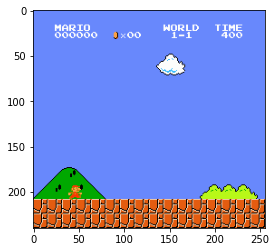

In [17]:
# Start the game 
img = plt.imshow(env.render(mode='rgb_array'))

# Loop through the game
for games in range(100):
    state = env.reset()
    while True: 
        action, _ = model.predict(state)

        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        state, reward, done, info = env.step(action)
        if done:
            break
            
# Close the game
env.close()